In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

import pickle
import mlflow
import time

import optuna
import optuna.visualization as vis

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

# Scalers
from sklearn.preprocessing import label_binarize

from imblearn.over_sampling import SMOTE, ADASYN

# Metrics
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, auc, roc_curve, precision_recall_curve, f1_score, confusion_matrix, balanced_accuracy_score, cohen_kappa_score, log_loss 

# Model
from sklearn.ensemble import RandomForestClassifier

# Model Selection - RandomForest

## 1. Load Data

In [101]:
attributes = pd.read_csv("data/btc_price_data_1_year_attributes.csv")
attributes.set_index('timestamp', inplace=True, drop = True)
attributes

,open,high,low,close,volume,month,day,weekday,hour,hour_sin,...,lag_47,lag_56,RSI,EMA12,EMA26,MACD,Signal_Line,SMA,EMA,future_return
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-11-01 00:56:00,34524.12,34549.26,34541.45,34524.49,31.117144,11,1,2,0,0.000000,...,34619.47,34667.88,47.431310,34542.664324,34556.581568,-13.917244,-12.759288,34553.5310,34550.874620,0.000377
2023-11-01 00:57:00,34524.13,34537.66,34524.52,34524.62,7.349951,11,1,2,0,0.000000,...,34603.20,34642.82,48.755135,34539.888274,34554.214045,-14.325771,-13.072585,34549.4505,34548.374180,-0.005330
2023-11-01 00:58:00,34519.85,34531.41,34527.81,34522.78,5.134526,11,1,2,0,0.000000,...,34602.26,34656.56,48.265451,34537.256232,34551.885597,-14.629365,-13.383941,34545.2715,34545.936639,0.025461
2023-11-01 00:59:00,34521.42,34531.98,34521.42,34531.57,4.310564,11,1,2,0,0.000000,...,34623.10,34629.34,41.702541,34536.381427,34550.380738,-13.999311,-13.507015,34542.0065,34544.568387,0.021053
2023-11-01 01:00:00,34531.46,34547.87,34532.22,34538.84,1.327905,11,1,2,1,0.258819,...,34611.54,34622.27,48.144440,34536.759669,34549.525868,-12.766199,-13.358852,34540.4225,34544.022827,0.011263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31 23:55:00,70248.97,70264.97,70248.98,70248.97,1.604753,10,31,3,23,-0.258819,...,70345.60,70383.13,15.731750,70316.514762,70363.992465,-47.477702,-35.505422,70367.7305,70348.638181,-0.014534
2024-10-31 23:56:00,70238.76,70248.97,70248.97,70238.76,1.189134,10,31,3,23,-0.258819,...,70329.38,70461.07,20.028025,70304.552491,70354.715986,-50.163495,-38.437037,70352.5490,70338.173592,-0.007859
2024-10-31 23:57:00,70218.00,70250.00,70238.77,70233.24,4.767082,10,31,3,23,-0.258819,...,70317.72,70470.15,14.761536,70293.581339,70345.717765,-52.136426,-41.176915,70338.1685,70328.179916,-0.036251


In [102]:
target_data = pd.read_csv("data/btc_price_data_1_year_target.csv")
target_data.set_index('timestamp', inplace=True, drop = True)
target = target_data['target']
target

timestamp
2023-11-01 00:56:00    0
2023-11-01 00:57:00    0
2023-11-01 00:58:00    0
2023-11-01 00:59:00    0
2023-11-01 01:00:00    0
                      ..
2024-10-31 23:55:00    0
2024-10-31 23:56:00    0
2024-10-31 23:57:00    0
2024-10-31 23:58:00    0
2024-10-31 23:59:00    0
Name: target, Length: 528575, dtype: int64

## 2. Data Splitting

In [103]:
attributes_train, attributes_test, target_train, target_test = train_test_split(
    attributes, 
    target, 
    test_size=0.2, 
    shuffle = False,
    random_state = 42
)

In [104]:
attributes_train.shape, attributes_test.shape

((422860, 52), (105715, 52))

In [105]:
target_train.shape, target_test.shape

((422860,), (105715,))

## 3. Oversampling- Address Class Imbalance

**SMOTE** (Synthetic Minority Oversampling Technique) and **ADASYN** (Adaptive Synthetic Sampling) are two popular oversampling techniques for addressing class imbalance in datasets. Both generate synthetic samples for the minority class to balance the dataset, but they differ in how they create these samples. Below is a detailed comparison to help you understand their strengths and use cases.

##### **Core Approach**

###### **SMOTE**
- **How it works**: 
  - For each minority class sample, SMOTE selects one or more nearest neighbors.
  - It creates synthetic samples by interpolating between the sample and its neighbors.
  - The interpolation is linear, producing samples along the line segments between the selected points.
- **Focus**: Generates synthetic samples evenly across the minority class.

###### **ADASYN**
- **How it works**: 
  - ADASYN builds on SMOTE by focusing more on the minority class samples that are harder to classify.
  - It identifies minority samples near the decision boundary (using k-nearest neighbors) and generates more synthetic samples in these regions.
  - The number of synthetic samples per instance is proportional to the local difficulty (measured by the density of majority class samples nearby).
- **Focus**: Creates samples adaptively, concentrating on areas where the minority class is harder to learn.

---

##### **Key Differences**

| Feature                     | **SMOTE**                                  | **ADASYN**                                      |
|-----------------------------|---------------------------------------------|------------------------------------------------|
| **Generation Strategy**     | Uniformly interpolates between samples.     | Focuses on generating samples near decision boundaries. |
| **Focus**                   | Balances the dataset evenly.               | Adaptive oversampling based on instance difficulty.      |
| **Synthetic Sample Location** | Can lead to over-generalization.           | More targeted and refined near complex regions. |
| **Computational Complexity**| Relatively lower computational cost.        | Slightly higher due to the adaptive nature.     |
| **Risk of Overfitting**     | Higher risk if the boundary is noisy.       | Reduced overfitting near decision boundaries.   |

---

##### **Strengths**

###### **SMOTE**
- **Advantages**:
  - Simple and effective for moderately imbalanced datasets.
  - Maintains the distribution of the minority class.
- **When to Use**:
  - When the imbalance is not extreme.
  - When you want a more uniform oversampling approach.

###### **ADASYN**
- **Advantages**:
  - Focuses on challenging regions, improving the model's ability to classify difficult cases.
  - Reduces the risk of overgeneralization by targeting specific areas.
- **When to Use**:
  - For highly imbalanced datasets.
  - When the minority class has complex boundaries or is under-represented in critical regions.

---

##### **Limitations**

###### **SMOTE**
- Does not consider the difficulty of classification.
- Can create synthetic samples in regions that are already well-represented, potentially leading to redundancy.
- May cause overfitting in noisy datasets.

###### **ADASYN**
- Slightly more computationally expensive than SMOTE.
- If the data is very noisy, it might generate samples in misleading or non-representative regions.


### 3.1. SMOTE (Synthetic Minority Oversampling Technique)

In [106]:
def create_oversampling_smote(attributes_train, target_train):
    """
    Apply SMOTE(Synthetic Minority Oversampling Technique) to generate synthetic examples for minority classes
    """
    smote = SMOTE(random_state=42)
    attributes_train_smote, target_train_smote = smote.fit_resample(attributes_train, target_train)
    
    print("Original Class Distribution (SMOTE):", np.bincount(target_train))
    print("Balanced Class Distribution (SMOTE):", np.bincount(target_train_smote))

    return attributes_train_smote, target_train_smote

### 3.2. ADASYN (Adaptive Synthetic Sampling)

In [107]:
def create_oversampling_adasyn(attributes_train, target_train):
    """
    Apply ADASYN(Adaptive Synthetic Sampling) to generate synthetic examples for minority classes
    """
    adasyn = ADASYN(random_state=42)
    attributes_train_adasyn, target_train_adasyn = adasyn.fit_resample(attributes_train, target_train)
    
    print("Original Class Distribution (ADASYN):", np.bincount(target_train))
    print("Balanced Class Distribution (ADASYN):", np.bincount(target_train_adasyn))

    return attributes_train_adasyn, target_train_adasyn

### 3.3. Set Oversampling Type

In [108]:
# Set oversampling type
oversampling_type = 'smote'

In [109]:
def create_oversampling(attributes_train, target_train, oversampling_type = None):
    """
    Apply 'oversampling_type' to generate synthetic examples for minority classes
    """
    if oversampling_type == 'smote':
        return create_oversampling_smote(attributes_train, target_train)
    elif oversampling_type == 'adasyn':
        return create_oversampling_adasyn(attributes_train, target_train)
    else:
        print(f"Invalid oversampling type: [{oversampling_type}]")
        return attributes_train, target_train

## 4. Feature Importance Regularization

Random forests can overfit when unimportant features dominate. Regularization can be achieved by the removing irrelevant features (feature selection).

### 4.1. Remove Low Importance Features

After training the model, identify and remove features with low importance.

In [110]:
def plot_feature_importance(model, importances, feature_names, title = 'Feature Importance'):
    # Feature importances
    # importances = model.feature_importances_
    # feature_names = attributes_train.columns
    sorted_indices = importances.argsort()
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_indices)), importances[sorted_indices], align='center')
    plt.yticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices])
    plt.title(title)
    plt.show()

In [111]:
def remove_low_important_features(rf_model, attributes, attributes_type):
    importances = rf_model.feature_importances_
    feature_names = attributes.columns
    
    # Plot the importances
    plot_feature_importance(rf_model, importances, feature_names, title = f'Feature Importance({attributes_type}) before drop')
    
    # Feature importance
    feature_importances = pd.DataFrame({
        'Feature': attributes.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values(by="Importance", ascending=False)
    
    # Drop features with low importance
    low_importance_features = feature_importances[feature_importances['Importance'] < 0.01]['Feature']
    attributes_reg = attributes.drop(columns=low_importance_features)

    print('attributes.shape before drop: ' , attributes.shape)
    print('attributes.shape after the drop: ', attributes_reg.shape)

    # Plot the importances after the drop
    # plot_feature_importance(rf_model, high_importance_features.Importance, high_importance_features.Feature, title = 'Feature Importance after the drop')

    return attributes_reg

## 5. Hyperparameter Tuning

We will use **Optuna** for the hyperparameter tuning.

In [112]:
initial_forest_model_parameters = {
    'n_estimators': 300,                                         
    'max_depth': 10,                                             
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'bootstrap': True,
    'class_weight': {0: 1, 1: 50, 2: 50},
    'random_state': 42,
    'verbose': 1,
    'n_jobs': 9
}

# 'class_weight': 'balanced',

### 5.1. Optuna

#### 5.1.1. Define the Objective Function

The objective function tests different hyperparameter combinations and evaluates their performance using cross-validation.

In [113]:
def objective(trial, model_type, oversampling_type = None, n_splits = 5):
    print(f"Start trial:[{trial.number}] for model:[{model_type}] with time series cross validation, oversampling:[{oversampling_type}] and n_splits:[{n_splits}]")

    # Define the hyperparameters to tune
    params = {
        # 'n_estimators': trial.suggest_int("n_estimators", 5, 25),     
        'n_estimators': trial.suggest_int("n_estimators", 50, 300),     
        'max_depth': trial.suggest_int("max_depth", 3, 10),   # Limits the depth of individual trees. Restricting tree depth prevents overfitting by forcing trees to be smaller and less complex.                                       
        'min_samples_split': trial.suggest_int("min_samples_split", 5, 10), # The minimum number of samples required to split an internal node. Increasing this value reduces tree branching
        'min_samples_leaf':  trial.suggest_int("min_samples_leaf", 3, 8), # The minimum number of samples required to be at a leaf node. Larger values create shallower trees and reduce overfitting
        'max_features': 'sqrt', # The number of features to consider when looking for the best split. Lower values add randomness to the splits, making the model less prone to overfitting
        'bootstrap': True,
        # 'class_weight': {0: 1, 1: 50, 2: 50},
        'random_state': 42,
        'verbose': 1,
        'n_jobs': -1,
        
        'class_weight': {    # Custom class weights. Classes 1 and 2 are very unbalanced. We therefore use fairly large values for the weights.
            0: 1,
            1: trial.suggest_int("class_weight_1", 30, 100),
            2: trial.suggest_int("class_weight_2", 30, 100)
        }
    }
    
    # Metrics collection
    scores = {
        #  The F1 score is the harmonic mean of precision and recall. The 'macro' version calculates the F1 score 
        #  for each class independently and then averages them, giving equal weight to all classes, regardless of their size
        'f1_macro_scores' : [],
        # Balanced accuracy is the average of recall obtained on each class. It accounts for class imbalance 
        # by giving equal weight to each class
        'balanced_acc_scores' : [],
        'f1_weighted_scores' : [],
        'kappa_scores' : [],
        'log_loss_scores' : [],
        'roc_auc_scores' : [],
    }

    # Use TimeSeriesSplit for time series cross-validation
    tscv = TimeSeriesSplit(n_splits = n_splits)
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(attributes)):
        attributes_train_fold, attributes_val_fold = attributes.iloc[train_idx], attributes.iloc[val_idx]
        target_train_fold, target_val_fold = target.iloc[train_idx], target.iloc[val_idx]

        # Apply oversampling to handle class imbalance in training data
        attributes_train_fold, target_train_fold = create_oversampling(
            attributes_train_fold,
            target_train_fold, 
            oversampling_type
        )
        
        # Train RandomForestClassifier model
        rf_model_split = RandomForestClassifier(**params)
        rf_model_split.fit(attributes_train_fold,target_train_fold)

        # Predictions and probabilities
        target_val_pred = rf_model_split.predict(attributes_val_fold)
        target_val_proba = rf_model_split.predict_proba(attributes_val_fold)

        # Calculate metrics for this fold
        scores['f1_macro_scores'].append(f1_score(target_val_fold, target_val_pred, average='macro'))
        scores['f1_weighted_scores'].append(f1_score(target_val_fold, target_val_pred, average='weighted'))
        scores['balanced_acc_scores'].append(balanced_accuracy_score(target_val_fold, target_val_pred))
        scores['kappa_scores'].append(cohen_kappa_score(target_val_fold, target_val_pred))
        scores['log_loss_scores'].append(log_loss(target_val_fold, target_val_proba))
        scores['roc_auc_scores'].append(roc_auc_score(target_val_fold, target_val_proba, multi_class='ovr'))

        print(f"Fold {fold+1} Classification Report")
        print(classification_report(target_val_fold, target_val_pred))

    # Aggregate metrics across folds
    avg_scores = {metric: np.mean(values) for metric, values in scores.items()}

    print("\nCross-Validated Metrics:")
    print(f"F1-Score (Macro): {avg_scores['f1_macro_scores']:.4f} ± {np.std(scores['f1_macro_scores']):.4f}")
    print(f"F1-Score (Weighted): {avg_scores['f1_weighted_scores']:.4f} ± {np.std(scores['f1_weighted_scores']):.4f}")
    print(f"Balanced Accuracy: {avg_scores['balanced_acc_scores']:.4f} ± {np.std(scores['balanced_acc_scores']):.4f}")
    print(f"Cohen's Kappa: {avg_scores['kappa_scores']:.4f} ± {np.std(scores['kappa_scores']):.4f}")
    print(f"Log Loss: {avg_scores['log_loss_scores']:.4f} ± {np.std(scores['log_loss_scores']):.4f}")
    print(f"ROC-AUC: {avg_scores['roc_auc_scores']:.4f} ± {np.std(scores['roc_auc_scores']):.4f}")

    # print(f"F1-Score (Macro): {np.mean(f1_macro_scores):.4f} ± {np.std(f1_macro_scores):.4f}")
    # print(f"F1-Score (Weighted): {np.mean(f1_weighted_scores):.4f} ± {np.std(f1_weighted_scores):.4f}")
    # print(f"Balanced Accuracy: {np.mean(balanced_acc_scores):.4f} ± {np.std(balanced_acc_scores):.4f}")
    # print(f"Cohen's Kappa: {np.mean(kappa_scores):.4f} ± {np.std(kappa_scores):.4f}")
    # print(f"Log Loss: {np.mean(log_loss_scores):.4f} ± {np.std(log_loss_scores):.4f}")
    # print(f"ROC-AUC: {np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}")

    # # Aggregate scores across folds
    # print("\nCross-Validated Metrics:")
    # for metric, score in avg_scores.items():
    #     print(f"{metric}: {score:.4f}")

    # Log all scores to Optuna
    trial.set_user_attr("scores", avg_scores)
    
    # Return the mean F1-macro across all folds
    return np.mean(f1_macro_scores)


#### 5.1.2. Run the Optuna Study in MLFlow

In [132]:
model_type = 'RandomForestClassifier'
n_trials = 50 # default : 50
n_splits = 5 # default : 5
posfix = '_test_3'
mlflow_run_name = f"BTC_{model_type}_Optuna_{oversampling_type}_Trials_{n_trials}{posfix}"

print("Oversampling Type:", oversampling_type)
print("n_trials:", n_trials)
print("n_splits:", n_splits)
print("mlflow_run_name:", mlflow_run_name)

Oversampling Type: smote
n_trials: 50
n_splits: 5
mlflow_run_name: BTC_RandomForestClassifier_Optuna_smote_Trials_50_test_3


In [133]:
# Create a MLFlow experiment
experiment_name = f"BTC_{model_type}_Optuna"
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    mlflow.create_experiment(experiment_name)

In [134]:
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///C:/Users/valch/OneDrive/Desktop/03.Machine%20Learning-September-2024/Exam/02.Exam-Project/01.Repo/Algorithmic-Trading-Bot/Notebook/mlruns/434433705189061509', creation_time=1732997854737, experiment_id='434433705189061509', last_update_time=1732997854737, lifecycle_stage='active', name='BTC_RandomForestClassifier_Optuna', tags={}>

In [135]:
# def merge_params(initial_forest_model_parameters, best_params):
#     # Remove class_weight keys
#     class_weight_1 = best_params.pop['class_weight_1']
#     class_weight_2 = best_params.pop['class_weight_2']

#     # Add the weight keys to the 'initila_params'
#     initila_params['class_weight'] = {0: 1, 1: class_weight_1, 2: class_weight_2}

#     # Merge the two dictionaries
#     merged_params = initial_forest_model_parameters | study.best_params
#     return merged_params

In [ ]:
with mlflow.start_run(run_name = mlflow_run_name):
    mlflow.log_param("train size", len(attributes_train))
    mlflow.log_param("test size", len(attributes_test))

    # Create a Optuna study and optimize
    study = optuna.create_study(direction='maximize')
    study.optimize(
        partial(objective, model_type = model_type, oversampling_type = oversampling_type, n_splits = n_splits),
        n_trials = n_trials
    )

    # Visualize optimization history
    optimization_history_plot = vis.plot_optimization_history(study)
    # Visualize parameter importance
    param_importance_plot = vis.plot_param_importances(study)
    # Visualize hyperparameter values
    hyperparameter_values_plot = vis.plot_parallel_coordinate(study)

    # Save visualizations to files
    optimization_history_plot.write_html(f"data/{model_type}/{oversampling_type}/optimization_history_{model_type}_{oversampling_type}.html")
    param_importance_plot.write_html(f"data/{model_type}/{oversampling_type}/param_importances_{model_type}_{oversampling_type}.html")
    hyperparameter_values_plot.write_html(f"data/{model_type}/{oversampling_type}/hyperparameter_values_{model_type}_{oversampling_type}.html")

    # Log visualization MLflow artifacts
    mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/optimization_history_{model_type}_{oversampling_type}.html")
    mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/param_importances_{model_type}_{oversampling_type}.html")
    mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/hyperparameter_values_{model_type}_{oversampling_type}.html")

    ################################################################################
    # TODO: fix logs for params
    ################################################################################
    # Get the best trial
    best_trial = study.best_trial

    # Output the best hyperparameters
    print("Best Parameters:", study.best_params)
    print("Best F1-macro-score-fine-tuning:", study.best_value)
    print("Best Trial:", best_trial)

    # Access the parameters of the best trial
    print("Best Trial Parameters:")
    print(f"Trial {best_trial.number}:")
    print(f"Parameters: {best_trial.params}")
    
   # Access the scores stored in user attributes
    print("\nBest Trial Scores:")
    for metric, value in best_trial.user_attrs['scores'].items():
        print(f"{metric}: {value:.4f}")
        mlflow.log_metric(metric, value)

    # print("\nRecommended hyperparameters for subsequent use:")
    # print("rf_model = RandomForestClassifier(")
    # for param, value in study.best_params.items():
    #     print(f"    {param}={value},")
    #     print("    random_state=42,")
    #     print("    n_jobs=-1")
    #     print(")")

    ################################################################################
    # END: fix logs for params
    ################################################################################

    # mlflow.log_params('class_weight_1', study.best_params['class_weight_1'])
    # mlflow.log_params('class_weight_2', study.best_params['class_weight_2'])
    mlflow.log_metric("best_F1-macro_score_fine_tuning", study.best_value)
    
    # Train best model
    # merged_params = merge_params(initial_forest_model_parameters, study.best_params)
    # # Remove class_weight keys
    merged_params = initial_forest_model_parameters | study.best_params
    del merged_params['class_weight_1']
    del merged_params['class_weight_2']

    print("merged_params:", merged_params)

    mlflow.log_params(merged_params)
    
    # Train the Final Model with Best Parameters
    rf_model = RandomForestClassifier(**merged_params)
    rf_model.fit(attributes_train, target_train)

    # Removing irrelevant features (feature selection)
    attributes_train_reg = remove_low_important_features(rf_model, attributes_train, attributes_type = 'train')
    attributes_test_reg = remove_low_important_features(rf_model, attributes_test, attributes_type = 'test')

    print(f"High important features after feature selection (regularization): ", attributes_train_reg.columns)

    # Train the Final Model with Best Parameters and without the low important featires
    rf_model_reg = RandomForestClassifier(**merged_params)
    rf_model_reg.fit(attributes_train_reg, target_train)

    # Validate
    target_train_pred = rf_model_reg.predict(attributes_train_reg)
    classification_train_report = classification_report(target_train, target_train_pred)

    target_test_pred = rf_model_reg.predict(attributes_test_reg)
    classification_test_report = classification_report(target_test, target_test_pred)
   
    print(f"classification_train_report_{model_type}_{oversampling_type}: ", classification_train_report)
    print(f"classification_test_report_{model_type}_{oversampling_type}: ", classification_test_report)

    # F1-macro score after the regularization
    f1_macro_score = f1_score(target_test, target_test_pred, average='macro')
    print(f"F1-Score (Macro): {f1_macro_score:.4f}")
    
    mlflow.log_metric("F1-macro-score-important-features", f1_macro_score)

    # Log metrics
    mlflow.log_metric(f"train_accuracy_{model_type}_{oversampling_type}", rf_model_reg.score(attributes_train_reg, target_train))
    mlflow.log_metric(f"test_accuracy_{model_type}_{oversampling_type}", rf_model_reg.score(attributes_test_reg, target_test))

    with open(f"data/{model_type}/{oversampling_type}/train_report_{model_type}_{oversampling_type}.txt",  "w") as f:
        f.write(classification_train_report)
    with open(f"data/{model_type}/{oversampling_type}/test_report_{model_type}_{oversampling_type}.txt",  "w") as f:
        f.write(classification_test_report)
        
    pickle.dump(rf_model_reg, open(f"data/{model_type}/{oversampling_type}/model_{model_type}_{oversampling_type}.pkl", "wb"))

    # Log artifacts
    mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/model_{model_type}_{oversampling_type}.pkl")
    mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/train_report_{model_type}_{oversampling_type}.txt")
    mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/test_report_{model_type}_{oversampling_type}.txt")
    
    classes = [0, 1, 2]
    #evaluate_model(rf_model_reg, attributes_test, target_test, classes)

[I 2024-12-01 12:48:27,904] A new study created in memory with name: no-name-9a94e5eb-1c45-43d9-9c7d-806c7b4b8916


Start trial:[0] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 231 out of 231 | elapsed:   49.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 231 out of 231 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 231 out of 231 | elapsed:    0.1s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     87639
           1       0.03      0.88      0.06       209
           2       0.03      0.89      0.06       247

    accuracy                           0.86     88095
   macro avg       0.35      0.88      0.35     88095
weighted avg       0.99      0.86      0.92     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 231 out of 231 | elapsed:  2.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 231 out of 231 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 231 out of 231 | elapsed:    0.1s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     87564
           1       0.05      0.14      0.07       248
           2       0.04      0.82      0.07       283

    accuracy                           0.92     88095
   macro avg       0.36      0.63      0.37     88095
weighted avg       0.99      0.92      0.95     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 231 out of 231 | elapsed:  3.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 231 out of 231 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 231 out of 231 | elapsed:    0.1s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 231 out of 231 | elapsed:  4.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 231 out of 231 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 231 out of 231 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     87620
           1       0.03      1.00      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.82     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.82      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 231 out of 231 | elapsed:  5.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 231 out of 231 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 231 out of 231 | elapsed:    0.1s finished
[I 2024-12-01 13:05:27,179] Trial 0 finished with value: 0.347997996509903 and parameters: {'n_estimators': 231, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_lea

Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3480 ± 0.0105
F1-Score (Weighted): 0.9170 ± 0.0199
Balanced Accuracy: 0.8647 ± 0.1201
Cohen's Kappa: 0.0540 ± 0.0055
Log Loss: 0.6085 ± 0.2062
ROC-AUC: 0.9561 ± 0.0096
Start trial:[1] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 193 out of 193 | elapsed:   51.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 193 out of 193 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 193 out of 193 | elapsed:    0.1s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     87639
           1       0.03      0.85      0.06       209
           2       0.03      0.72      0.07       247

    accuracy                           0.88     88095
   macro avg       0.36      0.82      0.36     88095
weighted avg       0.99      0.88      0.93     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 193 out of 193 | elapsed:  2.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 193 out of 193 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 193 out of 193 | elapsed:    0.1s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     87564
           1       0.05      0.13      0.07       248
           2       0.05      0.45      0.09       283

    accuracy                           0.96     88095
   macro avg       0.36      0.52      0.38     88095
weighted avg       0.99      0.96      0.97     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 193 out of 193 | elapsed:  3.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 193 out of 193 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 193 out of 193 | elapsed:    0.1s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 193 out of 193 | elapsed:  4.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 193 out of 193 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 193 out of 193 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.90     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.93      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 193 out of 193 | elapsed:  5.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 193 out of 193 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 193 out of 193 | elapsed:    0.1s finished
[I 2024-12-01 13:22:29,238] Trial 1 finished with value: 0.352081867655147 and parameters: {'n_estimators': 193, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 7, 'class_weight_1': 97, 'class_weight_2': 65}. Best is trial 1 with value: 0.352081867655147.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3521 ± 0.0150
F1-Score (Weighted): 0.9242 ± 0.0275
Balanced Accuracy: 0.8308 ± 0.1643
Cohen's Kappa: 0.0576 ± 0.0105
Log Loss: 0.6010 ± 0.2468
ROC-AUC: 0.9535 ± 0.0129
Start trial:[2] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 167 out of 167 | elapsed:   17.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 167 out of 167 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 167 out of 167 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.15      0.27     87639
           1       0.01      1.00      0.01       209
           2       0.01      1.00      0.01       247

    accuracy                           0.16     88095
   macro avg       0.34      0.72      0.10     88095
weighted avg       0.99      0.16      0.26     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 167 out of 167 | elapsed:   38.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 167 out of 167 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 167 out of 167 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.02      0.04     87564
           1       0.01      1.00      0.02       248
           2       0.00      1.00      0.01       283

    accuracy                           0.03     88095
   macro avg       0.34      0.67      0.02     88095
weighted avg       0.99      0.03      0.04     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 167 out of 167 | elapsed:  1.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 167 out of 167 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 167 out of 167 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     87656
           1       0.01      1.00      0.01       215
           2       0.00      1.00      0.01       224

    accuracy                           0.01     88095
   macro avg       0.34      0.67      0.01     88095
weighted avg       1.00      0.01      0.00     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 167 out of 167 | elapsed:  1.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 167 out of 167 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 167 out of 167 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.01      0.01     87620
           1       0.01      1.00      0.01       231
           2       0.01      1.00      0.01       244

    accuracy                           0.01     88095
   macro avg       0.34      0.67      0.01     88095
weighted avg       0.99      0.01      0.01     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 167 out of 167 | elapsed:  1.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 167 out of 167 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 167 out of 167 | elapsed:    0.1s finished
[I 2024-12-01 13:28:00,578] Trial 2 finished with value: 0.029521455451319983 and parameters: {'n_estimators': 167, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 6, 'class_weight_1': 60, 'class_weight_2': 46}. Best is trial 1 with value: 0.352081867655147.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.00      0.01     87649
           1       0.01      1.00      0.01       225
           2       0.00      1.00      0.01       221

    accuracy                           0.01     88095
   macro avg       0.34      0.67      0.01     88095
weighted avg       0.99      0.01      0.01     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.0295 ± 0.0341
F1-Score (Weighted): 0.0652 ± 0.1007
Balanced Accuracy: 0.6787 ± 0.0189
Cohen's Kappa: 0.0031 ± 0.0007
Log Loss: 1.8110 ± 0.2329
ROC-AUC: 0.9506 ± 0.0053
Start trial:[3] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 297 out of 297 | elapsed:  1.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 297 out of 297 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 297 out of 297 | elapsed:    0.2s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     87639
           1       0.03      0.86      0.06       209
           2       0.04      0.56      0.07       247

    accuracy                           0.89     88095
   macro avg       0.36      0.77      0.36     88095
weighted avg       0.99      0.89      0.94     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 297 out of 297 | elapsed:  3.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 297 out of 297 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 297 out of 297 | elapsed:    0.1s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     87564
           1       0.05      0.13      0.07       248
           2       0.04      0.72      0.08       283

    accuracy                           0.94     88095
   macro avg       0.36      0.60      0.37     88095
weighted avg       0.99      0.94      0.96     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 297 out of 297 | elapsed:  4.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 297 out of 297 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 297 out of 297 | elapsed:    0.2s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 297 out of 297 | elapsed:  6.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 297 out of 297 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 297 out of 297 | elapsed:    0.2s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.90     87620
           1       0.03      1.00      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 297 out of 297 | elapsed:  8.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 297 out of 297 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 297 out of 297 | elapsed:    0.2s finished
[I 2024-12-01 13:52:40,169] Trial 3 finished with value: 0.3515899104815127 and parameters: {'n_estimators': 297, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_le

Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3516 ± 0.0128
F1-Score (Weighted): 0.9236 ± 0.0239
Balanced Accuracy: 0.8382 ± 0.1361
Cohen's Kappa: 0.0568 ± 0.0086
Log Loss: 0.5624 ± 0.2168
ROC-AUC: 0.9552 ± 0.0106
Start trial:[4] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 237 out of 237 | elapsed:   40.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 237 out of 237 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 237 out of 237 | elapsed:    0.1s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.69      0.82     87639
           1       0.01      0.99      0.03       209
           2       0.02      0.97      0.04       247

    accuracy                           0.69     88095
   macro avg       0.34      0.88      0.29     88095
weighted avg       0.99      0.69      0.81     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 237 out of 237 | elapsed:  1.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 237 out of 237 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 237 out of 237 | elapsed:    0.1s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.77      0.87     87564
           1       0.03      0.98      0.05       248
           2       0.02      1.00      0.05       283

    accuracy                           0.78     88095
   macro avg       0.35      0.92      0.32     88095
weighted avg       0.99      0.78      0.87     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 237 out of 237 | elapsed:  2.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 237 out of 237 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 237 out of 237 | elapsed:    0.1s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.42      0.59     87656
           1       0.01      1.00      0.02       215
           2       0.01      1.00      0.02       224

    accuracy                           0.42     88095
   macro avg       0.34      0.81      0.21     88095
weighted avg       1.00      0.42      0.59     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 237 out of 237 | elapsed:  3.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 237 out of 237 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 237 out of 237 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.42      0.60     87620
           1       0.01      1.00      0.02       231
           2       0.01      1.00      0.02       244

    accuracy                           0.43     88095
   macro avg       0.34      0.81      0.21     88095
weighted avg       0.99      0.43      0.59     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 237 out of 237 | elapsed:  4.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 237 out of 237 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 237 out of 237 | elapsed:    0.1s finished
[I 2024-12-01 14:04:57,088] Trial 4 finished with value: 0.2509712618876838 and parameters: {'n_estimators': 237, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_le

Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.44      0.61     87649
           1       0.01      0.99      0.02       225
           2       0.01      1.00      0.02       221

    accuracy                           0.44     88095
   macro avg       0.34      0.81      0.22     88095
weighted avg       0.99      0.44      0.61     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.2510 ± 0.0488
F1-Score (Weighted): 0.6945 ± 0.1204
Balanced Accuracy: 0.8450 ± 0.0466
Cohen's Kappa: 0.0194 ± 0.0126
Log Loss: 1.1032 ± 0.2776
ROC-AUC: 0.9542 ± 0.0062
Start trial:[5] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 199 out of 199 | elapsed:   49.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 199 out of 199 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 199 out of 199 | elapsed:    0.1s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.86      0.93     87639
           1       0.03      0.88      0.06       209
           2       0.03      0.87      0.07       247

    accuracy                           0.86     88095
   macro avg       0.35      0.87      0.35     88095
weighted avg       0.99      0.86      0.92     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 199 out of 199 | elapsed:  1.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 199 out of 199 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 199 out of 199 | elapsed:    0.1s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     87564
           1       0.04      0.13      0.07       248
           2       0.04      0.81      0.08       283

    accuracy                           0.93     88095
   macro avg       0.36      0.62      0.37     88095
weighted avg       0.99      0.93      0.96     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 199 out of 199 | elapsed:  3.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 199 out of 199 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 199 out of 199 | elapsed:    0.1s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.83      0.90     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 199 out of 199 | elapsed:  4.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 199 out of 199 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 199 out of 199 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.82     88095
   macro avg       0.35      0.93      0.34     88095
weighted avg       0.99      0.82      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 199 out of 199 | elapsed:  5.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 199 out of 199 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 199 out of 199 | elapsed:    0.1s finished
[I 2024-12-01 14:20:03,525] Trial 5 finished with value: 0.34761085931728175 and parameters: {'n_estimators': 199, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_

Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.83      0.90     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3476 ± 0.0108
F1-Score (Weighted): 0.9170 ± 0.0212
Balanced Accuracy: 0.8620 ± 0.1231
Cohen's Kappa: 0.0540 ± 0.0064
Log Loss: 0.6612 ± 0.2484
ROC-AUC: 0.9533 ± 0.0122
Start trial:[6] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 226 out of 226 | elapsed:   38.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 226 out of 226 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 226 out of 226 | elapsed:    0.1s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.68      0.81     87639
           1       0.01      0.99      0.03       209
           2       0.02      0.98      0.04       247

    accuracy                           0.68     88095
   macro avg       0.34      0.88      0.29     88095
weighted avg       0.99      0.68      0.80     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 226 out of 226 | elapsed:  1.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 226 out of 226 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 226 out of 226 | elapsed:    0.1s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.75      0.85     87564
           1       0.03      0.98      0.05       248
           2       0.02      1.00      0.04       283

    accuracy                           0.75     88095
   macro avg       0.35      0.91      0.32     88095
weighted avg       0.99      0.75      0.85     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 226 out of 226 | elapsed:  2.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 226 out of 226 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 226 out of 226 | elapsed:    0.1s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.42      0.60     87656
           1       0.01      1.00      0.02       215
           2       0.01      1.00      0.02       224

    accuracy                           0.43     88095
   macro avg       0.34      0.81      0.21     88095
weighted avg       1.00      0.43      0.59     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 226 out of 226 | elapsed:  3.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 226 out of 226 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 226 out of 226 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.43      0.60     87620
           1       0.01      1.00      0.02       231
           2       0.01      1.00      0.02       244

    accuracy                           0.43     88095
   macro avg       0.34      0.81      0.21     88095
weighted avg       0.99      0.43      0.60     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 226 out of 226 | elapsed:  4.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 226 out of 226 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 226 out of 226 | elapsed:    0.1s finished
[I 2024-12-01 14:31:35,289] Trial 6 finished with value: 0.24720553929067335 and parameters: {'n_estimators': 226, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_l

Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.42      0.59     87649
           1       0.01      0.99      0.02       225
           2       0.01      1.00      0.02       221

    accuracy                           0.42     88095
   macro avg       0.34      0.80      0.21     88095
weighted avg       0.99      0.42      0.59     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.2472 ± 0.0465
F1-Score (Weighted): 0.6857 ± 0.1164
Balanced Accuracy: 0.8412 ± 0.0438
Cohen's Kappa: 0.0180 ± 0.0106
Log Loss: 1.1045 ± 0.2675
ROC-AUC: 0.9537 ± 0.0062
Start trial:[7] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:   10.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  94 out of  94 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  94 out of  94 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.23      0.37     87639
           1       0.01      1.00      0.01       209
           2       0.01      1.00      0.02       247

    accuracy                           0.23     88095
   macro avg       0.34      0.74      0.13     88095
weighted avg       0.99      0.23      0.37     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:   21.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  94 out of  94 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  94 out of  94 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.13      0.23     87564
           1       0.01      1.00      0.02       248
           2       0.01      1.00      0.01       283

    accuracy                           0.13     88095
   macro avg       0.34      0.71      0.08     88095
weighted avg       0.99      0.13      0.23     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:   36.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  94 out of  94 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  94 out of  94 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.03      0.05     87656
           1       0.00      1.00      0.01       215
           2       0.01      1.00      0.01       224

    accuracy                           0.03     88095
   macro avg       0.34      0.68      0.02     88095
weighted avg       1.00      0.03      0.05     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:   48.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  94 out of  94 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  94 out of  94 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.03      0.06     87620
           1       0.01      1.00      0.01       231
           2       0.01      1.00      0.01       244

    accuracy                           0.04     88095
   macro avg       0.34      0.68      0.03     88095
weighted avg       0.99      0.04      0.06     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:  1.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  94 out of  94 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  94 out of  94 | elapsed:    0.0s finished
[I 2024-12-01 14:34:44,342] Trial 7 finished with value: 0.05944239674699636 and parameters: {'n_estimators': 94, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 5, 'class_weight_1': 50, 'class_weight_2': 60}. Best is trial 1 with value: 0.352081867655147.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.03      0.06     87649
           1       0.01      1.00      0.01       225
           2       0.01      1.00      0.01       221

    accuracy                           0.04     88095
   macro avg       0.34      0.68      0.03     88095
weighted avg       0.99      0.04      0.06     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.0594 ± 0.0432
F1-Score (Weighted): 0.1538 ± 0.1263
Balanced Accuracy: 0.6961 ± 0.0259
Cohen's Kappa: 0.0038 ± 0.0012
Log Loss: 1.7682 ± 0.2276
ROC-AUC: 0.9514 ± 0.0050
Start trial:[8] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:   18.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  83 out of  83 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  83 out of  83 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.92     87639
           1       0.03      0.91      0.06       209
           2       0.03      0.95      0.06       247

    accuracy                           0.84     88095
   macro avg       0.35      0.90      0.34     88095
weighted avg       0.99      0.84      0.91     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:   41.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  83 out of  83 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  83 out of  83 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     87564
           1       0.04      0.61      0.08       248
           2       0.03      0.95      0.06       283

    accuracy                           0.87     88095
   macro avg       0.36      0.81      0.36     88095
weighted avg       0.99      0.87      0.93     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:  1.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  83 out of  83 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  83 out of  83 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.76      0.86     87656
           1       0.03      1.00      0.06       215
           2       0.02      1.00      0.03       224

    accuracy                           0.76     88095
   macro avg       0.35      0.92      0.32     88095
weighted avg       1.00      0.76      0.86     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:  1.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  83 out of  83 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  83 out of  83 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.80      0.89     87620
           1       0.03      1.00      0.06       231
           2       0.02      0.99      0.05       244

    accuracy                           0.80     88095
   macro avg       0.35      0.93      0.33     88095
weighted avg       0.99      0.80      0.88     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:  2.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  83 out of  83 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  83 out of  83 | elapsed:    0.0s finished
[I 2024-12-01 14:40:36,426] Trial 8 finished with value: 0.33588786197902654 and parameters: {'n_estimators': 83, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 4, 'class_weight_1': 75, 'class_weight_2': 42}. Best is trial 1 with value: 0.352081867655147.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.80      0.89     87649
           1       0.03      0.99      0.06       225
           2       0.02      1.00      0.04       221

    accuracy                           0.80     88095
   macro avg       0.35      0.93      0.33     88095
weighted avg       1.00      0.80      0.89     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3359 ± 0.0139
F1-Score (Weighted): 0.8930 ± 0.0226
Balanced Accuracy: 0.8983 ± 0.0447
Cohen's Kappa: 0.0459 ± 0.0092
Log Loss: 0.7682 ± 0.2326
ROC-AUC: 0.9561 ± 0.0077
Start trial:[9] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   32.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 210 out of 210 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 210 out of 210 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.45      0.62     87639
           1       0.01      1.00      0.02       209
           2       0.01      0.99      0.02       247

    accuracy                           0.45     88095
   macro avg       0.34      0.81      0.22     88095
weighted avg       0.99      0.45      0.62     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  1.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 210 out of 210 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 210 out of 210 | elapsed:    0.1s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.49      0.66     87564
           1       0.02      0.99      0.05       248
           2       0.01      1.00      0.02       283

    accuracy                           0.49     88095
   macro avg       0.34      0.83      0.24     88095
weighted avg       0.99      0.49      0.65     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  1.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 210 out of 210 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 210 out of 210 | elapsed:    0.1s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.29      0.45     87656
           1       0.01      1.00      0.02       215
           2       0.01      1.00      0.01       224

    accuracy                           0.29     88095
   macro avg       0.34      0.76      0.16     88095
weighted avg       1.00      0.29      0.45     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  2.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 210 out of 210 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 210 out of 210 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.30      0.47     87620
           1       0.01      1.00      0.02       231
           2       0.01      1.00      0.01       244

    accuracy                           0.31     88095
   macro avg       0.34      0.77      0.17     88095
weighted avg       0.99      0.31      0.46     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  3.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 210 out of 210 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 210 out of 210 | elapsed:    0.0s finished
[I 2024-12-01 14:49:37,163] Trial 9 finished with value: 0.19080066465131434 and parameters: {'n_estimators': 210, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_l

Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.32      0.48     87649
           1       0.01      1.00      0.02       225
           2       0.01      1.00      0.01       221

    accuracy                           0.32     88095
   macro avg       0.34      0.77      0.17     88095
weighted avg       0.99      0.32      0.48     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.1908 ± 0.0326
F1-Score (Weighted): 0.5317 ± 0.0854
Balanced Accuracy: 0.7882 ± 0.0256
Cohen's Kappa: 0.0092 ± 0.0029
Log Loss: 1.3759 ± 0.2252
ROC-AUC: 0.9513 ± 0.0079
Start trial:[10] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 137 out of 137 | elapsed:   41.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 137 out of 137 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 137 out of 137 | elapsed:    0.1s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     87639
           1       0.03      0.80      0.07       209
           2       0.03      0.49      0.06       247

    accuracy                           0.91     88095
   macro avg       0.36      0.73      0.36     88095
weighted avg       0.99      0.91      0.95     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 137 out of 137 | elapsed:  1.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 137 out of 137 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 137 out of 137 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     87564
           1       0.05      0.13      0.07       248
           2       0.04      0.15      0.07       283

    accuracy                           0.98     88095
   macro avg       0.36      0.42      0.37     88095
weighted avg       0.99      0.98      0.98     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 137 out of 137 | elapsed:  2.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 137 out of 137 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 137 out of 137 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 137 out of 137 | elapsed:  3.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 137 out of 137 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 137 out of 137 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 137 out of 137 | elapsed:  4.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 137 out of 137 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 137 out of 137 | elapsed:    0.0s finished
[I 2024-12-01 15:02:17,156] Trial 10 finished with value: 0.35236008700176225 and parameters: {'n_estimators': 137, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 6, 'class_weight_1': 93, 'class_weight_2': 81}. Best is trial 10 with value: 0.35236008700176225.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3524 ± 0.0131
F1-Score (Weighted): 0.9291 ± 0.0310
Balanced Accuracy: 0.7944 ± 0.2033
Cohen's Kappa: 0.0547 ± 0.0041
Log Loss: 0.5493 ± 0.2431
ROC-AUC: 0.9510 ± 0.0164
Start trial:[11] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:   40.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 132 out of 132 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 132 out of 132 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     87639
           1       0.03      0.78      0.07       209
           2       0.03      0.49      0.06       247

    accuracy                           0.91     88095
   macro avg       0.36      0.73      0.36     88095
weighted avg       0.99      0.91      0.95     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:  1.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 132 out of 132 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 132 out of 132 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     87564
           1       0.05      0.13      0.07       248
           2       0.04      0.13      0.06       283

    accuracy                           0.98     88095
   macro avg       0.36      0.41      0.37     88095
weighted avg       0.99      0.98      0.98     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:  2.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 132 out of 132 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 132 out of 132 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:  3.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 132 out of 132 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 132 out of 132 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:  4.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 132 out of 132 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 132 out of 132 | elapsed:    0.0s finished
[I 2024-12-01 15:14:05,831] Trial 11 finished with value: 0.351688658141977 and parameters: {'n_estimators': 132, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 6, 'class_weight_1': 100, 'class_weight_2': 75}. Best is trial 10 with value: 0.35236008700176225.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3517 ± 0.0120
F1-Score (Weighted): 0.9291 ± 0.0311
Balanced Accuracy: 0.7918 ± 0.2069
Cohen's Kappa: 0.0534 ± 0.0025
Log Loss: 0.5530 ± 0.2437
ROC-AUC: 0.9497 ± 0.0180
Start trial:[12] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:   40.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 139 out of 139 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 139 out of 139 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     87639
           1       0.03      0.81      0.07       209
           2       0.03      0.48      0.06       247

    accuracy                           0.91     88095
   macro avg       0.36      0.73      0.36     88095
weighted avg       0.99      0.91      0.95     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:  1.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 139 out of 139 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 139 out of 139 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     87564
           1       0.05      0.13      0.07       248
           2       0.04      0.15      0.06       283

    accuracy                           0.98     88095
   macro avg       0.36      0.42      0.37     88095
weighted avg       0.99      0.98      0.98     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:  2.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 139 out of 139 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 139 out of 139 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:  3.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 139 out of 139 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 139 out of 139 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:  4.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 139 out of 139 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 139 out of 139 | elapsed:    0.0s finished
[I 2024-12-01 15:26:38,547] Trial 12 finished with value: 0.3519846267440584 and parameters: {'n_estimators': 139, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 5, 'class_weight_1': 96, 'class_weight_2': 75}. Best is trial 10 with value: 0.35236008700176225.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3520 ± 0.0124
F1-Score (Weighted): 0.9290 ± 0.0307
Balanced Accuracy: 0.7947 ± 0.2037
Cohen's Kappa: 0.0540 ± 0.0030
Log Loss: 0.5490 ± 0.2367
ROC-AUC: 0.9520 ± 0.0152
Start trial:[13] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:   15.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  57 out of  57 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  57 out of  57 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.88      0.93     87639
           1       0.03      0.86      0.06       209
           2       0.03      0.77      0.07       247

    accuracy                           0.88     88095
   macro avg       0.35      0.84      0.35     88095
weighted avg       0.99      0.88      0.93     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:   34.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  57 out of  57 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  57 out of  57 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     87564
           1       0.05      0.13      0.07       248
           2       0.04      0.67      0.08       283

    accuracy                           0.94     88095
   macro avg       0.36      0.58      0.37     88095
weighted avg       0.99      0.94      0.97     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:   55.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  57 out of  57 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  57 out of  57 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:  1.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  57 out of  57 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  57 out of  57 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.93      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:  1.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  57 out of  57 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  57 out of  57 | elapsed:    0.0s finished
[I 2024-12-01 15:31:29,420] Trial 13 finished with value: 0.3504959206975714 and parameters: {'n_estimators': 57, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 7, 'class_weight_1': 87, 'class_weight_2': 74}. Best is trial 10 with value: 0.35236008700176225.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3505 ± 0.0129
F1-Score (Weighted): 0.9214 ± 0.0240
Balanced Accuracy: 0.8477 ± 0.1376
Cohen's Kappa: 0.0565 ± 0.0090
Log Loss: 0.6180 ± 0.2479
ROC-AUC: 0.9530 ± 0.0129
Start trial:[14] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:   47.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 161 out of 161 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 161 out of 161 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     87639
           1       0.03      0.81      0.07       209
           2       0.03      0.48      0.06       247

    accuracy                           0.91     88095
   macro avg       0.36      0.73      0.36     88095
weighted avg       0.99      0.91      0.95     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:  1.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 161 out of 161 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 161 out of 161 | elapsed:    0.1s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     87564
           1       0.05      0.12      0.07       248
           2       0.03      0.09      0.05       283

    accuracy                           0.98     88095
   macro avg       0.36      0.40      0.37     88095
weighted avg       0.99      0.98      0.98     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:  2.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 161 out of 161 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 161 out of 161 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:  4.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 161 out of 161 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 161 out of 161 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:  5.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 161 out of 161 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 161 out of 161 | elapsed:    0.0s finished
[I 2024-12-01 15:46:15,413] Trial 14 finished with value: 0.35109237339854044 and parameters: {'n_estimators': 161, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 6, 'class_weight_1': 86, 'class_weight_2': 85}. Best is trial 10 with value: 0.35236008700176225.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3511 ± 0.0109
F1-Score (Weighted): 0.9294 ± 0.0314
Balanced Accuracy: 0.7899 ± 0.2118
Cohen's Kappa: 0.0525 ± 0.0027
Log Loss: 0.5384 ± 0.2346
ROC-AUC: 0.9510 ± 0.0168
Start trial:[15] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 282 out of 282 | elapsed:  1.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 282 out of 282 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 282 out of 282 | elapsed:    0.1s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     87639
           1       0.03      0.91      0.06       209
           2       0.03      0.91      0.06       247

    accuracy                           0.85     88095
   macro avg       0.35      0.89      0.35     88095
weighted avg       0.99      0.85      0.91     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 282 out of 282 | elapsed:  2.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 282 out of 282 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 282 out of 282 | elapsed:    0.1s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     87564
           1       0.04      0.15      0.07       248
           2       0.03      0.92      0.06       283

    accuracy                           0.90     88095
   macro avg       0.36      0.66      0.36     88095
weighted avg       0.99      0.90      0.94     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 282 out of 282 | elapsed:  3.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 282 out of 282 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 282 out of 282 | elapsed:    0.1s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.81      0.89     87656
           1       0.03      1.00      0.05       215
           2       0.02      1.00      0.05       224

    accuracy                           0.81     88095
   macro avg       0.35      0.93      0.33     88095
weighted avg       1.00      0.81      0.89     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 282 out of 282 | elapsed:  5.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 282 out of 282 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 282 out of 282 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.81      0.89     87620
           1       0.03      1.00      0.06       231
           2       0.03      0.99      0.05       244

    accuracy                           0.81     88095
   macro avg       0.35      0.93      0.33     88095
weighted avg       0.99      0.81      0.89     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 282 out of 282 | elapsed:  6.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 282 out of 282 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 282 out of 282 | elapsed:    0.2s finished
[I 2024-12-01 16:05:21,568] Trial 15 finished with value: 0.341199101124804 and parameters: {'n_estimators': 282, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_le

Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.05       221

    accuracy                           0.82     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.82      0.90     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3412 ± 0.0106
F1-Score (Weighted): 0.9064 ± 0.0204
Balanced Accuracy: 0.8703 ± 0.1079
Cohen's Kappa: 0.0484 ± 0.0049
Log Loss: 0.7978 ± 0.2789
ROC-AUC: 0.9543 ± 0.0091
Start trial:[16] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 122 out of 122 | elapsed:   36.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 122 out of 122 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 122 out of 122 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     87639
           1       0.03      0.85      0.06       209
           2       0.03      0.53      0.06       247

    accuracy                           0.89     88095
   macro avg       0.35      0.76      0.36     88095
weighted avg       0.99      0.89      0.94     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 122 out of 122 | elapsed:  1.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 122 out of 122 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 122 out of 122 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     87564
           1       0.05      0.13      0.07       248
           2       0.03      0.13      0.05       283

    accuracy                           0.97     88095
   macro avg       0.36      0.41      0.37     88095
weighted avg       0.99      0.97      0.98     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 122 out of 122 | elapsed:  2.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 122 out of 122 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 122 out of 122 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 122 out of 122 | elapsed:  2.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 122 out of 122 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 122 out of 122 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done 122 out of 122 | elapsed:  3.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 122 out of 122 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 122 out of 122 | elapsed:    0.0s finished
[I 2024-12-01 16:15:37,606] Trial 16 finished with value: 0.3493343896682755 and parameters: {'n_estimators': 122, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 5, 'class_weight_1': 73, 'class_weight_2': 99}. Best is trial 10 with value: 0.35236008700176225.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3493 ± 0.0107
F1-Score (Weighted): 0.9263 ± 0.0306
Balanced Accuracy: 0.7978 ± 0.2052
Cohen's Kappa: 0.0510 ± 0.0020
Log Loss: 0.6052 ± 0.2550
ROC-AUC: 0.9531 ± 0.0124
Start trial:[17] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 185 out of 185 | elapsed:   45.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 185 out of 185 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 185 out of 185 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.86      0.93     87639
           1       0.03      0.87      0.06       209
           2       0.03      0.87      0.06       247

    accuracy                           0.86     88095
   macro avg       0.35      0.87      0.35     88095
weighted avg       0.99      0.86      0.92     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 185 out of 185 | elapsed:  1.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 185 out of 185 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 185 out of 185 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     87564
           1       0.05      0.14      0.07       248
           2       0.04      0.82      0.07       283

    accuracy                           0.92     88095
   macro avg       0.36      0.63      0.37     88095
weighted avg       0.99      0.92      0.95     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 185 out of 185 | elapsed:  2.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 185 out of 185 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 185 out of 185 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.05       224

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.83      0.90     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 185 out of 185 | elapsed:  3.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 185 out of 185 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 185 out of 185 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.05       244

    accuracy                           0.82     88095
   macro avg       0.35      0.93      0.34     88095
weighted avg       0.99      0.82      0.89     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 185 out of 185 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 185 out of 185 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 185 out of 185 | elapsed:    0.1s finished
[I 2024-12-01 16:29:33,224] Trial 17 finished with value: 0.3466976724247241 and parameters: {'n_estimators': 185, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 8, 'class_weight_1': 94, 'class_weight_2': 85}. Best is trial 10 with value: 0.35236008700176225.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.05       221

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.83      0.90     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3467 ± 0.0112
F1-Score (Weighted): 0.9154 ± 0.0213
Balanced Accuracy: 0.8616 ± 0.1202
Cohen's Kappa: 0.0530 ± 0.0062
Log Loss: 0.6803 ± 0.2560
ROC-AUC: 0.9538 ± 0.0122
Start trial:[18] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 264 out of 264 | elapsed:   51.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 264 out of 264 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 264 out of 264 | elapsed:    0.2s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.80      0.89     87639
           1       0.03      0.95      0.06       209
           2       0.02      0.96      0.04       247

    accuracy                           0.81     88095
   macro avg       0.35      0.90      0.33     88095
weighted avg       0.99      0.81      0.89     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 264 out of 264 | elapsed:  1.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 264 out of 264 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 264 out of 264 | elapsed:    0.1s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.86      0.93     87564
           1       0.05      0.49      0.09       248
           2       0.03      0.98      0.05       283

    accuracy                           0.86     88095
   macro avg       0.36      0.78      0.36     88095
weighted avg       0.99      0.86      0.92     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 264 out of 264 | elapsed:  3.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 264 out of 264 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 264 out of 264 | elapsed:    0.1s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.69      0.82     87656
           1       0.02      1.00      0.04       215
           2       0.01      1.00      0.03       224

    accuracy                           0.69     88095
   macro avg       0.34      0.90      0.29     88095
weighted avg       1.00      0.69      0.81     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 264 out of 264 | elapsed:  4.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 264 out of 264 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 264 out of 264 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.69      0.82     87620
           1       0.02      1.00      0.04       231
           2       0.01      1.00      0.03       244

    accuracy                           0.69     88095
   macro avg       0.35      0.90      0.30     88095
weighted avg       0.99      0.69      0.81     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 264 out of 264 | elapsed:  5.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 264 out of 264 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 264 out of 264 | elapsed:    0.1s finished
[I 2024-12-01 16:44:42,120] Trial 18 finished with value: 0.3133215169005181 and parameters: {'n_estimators': 264, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_l

Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.67      0.80     87649
           1       0.02      0.99      0.04       225
           2       0.01      1.00      0.02       221

    accuracy                           0.67     88095
   macro avg       0.34      0.89      0.29     88095
weighted avg       0.99      0.67      0.80     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3133 ± 0.0265
F1-Score (Weighted): 0.8466 ± 0.0486
Balanced Accuracy: 0.8717 ± 0.0471
Cohen's Kappa: 0.0335 ± 0.0122
Log Loss: 0.9267 ± 0.2807
ROC-AUC: 0.9546 ± 0.0080
Start trial:[19] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:   41.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 152 out of 152 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 152 out of 152 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     87639
           1       0.03      0.86      0.06       209
           2       0.03      0.55      0.06       247

    accuracy                           0.89     88095
   macro avg       0.35      0.77      0.36     88095
weighted avg       0.99      0.89      0.94     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:  1.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 152 out of 152 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 152 out of 152 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     87564
           1       0.05      0.13      0.07       248
           2       0.03      0.17      0.06       283

    accuracy                           0.97     88095
   macro avg       0.36      0.43      0.37     88095
weighted avg       0.99      0.97      0.98     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:  2.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 152 out of 152 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 152 out of 152 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:  3.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 152 out of 152 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 152 out of 152 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     87620
           1       0.03      1.00      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:  4.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 152 out of 152 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 152 out of 152 | elapsed:    0.0s finished
[I 2024-12-01 16:57:31,212] Trial 19 finished with value: 0.35005027629399643 and parameters: {'n_estimators': 152, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 6, 'class_weight_1': 68, 'class_weight_2': 91}. Best is trial 10 with value: 0.35236008700176225.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3501 ± 0.0118
F1-Score (Weighted): 0.9260 ± 0.0303
Balanced Accuracy: 0.8025 ± 0.1999
Cohen's Kappa: 0.0522 ± 0.0021
Log Loss: 0.6013 ± 0.2452
ROC-AUC: 0.9526 ± 0.0127
Start trial:[20] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   31.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 108 out of 108 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     87639
           1       0.03      0.79      0.06       209
           2       0.03      0.49      0.06       247

    accuracy                           0.91     88095
   macro avg       0.36      0.73      0.36     88095
weighted avg       0.99      0.91      0.95     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  1.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 108 out of 108 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     87564
           1       0.05      0.13      0.07       248
           2       0.04      0.21      0.07       283

    accuracy                           0.97     88095
   macro avg       0.36      0.44      0.38     88095
weighted avg       0.99      0.97      0.98     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  1.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 108 out of 108 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  2.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 108 out of 108 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  3.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 108 out of 108 | elapsed:    0.0s finished
[I 2024-12-01 17:07:14,711] Trial 20 finished with value: 0.35248509418166935 and parameters: {'n_estimators': 108, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 7, 'class_weight_1': 100, 'class_weight_2': 79}. Best is trial 20 with value: 0.35248509418166935.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3525 ± 0.0133
F1-Score (Weighted): 0.9287 ± 0.0303
Balanced Accuracy: 0.7973 ± 0.1975
Cohen's Kappa: 0.0551 ± 0.0047
Log Loss: 0.5634 ± 0.2452
ROC-AUC: 0.9497 ± 0.0185
Start trial:[21] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:   28.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  99 out of  99 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  99 out of  99 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     87639
           1       0.03      0.79      0.07       209
           2       0.03      0.49      0.06       247

    accuracy                           0.91     88095
   macro avg       0.36      0.73      0.36     88095
weighted avg       0.99      0.91      0.95     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  99 out of  99 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  99 out of  99 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     87564
           1       0.05      0.13      0.07       248
           2       0.04      0.27      0.07       283

    accuracy                           0.97     88095
   macro avg       0.36      0.46      0.38     88095
weighted avg       0.99      0.97      0.98     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  99 out of  99 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  99 out of  99 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  2.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  99 out of  99 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  99 out of  99 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  3.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  99 out of  99 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  99 out of  99 | elapsed:    0.0s finished
[I 2024-12-01 17:16:09,158] Trial 21 finished with value: 0.3524393516301133 and parameters: {'n_estimators': 99, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 7, 'class_weight_1': 99, 'class_weight_2': 80}. Best is trial 20 with value: 0.35248509418166935.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3524 ± 0.0133
F1-Score (Weighted): 0.9283 ± 0.0297
Balanced Accuracy: 0.8007 ± 0.1912
Cohen's Kappa: 0.0553 ± 0.0052
Log Loss: 0.5677 ± 0.2455
ROC-AUC: 0.9492 ± 0.0180
Start trial:[22] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:   31.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     87639
           1       0.03      0.79      0.06       209
           2       0.03      0.49      0.06       247

    accuracy                           0.90     88095
   macro avg       0.36      0.73      0.36     88095
weighted avg       0.99      0.90      0.95     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:  1.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     87564
           1       0.05      0.13      0.07       248
           2       0.05      0.45      0.09       283

    accuracy                           0.96     88095
   macro avg       0.37      0.51      0.38     88095
weighted avg       0.99      0.96      0.98     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:  2.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:  3.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:  4.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.0s finished
[I 2024-12-01 17:29:10,153] Trial 22 finished with value: 0.35359012799378414 and parameters: {'n_estimators': 107, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 7, 'class_weight_1': 92, 'class_weight_2': 80}. Best is trial 22 with value: 0.35359012799378414.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3536 ± 0.0155
F1-Score (Weighted): 0.9276 ± 0.0286
Balanced Accuracy: 0.8123 ± 0.1702
Cohen's Kappa: 0.0584 ± 0.0113
Log Loss: 0.5584 ± 0.2401
ROC-AUC: 0.9517 ± 0.0158
Start trial:[23] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 106 out of 106 | elapsed:   44.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 106 out of 106 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 106 out of 106 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     87639
           1       0.03      0.79      0.07       209
           2       0.03      0.51      0.06       247

    accuracy                           0.90     88095
   macro avg       0.36      0.74      0.36     88095
weighted avg       0.99      0.90      0.94     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 106 out of 106 | elapsed:  1.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 106 out of 106 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 106 out of 106 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     87564
           1       0.05      0.13      0.07       248
           2       0.04      0.30      0.07       283

    accuracy                           0.96     88095
   macro avg       0.36      0.47      0.37     88095
weighted avg       0.99      0.96      0.98     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 106 out of 106 | elapsed:  2.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 106 out of 106 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 106 out of 106 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 106 out of 106 | elapsed:  3.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 106 out of 106 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 106 out of 106 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 106 out of 106 | elapsed:  4.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 106 out of 106 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 106 out of 106 | elapsed:    0.0s finished
[I 2024-12-01 17:42:33,602] Trial 23 finished with value: 0.3524142794722461 and parameters: {'n_estimators': 106, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 8, 'class_weight_1': 82, 'class_weight_2': 78}. Best is trial 22 with value: 0.35359012799378414.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3524 ± 0.0128
F1-Score (Weighted): 0.9279 ± 0.0286
Balanced Accuracy: 0.8053 ± 0.1863
Cohen's Kappa: 0.0552 ± 0.0045
Log Loss: 0.5509 ± 0.2288
ROC-AUC: 0.9522 ± 0.0147
Start trial:[24] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   21.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  60 out of  60 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     87639
           1       0.03      0.89      0.06       209
           2       0.03      0.88      0.06       247

    accuracy                           0.86     88095
   macro avg       0.35      0.88      0.35     88095
weighted avg       0.99      0.86      0.92     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   47.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  60 out of  60 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     87564
           1       0.05      0.14      0.07       248
           2       0.04      0.81      0.07       283

    accuracy                           0.92     88095
   macro avg       0.36      0.62      0.37     88095
weighted avg       0.99      0.92      0.95     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  60 out of  60 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87656
           1       0.03      1.00      0.06       215
           2       0.03      1.00      0.05       224

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.83      0.90     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  60 out of  60 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     87620
           1       0.03      1.00      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.82     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.82      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  60 out of  60 | elapsed:    0.0s finished
[I 2024-12-01 17:48:49,821] Trial 24 finished with value: 0.3463854808960186 and parameters: {'n_estimators': 60, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 7, 'class_weight_1': 99, 'class_weight_2': 90}. Best is trial 22 with value: 0.35359012799378414.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.05       221

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.83      0.90     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3464 ± 0.0103
F1-Score (Weighted): 0.9150 ± 0.0205
Balanced Accuracy: 0.8634 ± 0.1226
Cohen's Kappa: 0.0526 ± 0.0051
Log Loss: 0.7132 ± 0.2693
ROC-AUC: 0.9528 ± 0.0117
Start trial:[25] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed:   46.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 111 out of 111 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 111 out of 111 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     87639
           1       0.03      0.78      0.07       209
           2       0.03      0.48      0.06       247

    accuracy                           0.91     88095
   macro avg       0.36      0.72      0.36     88095
weighted avg       0.99      0.91      0.95     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed:  1.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 111 out of 111 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 111 out of 111 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     87564
           1       0.05      0.13      0.07       248
           2       0.05      0.64      0.09       283

    accuracy                           0.95     88095
   macro avg       0.37      0.57      0.38     88095
weighted avg       0.99      0.95      0.97     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed:  2.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 111 out of 111 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 111 out of 111 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed:  3.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 111 out of 111 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 111 out of 111 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed:  4.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 111 out of 111 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 111 out of 111 | elapsed:    0.0s finished
[I 2024-12-01 18:02:39,222] Trial 25 finished with value: 0.35317971163749934 and parameters: {'n_estimators': 111, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 8, 'class_weight_1': 91, 'class_weight_2': 81}. Best is trial 22 with value: 0.35359012799378414.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3532 ± 0.0147
F1-Score (Weighted): 0.9264 ± 0.0265
Balanced Accuracy: 0.8235 ± 0.1500
Cohen's Kappa: 0.0585 ± 0.0115
Log Loss: 0.5522 ± 0.2336
ROC-AUC: 0.9522 ± 0.0150
Start trial:[26] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   27.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  75 out of  75 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.88      0.93     87639
           1       0.03      0.87      0.06       209
           2       0.03      0.75      0.07       247

    accuracy                           0.88     88095
   macro avg       0.36      0.83      0.35     88095
weighted avg       0.99      0.88      0.93     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  75 out of  75 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     87564
           1       0.05      0.14      0.07       248
           2       0.03      0.19      0.05       283

    accuracy                           0.97     88095
   macro avg       0.36      0.43      0.37     88095
weighted avg       0.99      0.97      0.98     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  75 out of  75 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  2.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  75 out of  75 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.90     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.93      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  2.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  75 out of  75 | elapsed:    0.0s finished
[I 2024-12-01 18:10:53,757] Trial 26 finished with value: 0.34959614437570935 and parameters: {'n_estimators': 75, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8, 'class_weight_1': 81, 'class_weight_2': 70}. Best is trial 22 with value: 0.35359012799378414.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3496 ± 0.0110
F1-Score (Weighted): 0.9243 ± 0.0288
Balanced Accuracy: 0.8169 ± 0.1959
Cohen's Kappa: 0.0521 ± 0.0023
Log Loss: 0.6026 ± 0.2377
ROC-AUC: 0.9532 ± 0.0123
Start trial:[27] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:   32.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.1s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     87639
           1       0.03      0.91      0.06       209
           2       0.03      0.86      0.07       247

    accuracy                           0.86     88095
   macro avg       0.35      0.88      0.35     88095
weighted avg       0.99      0.86      0.92     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:  1.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     87564
           1       0.05      0.52      0.08       248
           2       0.03      0.89      0.06       283

    accuracy                           0.88     88095
   macro avg       0.36      0.76      0.36     88095
weighted avg       0.99      0.88      0.93     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:  1.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.81      0.90     87656
           1       0.03      1.00      0.05       215
           2       0.03      1.00      0.05       224

    accuracy                           0.81     88095
   macro avg       0.35      0.94      0.33     88095
weighted avg       1.00      0.81      0.89     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:  2.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.78      0.87     87620
           1       0.03      1.00      0.05       231
           2       0.02      0.99      0.04       244

    accuracy                           0.78     88095
   macro avg       0.35      0.92      0.32     88095
weighted avg       0.99      0.78      0.87     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:  3.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.0s finished
[I 2024-12-01 18:20:39,355] Trial 27 finished with value: 0.3393927870868623 and parameters: {'n_estimators': 107, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 8, 'class_weight_1': 89, 'class_weight_2': 95}. Best is trial 22 with value: 0.35359012799378414.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.81      0.90     87649
           1       0.03      0.99      0.05       225
           2       0.03      1.00      0.05       221

    accuracy                           0.81     88095
   macro avg       0.35      0.93      0.33     88095
weighted avg       1.00      0.81      0.89     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3394 ± 0.0136
F1-Score (Weighted): 0.9009 ± 0.0219
Balanced Accuracy: 0.8861 ± 0.0656
Cohen's Kappa: 0.0479 ± 0.0077
Log Loss: 0.8146 ± 0.2968
ROC-AUC: 0.9538 ± 0.0099
Start trial:[28] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   50.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 120 out of 120 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 120 out of 120 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     87639
           1       0.03      0.78      0.07       209
           2       0.03      0.48      0.06       247

    accuracy                           0.91     88095
   macro avg       0.36      0.72      0.36     88095
weighted avg       0.99      0.91      0.95     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 120 out of 120 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 120 out of 120 | elapsed:    0.1s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     87564
           1       0.05      0.13      0.07       248
           2       0.05      0.65      0.09       283

    accuracy                           0.95     88095
   macro avg       0.36      0.58      0.38     88095
weighted avg       0.99      0.95      0.97     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 120 out of 120 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 120 out of 120 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  4.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 120 out of 120 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 120 out of 120 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.90     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  5.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 120 out of 120 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 120 out of 120 | elapsed:    0.0s finished
[I 2024-12-01 18:35:28,709] Trial 28 finished with value: 0.35313974261788184 and parameters: {'n_estimators': 120, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 8, 'class_weight_1': 92, 'class_weight_2': 83}. Best is trial 22 with value: 0.35359012799378414.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3531 ± 0.0145
F1-Score (Weighted): 0.9264 ± 0.0265
Balanced Accuracy: 0.8236 ± 0.1493
Cohen's Kappa: 0.0584 ± 0.0113
Log Loss: 0.5533 ± 0.2343
ROC-AUC: 0.9519 ± 0.0151
Start trial:[29] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   26.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  78 out of  78 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  78 out of  78 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.86      0.93     87639
           1       0.03      0.88      0.06       209
           2       0.03      0.88      0.07       247

    accuracy                           0.86     88095
   macro avg       0.35      0.87      0.35     88095
weighted avg       0.99      0.86      0.92     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   57.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  78 out of  78 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  78 out of  78 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     87564
           1       0.05      0.14      0.07       248
           2       0.04      0.84      0.07       283

    accuracy                           0.92     88095
   macro avg       0.36      0.63      0.37     88095
weighted avg       0.99      0.92      0.95     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:  1.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  78 out of  78 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  78 out of  78 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.05       224

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.83      0.90     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:  2.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  78 out of  78 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  78 out of  78 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.82     88095
   macro avg       0.35      0.93      0.34     88095
weighted avg       0.99      0.82      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:  2.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  78 out of  78 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  78 out of  78 | elapsed:    0.0s finished
[I 2024-12-01 18:43:24,081] Trial 29 finished with value: 0.3466462799896244 and parameters: {'n_estimators': 78, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 8, 'class_weight_1': 92, 'class_weight_2': 60}. Best is trial 22 with value: 0.35359012799378414.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.05       221

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.83      0.90     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3466 ± 0.0104
F1-Score (Weighted): 0.9153 ± 0.0203
Balanced Accuracy: 0.8639 ± 0.1181
Cohen's Kappa: 0.0529 ± 0.0055
Log Loss: 0.6867 ± 0.2466
ROC-AUC: 0.9530 ± 0.0122
Start trial:[30] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 119 out of 119 | elapsed:   30.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 119 out of 119 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 119 out of 119 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.77      0.87     87639
           1       0.03      0.96      0.06       209
           2       0.02      0.96      0.03       247

    accuracy                           0.77     88095
   macro avg       0.35      0.90      0.32     88095
weighted avg       0.99      0.77      0.87     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 119 out of 119 | elapsed:  1.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 119 out of 119 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 119 out of 119 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.88      0.93     87564
           1       0.05      0.25      0.09       248
           2       0.03      0.99      0.05       283

    accuracy                           0.87     88095
   macro avg       0.36      0.71      0.36     88095
weighted avg       0.99      0.87      0.93     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 119 out of 119 | elapsed:  1.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 119 out of 119 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 119 out of 119 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.71      0.83     87656
           1       0.03      1.00      0.05       215
           2       0.01      1.00      0.03       224

    accuracy                           0.71     88095
   macro avg       0.35      0.90      0.30     88095
weighted avg       1.00      0.71      0.83     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 119 out of 119 | elapsed:  2.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 119 out of 119 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 119 out of 119 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.70      0.83     87620
           1       0.03      1.00      0.05       231
           2       0.01      1.00      0.03       244

    accuracy                           0.71     88095
   macro avg       0.35      0.90      0.30     88095
weighted avg       0.99      0.71      0.82     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 119 out of 119 | elapsed:  3.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 119 out of 119 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 119 out of 119 | elapsed:    0.0s finished
[I 2024-12-01 18:52:58,303] Trial 30 finished with value: 0.3156301901943475 and parameters: {'n_estimators': 119, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 8, 'class_weight_1': 69, 'class_weight_2': 35}. Best is trial 22 with value: 0.35359012799378414.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.69      0.82     87649
           1       0.02      0.99      0.05       225
           2       0.01      1.00      0.02       221

    accuracy                           0.69     88095
   macro avg       0.35      0.89      0.30     88095
weighted avg       0.99      0.69      0.81     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3156 ± 0.0227
F1-Score (Weighted): 0.8512 ± 0.0422
Balanced Accuracy: 0.8594 ± 0.0772
Cohen's Kappa: 0.0324 ± 0.0093
Log Loss: 0.8919 ± 0.2524
ROC-AUC: 0.9541 ± 0.0075
Start trial:[31] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 149 out of 149 | elapsed:  1.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 149 out of 149 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 149 out of 149 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     87639
           1       0.03      0.81      0.07       209
           2       0.03      0.49      0.06       247

    accuracy                           0.90     88095
   macro avg       0.36      0.74      0.36     88095
weighted avg       0.99      0.90      0.95     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 149 out of 149 | elapsed:  2.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 149 out of 149 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 149 out of 149 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     87564
           1       0.05      0.13      0.07       248
           2       0.04      0.19      0.07       283

    accuracy                           0.97     88095
   macro avg       0.36      0.43      0.38     88095
weighted avg       0.99      0.97      0.98     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 149 out of 149 | elapsed:  3.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 149 out of 149 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 149 out of 149 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 149 out of 149 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 149 out of 149 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 149 out of 149 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 149 out of 149 | elapsed:  6.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 149 out of 149 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 149 out of 149 | elapsed:    0.1s finished
[I 2024-12-01 19:10:50,657] Trial 31 finished with value: 0.35291503549093434 and parameters: {'n_estimators': 149, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 8, 'class_weight_1': 84, 'class_weight_2': 83}. Best is trial 22 with value: 0.35359012799378414.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3529 ± 0.0139
F1-Score (Weighted): 0.9289 ± 0.0306
Balanced Accuracy: 0.7981 ± 0.1985
Cohen's Kappa: 0.0556 ± 0.0055
Log Loss: 0.5417 ± 0.2314
ROC-AUC: 0.9525 ± 0.0148
Start trial:[32] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 149 out of 149 | elapsed:   56.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 149 out of 149 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 149 out of 149 | elapsed:    0.1s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     87639
           1       0.03      0.84      0.06       209
           2       0.04      0.76      0.07       247

    accuracy                           0.88     88095
   macro avg       0.36      0.83      0.36     88095
weighted avg       0.99      0.88      0.93     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 149 out of 149 | elapsed:  2.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 149 out of 149 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 149 out of 149 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     87564
           1       0.05      0.13      0.07       248
           2       0.04      0.28      0.07       283

    accuracy                           0.97     88095
   macro avg       0.36      0.46      0.38     88095
weighted avg       0.99      0.97      0.98     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 149 out of 149 | elapsed:  3.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 149 out of 149 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 149 out of 149 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 149 out of 149 | elapsed:  4.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 149 out of 149 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 149 out of 149 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.93      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 149 out of 149 | elapsed:  5.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 149 out of 149 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 149 out of 149 | elapsed:    0.1s finished
[I 2024-12-01 19:27:35,674] Trial 32 finished with value: 0.35099531625028224 and parameters: {'n_estimators': 149, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 8, 'class_weight_1': 84, 'class_weight_2': 83}. Best is trial 22 with value: 0.35359012799378414.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3510 ± 0.0135
F1-Score (Weighted): 0.9244 ± 0.0290
Balanced Accuracy: 0.8212 ± 0.1851
Cohen's Kappa: 0.0549 ± 0.0058
Log Loss: 0.6050 ± 0.2480
ROC-AUC: 0.9540 ± 0.0117
Start trial:[33] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 174 out of 174 | elapsed:  1.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 174 out of 174 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 174 out of 174 | elapsed:    0.1s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     87639
           1       0.03      0.82      0.06       209
           2       0.03      0.47      0.06       247

    accuracy                           0.90     88095
   macro avg       0.35      0.73      0.36     88095
weighted avg       0.99      0.90      0.94     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 174 out of 174 | elapsed:  2.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 174 out of 174 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 174 out of 174 | elapsed:    0.1s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     87564
           1       0.05      0.13      0.07       248
           2       0.03      0.08      0.04       283

    accuracy                           0.98     88095
   macro avg       0.36      0.40      0.37     88095
weighted avg       0.99      0.98      0.98     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 174 out of 174 | elapsed:  4.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 174 out of 174 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 174 out of 174 | elapsed:    0.1s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 174 out of 174 | elapsed:  6.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 174 out of 174 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 174 out of 174 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 174 out of 174 | elapsed:  7.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 174 out of 174 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 174 out of 174 | elapsed:    0.1s finished


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3509 ± 0.0107
F1-Score (Weighted): 0.9292 ± 0.0312
Balanced Accuracy: 0.7900 ± 0.2117
Cohen's Kappa: 0.0523 ± 0.0019
Log Loss: 0.5460 ± 0.2381
ROC-AUC: 0.9528 ± 0.0141


[I 2024-12-01 19:49:45,248] Trial 33 finished with value: 0.35093161491761676 and parameters: {'n_estimators': 174, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 8, 'class_weight_1': 78, 'class_weight_2': 88}. Best is trial 22 with value: 0.35359012799378414.


Start trial:[34] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:   47.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 123 out of 123 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 123 out of 123 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     87639
           1       0.03      0.85      0.06       209
           2       0.03      0.74      0.07       247

    accuracy                           0.88     88095
   macro avg       0.35      0.82      0.35     88095
weighted avg       0.99      0.88      0.93     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:  1.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 123 out of 123 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 123 out of 123 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     87564
           1       0.05      0.13      0.07       248
           2       0.05      0.41      0.08       283

    accuracy                           0.96     88095
   macro avg       0.36      0.50      0.38     88095
weighted avg       0.99      0.96      0.97     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:  2.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 123 out of 123 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 123 out of 123 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:  3.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 123 out of 123 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 123 out of 123 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.93      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:  4.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 123 out of 123 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 123 out of 123 | elapsed:    0.0s finished
[I 2024-12-01 20:03:26,629] Trial 34 finished with value: 0.35102433960905943 and parameters: {'n_estimators': 123, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 8, 'class_weight_1': 91, 'class_weight_2': 73}. Best is trial 22 with value: 0.35359012799378414.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3510 ± 0.0138
F1-Score (Weighted): 0.9236 ± 0.0276
Balanced Accuracy: 0.8282 ± 0.1701
Cohen's Kappa: 0.0559 ± 0.0080
Log Loss: 0.6076 ± 0.2503
ROC-AUC: 0.9549 ± 0.0113
Start trial:[35] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 156 out of 156 | elapsed:   57.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 156 out of 156 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 156 out of 156 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     87639
           1       0.03      0.84      0.06       209
           2       0.04      0.78      0.07       247

    accuracy                           0.88     88095
   macro avg       0.36      0.84      0.36     88095
weighted avg       0.99      0.88      0.93     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 156 out of 156 | elapsed:  2.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 156 out of 156 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 156 out of 156 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     87564
           1       0.05      0.13      0.07       248
           2       0.05      0.31      0.08       283

    accuracy                           0.97     88095
   macro avg       0.36      0.47      0.38     88095
weighted avg       0.99      0.97      0.98     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 156 out of 156 | elapsed:  3.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 156 out of 156 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 156 out of 156 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 156 out of 156 | elapsed:  4.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 156 out of 156 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 156 out of 156 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.93      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 156 out of 156 | elapsed:  6.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 156 out of 156 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 156 out of 156 | elapsed:    0.1s finished
[I 2024-12-01 20:20:43,564] Trial 35 finished with value: 0.3516557502839348 and parameters: {'n_estimators': 156, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 7, 'class_weight_1': 95, 'class_weight_2': 94}. Best is trial 22 with value: 0.35359012799378414.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3517 ± 0.0144
F1-Score (Weighted): 0.9245 ± 0.0290
Balanced Accuracy: 0.8249 ± 0.1805
Cohen's Kappa: 0.0562 ± 0.0077
Log Loss: 0.6144 ± 0.2588
ROC-AUC: 0.9530 ± 0.0132
Start trial:[36] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:   39.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  92 out of  92 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  92 out of  92 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     87639
           1       0.03      0.82      0.06       209
           2       0.03      0.48      0.06       247

    accuracy                           0.90     88095
   macro avg       0.35      0.74      0.36     88095
weighted avg       0.99      0.90      0.94     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:  1.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  92 out of  92 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  92 out of  92 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     87564
           1       0.05      0.13      0.07       248
           2       0.03      0.09      0.04       283

    accuracy                           0.98     88095
   macro avg       0.36      0.40      0.37     88095
weighted avg       0.99      0.98      0.98     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:  2.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  92 out of  92 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  92 out of  92 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:  3.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  92 out of  92 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  92 out of  92 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:  3.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  92 out of  92 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  92 out of  92 | elapsed:    0.0s finished
[I 2024-12-01 20:32:05,643] Trial 36 finished with value: 0.35089878333672014 and parameters: {'n_estimators': 92, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 8, 'class_weight_1': 62, 'class_weight_2': 71}. Best is trial 22 with value: 0.35359012799378414.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3509 ± 0.0099
F1-Score (Weighted): 0.9293 ± 0.0303
Balanced Accuracy: 0.7916 ± 0.2107
Cohen's Kappa: 0.0519 ± 0.0029
Log Loss: 0.5353 ± 0.2216
ROC-AUC: 0.9529 ± 0.0137
Start trial:[37] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:   40.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 116 out of 116 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 116 out of 116 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     87639
           1       0.03      0.87      0.06       209
           2       0.04      0.77      0.07       247

    accuracy                           0.87     88095
   macro avg       0.35      0.84      0.35     88095
weighted avg       0.99      0.87      0.93     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:  1.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 116 out of 116 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 116 out of 116 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     87564
           1       0.05      0.14      0.07       248
           2       0.04      0.81      0.07       283

    accuracy                           0.92     88095
   macro avg       0.36      0.63      0.37     88095
weighted avg       0.99      0.92      0.95     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:  2.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 116 out of 116 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 116 out of 116 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.05       224

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.83      0.90     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:  3.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 116 out of 116 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 116 out of 116 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     87620
           1       0.03      1.00      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.82     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.82      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:  4.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 116 out of 116 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 116 out of 116 | elapsed:    0.0s finished
[I 2024-12-01 20:44:01,196] Trial 37 finished with value: 0.34723289042994465 and parameters: {'n_estimators': 116, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 7, 'class_weight_1': 86, 'class_weight_2': 92}. Best is trial 22 with value: 0.35359012799378414.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.05       221

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.83      0.90     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3472 ± 0.0108
F1-Score (Weighted): 0.9166 ± 0.0210
Balanced Accuracy: 0.8557 ± 0.1218
Cohen's Kappa: 0.0528 ± 0.0051
Log Loss: 0.7016 ± 0.2691
ROC-AUC: 0.9537 ± 0.0112
Start trial:[38] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 183 out of 183 | elapsed:  1.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 183 out of 183 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 183 out of 183 | elapsed:    0.1s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     87639
           1       0.03      0.84      0.06       209
           2       0.04      0.78      0.07       247

    accuracy                           0.88     88095
   macro avg       0.36      0.83      0.36     88095
weighted avg       0.99      0.88      0.93     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 183 out of 183 | elapsed:  2.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 183 out of 183 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 183 out of 183 | elapsed:    0.1s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     87564
           1       0.05      0.13      0.07       248
           2       0.04      0.46      0.08       283

    accuracy                           0.96     88095
   macro avg       0.36      0.52      0.38     88095
weighted avg       0.99      0.96      0.97     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 183 out of 183 | elapsed:  4.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 183 out of 183 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 183 out of 183 | elapsed:    0.1s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 183 out of 183 | elapsed:  5.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 183 out of 183 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 183 out of 183 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.90     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.93      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 183 out of 183 | elapsed:  6.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 183 out of 183 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 183 out of 183 | elapsed:    0.1s finished
[I 2024-12-01 21:04:20,037] Trial 38 finished with value: 0.3515021279283421 and parameters: {'n_estimators': 183, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 8, 'class_weight_1': 78, 'class_weight_2': 63}. Best is trial 22 with value: 0.35359012799378414.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3515 ± 0.0138
F1-Score (Weighted): 0.9236 ± 0.0267
Balanced Accuracy: 0.8342 ± 0.1629
Cohen's Kappa: 0.0566 ± 0.0082
Log Loss: 0.5872 ± 0.2320
ROC-AUC: 0.9539 ± 0.0123
Start trial:[39] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   56.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     87639
           1       0.03      0.82      0.06       209
           2       0.03      0.49      0.06       247

    accuracy                           0.90     88095
   macro avg       0.35      0.74      0.36     88095
weighted avg       0.99      0.90      0.94     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  2.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     87564
           1       0.05      0.13      0.07       248
           2       0.03      0.11      0.05       283

    accuracy                           0.98     88095
   macro avg       0.36      0.41      0.37     88095
weighted avg       0.99      0.98      0.98     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  3.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.98      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  4.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  5.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:    0.0s finished
[I 2024-12-01 21:21:22,449] Trial 39 finished with value: 0.35170580255106276 and parameters: {'n_estimators': 140, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 8, 'class_weight_1': 50, 'class_weight_2': 77}. Best is trial 22 with value: 0.35359012799378414.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3517 ± 0.0113
F1-Score (Weighted): 0.9293 ± 0.0304
Balanced Accuracy: 0.7923 ± 0.2069
Cohen's Kappa: 0.0532 ± 0.0016
Log Loss: 0.5222 ± 0.2155
ROC-AUC: 0.9525 ± 0.0137
Start trial:[40] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   26.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  70 out of  70 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     87639
           1       0.03      0.89      0.06       209
           2       0.03      0.52      0.06       247

    accuracy                           0.89     88095
   macro avg       0.35      0.77      0.36     88095
weighted avg       0.99      0.89      0.94     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   56.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  70 out of  70 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     87564
           1       0.05      0.13      0.07       248
           2       0.04      0.16      0.06       283

    accuracy                           0.97     88095
   macro avg       0.36      0.42      0.37     88095
weighted avg       0.99      0.97      0.98     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  1.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  70 out of  70 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  70 out of  70 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.90     87620
           1       0.03      1.00      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  70 out of  70 | elapsed:    0.0s finished
[I 2024-12-01 21:29:21,922] Trial 40 finished with value: 0.3506635534916775 and parameters: {'n_estimators': 70, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 7, 'class_weight_1': 30, 'class_weight_2': 100}. Best is trial 22 with value: 0.35359012799378414.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3507 ± 0.0116
F1-Score (Weighted): 0.9270 ± 0.0301
Balanced Accuracy: 0.8015 ± 0.2010
Cohen's Kappa: 0.0528 ± 0.0020
Log Loss: 0.5938 ± 0.2357
ROC-AUC: 0.9536 ± 0.0105
Start trial:[41] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:   41.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     87639
           1       0.03      0.79      0.06       209
           2       0.03      0.48      0.06       247

    accuracy                           0.91     88095
   macro avg       0.35      0.73      0.36     88095
weighted avg       0.99      0.91      0.95     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:  1.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     87564
           1       0.05      0.13      0.07       248
           2       0.05      0.38      0.09       283

    accuracy                           0.97     88095
   macro avg       0.37      0.49      0.38     88095
weighted avg       0.99      0.97      0.98     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:  2.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:  2.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.93      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:  3.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 107 out of 107 | elapsed:    0.0s finished
[I 2024-12-01 21:40:08,316] Trial 41 finished with value: 0.35349657042872934 and parameters: {'n_estimators': 107, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 7, 'class_weight_1': 89, 'class_weight_2': 80}. Best is trial 22 with value: 0.35359012799378414.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3535 ± 0.0153
F1-Score (Weighted): 0.9280 ± 0.0291
Balanced Accuracy: 0.8072 ± 0.1778
Cohen's Kappa: 0.0578 ± 0.0102
Log Loss: 0.5504 ± 0.2341
ROC-AUC: 0.9520 ± 0.0152
Start trial:[42] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:   23.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  85 out of  85 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  85 out of  85 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     87639
           1       0.03      0.79      0.07       209
           2       0.03      0.51      0.06       247

    accuracy                           0.90     88095
   macro avg       0.36      0.74      0.36     88095
weighted avg       0.99      0.90      0.95     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:   53.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  85 out of  85 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  85 out of  85 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     87564
           1       0.05      0.13      0.07       248
           2       0.04      0.13      0.06       283

    accuracy                           0.98     88095
   macro avg       0.36      0.41      0.37     88095
weighted avg       0.99      0.98      0.98     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:  1.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  85 out of  85 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  85 out of  85 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:  2.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  85 out of  85 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  85 out of  85 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:  4.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  85 out of  85 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  85 out of  85 | elapsed:    0.0s finished


Fold 5 Classification Report


[I 2024-12-01 21:49:35,151] Trial 42 finished with value: 0.3522327673013001 and parameters: {'n_estimators': 85, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 6, 'class_weight_1': 90, 'class_weight_2': 82}. Best is trial 22 with value: 0.35359012799378414.


              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3522 ± 0.0126
F1-Score (Weighted): 0.9292 ± 0.0311
Balanced Accuracy: 0.7941 ± 0.2059
Cohen's Kappa: 0.0543 ± 0.0034
Log Loss: 0.5509 ± 0.2415
ROC-AUC: 0.9513 ± 0.0154
Start trial:[43] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   53.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 125 out of 125 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     87639
           1       0.03      0.78      0.07       209
           2       0.03      0.48      0.06       247

    accuracy                           0.91     88095
   macro avg       0.35      0.72      0.36     88095
weighted avg       0.99      0.91      0.95     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  2.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 125 out of 125 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 125 out of 125 | elapsed:    0.1s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     87564
           1       0.05      0.13      0.07       248
           2       0.04      0.18      0.07       283

    accuracy                           0.97     88095
   macro avg       0.36      0.43      0.37     88095
weighted avg       0.99      0.97      0.98     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  3.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 125 out of 125 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  4.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 125 out of 125 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.90     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  5.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 125 out of 125 | elapsed:    0.0s finished
[I 2024-12-01 22:05:31,500] Trial 43 finished with value: 0.35195968476639294 and parameters: {'n_estimators': 125, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 7, 'class_weight_1': 95, 'class_weight_2': 87}. Best is trial 22 with value: 0.35359012799378414.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3520 ± 0.0130
F1-Score (Weighted): 0.9286 ± 0.0308
Balanced Accuracy: 0.7942 ± 0.2010
Cohen's Kappa: 0.0542 ± 0.0040
Log Loss: 0.5573 ± 0.2444
ROC-AUC: 0.9505 ± 0.0169
Start trial:[44] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:   37.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  92 out of  92 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  92 out of  92 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     87639
           1       0.03      0.80      0.07       209
           2       0.04      0.57      0.07       247

    accuracy                           0.90     88095
   macro avg       0.36      0.76      0.36     88095
weighted avg       0.99      0.90      0.94     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:  1.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  92 out of  92 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  92 out of  92 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     87564
           1       0.05      0.13      0.07       248
           2       0.04      0.44      0.08       283

    accuracy                           0.96     88095
   macro avg       0.36      0.51      0.38     88095
weighted avg       0.99      0.96      0.97     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:  2.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  92 out of  92 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  92 out of  92 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:  3.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  92 out of  92 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  92 out of  92 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.93      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:  4.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  92 out of  92 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  92 out of  92 | elapsed:    0.0s finished
[I 2024-12-01 22:17:26,031] Trial 44 finished with value: 0.3530135021959285 and parameters: {'n_estimators': 92, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 8, 'class_weight_1': 85, 'class_weight_2': 83}. Best is trial 22 with value: 0.35359012799378414.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3530 ± 0.0139
F1-Score (Weighted): 0.9269 ± 0.0274
Balanced Accuracy: 0.8176 ± 0.1685
Cohen's Kappa: 0.0572 ± 0.0080
Log Loss: 0.5554 ± 0.2311
ROC-AUC: 0.9514 ± 0.0157
Start trial:[45] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   18.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  93 out of  93 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  93 out of  93 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.50      0.67     87639
           1       0.01      0.99      0.02       209
           2       0.01      0.99      0.02       247

    accuracy                           0.50     88095
   macro avg       0.34      0.83      0.24     88095
weighted avg       0.99      0.50      0.66     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   40.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  93 out of  93 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  93 out of  93 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.51      0.67     87564
           1       0.02      0.99      0.05       248
           2       0.01      1.00      0.02       283

    accuracy                           0.51     88095
   macro avg       0.34      0.83      0.25     88095
weighted avg       0.99      0.51      0.67     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:  1.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  93 out of  93 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  93 out of  93 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.32      0.49     87656
           1       0.01      1.00      0.02       215
           2       0.01      1.00      0.01       224

    accuracy                           0.33     88095
   macro avg       0.34      0.77      0.17     88095
weighted avg       1.00      0.33      0.49     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:  1.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  93 out of  93 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  93 out of  93 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.34      0.51     87620
           1       0.01      1.00      0.02       231
           2       0.01      1.00      0.02       244

    accuracy                           0.34     88095
   macro avg       0.34      0.78      0.18     88095
weighted avg       0.99      0.34      0.50     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:  1.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  93 out of  93 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  93 out of  93 | elapsed:    0.0s finished


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.37      0.54     87649
           1       0.01      1.00      0.02       225
           2       0.01      1.00      0.01       221

    accuracy                           0.37     88095
   macro avg       0.34      0.79      0.19     88095
weighted avg       0.99      0.37      0.53     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.2049 ± 0.0303
F1-Score (Weighted): 0.5719 ± 0.0795
Balanced Accuracy: 0.8004 ± 0.0242
Cohen's Kappa: 0.0103 ± 0.0030
Log Loss: 1.3686 ± 0.2329
ROC-AUC: 0.9519 ± 0.0066


[I 2024-12-01 22:22:58,285] Trial 45 finished with value: 0.20489866032421652 and parameters: {'n_estimators': 93, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 7, 'class_weight_1': 78, 'class_weight_2': 54}. Best is trial 22 with value: 0.35359012799378414.


Start trial:[46] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:   20.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  51 out of  51 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  51 out of  51 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     87639
           1       0.03      0.85      0.06       209
           2       0.03      0.69      0.07       247

    accuracy                           0.88     88095
   macro avg       0.36      0.81      0.36     88095
weighted avg       0.99      0.88      0.93     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:   43.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  51 out of  51 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  51 out of  51 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     87564
           1       0.05      0.13      0.07       248
           2       0.04      0.74      0.08       283

    accuracy                           0.93     88095
   macro avg       0.36      0.60      0.37     88095
weighted avg       0.99      0.93      0.96     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:  1.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  51 out of  51 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  51 out of  51 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:  1.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  51 out of  51 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  51 out of  51 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.93      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:  2.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  51 out of  51 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  51 out of  51 | elapsed:    0.0s finished
[I 2024-12-01 22:28:55,899] Trial 46 finished with value: 0.35001599229700797 and parameters: {'n_estimators': 51, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 7, 'class_weight_1': 88, 'class_weight_2': 76}. Best is trial 22 with value: 0.35359012799378414.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3500 ± 0.0118
F1-Score (Weighted): 0.9212 ± 0.0228
Balanced Accuracy: 0.8460 ± 0.1313
Cohen's Kappa: 0.0555 ± 0.0071
Log Loss: 0.6237 ± 0.2533
ROC-AUC: 0.9520 ± 0.0134
Start trial:[47] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:   27.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  66 out of  66 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  66 out of  66 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     87639
           1       0.03      0.80      0.06       209
           2       0.03      0.50      0.06       247

    accuracy                           0.90     88095
   macro avg       0.36      0.74      0.36     88095
weighted avg       0.99      0.90      0.94     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:  1.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  66 out of  66 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  66 out of  66 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     87564
           1       0.05      0.13      0.07       248
           2       0.04      0.15      0.06       283

    accuracy                           0.98     88095
   macro avg       0.36      0.42      0.37     88095
weighted avg       0.99      0.98      0.98     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:  1.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  66 out of  66 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  66 out of  66 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:  2.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  66 out of  66 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  66 out of  66 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:  2.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  66 out of  66 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  66 out of  66 | elapsed:    0.0s finished
[I 2024-12-01 22:37:25,216] Trial 47 finished with value: 0.3521442330037807 and parameters: {'n_estimators': 66, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 6, 'class_weight_1': 92, 'class_weight_2': 86}. Best is trial 22 with value: 0.35359012799378414.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3521 ± 0.0128
F1-Score (Weighted): 0.9289 ± 0.0308
Balanced Accuracy: 0.7954 ± 0.2031
Cohen's Kappa: 0.0544 ± 0.0036
Log Loss: 0.5652 ± 0.2432
ROC-AUC: 0.9510 ± 0.0155
Start trial:[48] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   43.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 101 out of 101 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 101 out of 101 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     87639
           1       0.03      0.78      0.06       209
           2       0.03      0.52      0.07       247

    accuracy                           0.90     88095
   macro avg       0.36      0.74      0.36     88095
weighted avg       0.99      0.90      0.94     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:  1.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 101 out of 101 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 101 out of 101 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     87564
           1       0.05      0.13      0.07       248
           2       0.04      0.39      0.08       283

    accuracy                           0.96     88095
   macro avg       0.36      0.49      0.38     88095
weighted avg       0.99      0.96      0.98     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:  2.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 101 out of 101 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 101 out of 101 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:  3.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 101 out of 101 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 101 out of 101 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:  4.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 101 out of 101 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 101 out of 101 | elapsed:    0.0s finished
[I 2024-12-01 22:49:34,158] Trial 48 finished with value: 0.35294972693415366 and parameters: {'n_estimators': 101, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 8, 'class_weight_1': 96, 'class_weight_2': 72}. Best is trial 22 with value: 0.35359012799378414.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3529 ± 0.0139
F1-Score (Weighted): 0.9275 ± 0.0283
Balanced Accuracy: 0.8103 ± 0.1762
Cohen's Kappa: 0.0567 ± 0.0075
Log Loss: 0.5548 ± 0.2355
ROC-AUC: 0.9503 ± 0.0179
Start trial:[49] for model:[RandomForestClassifier] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [87684   177   239]
Balanced Class Distribution (SMOTE): [87684 87684 87684]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:   28.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  84 out of  84 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  84 out of  84 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     87639
           1       0.03      0.87      0.06       209
           2       0.04      0.77      0.07       247

    accuracy                           0.87     88095
   macro avg       0.35      0.84      0.35     88095
weighted avg       0.99      0.87      0.93     88095

Original Class Distribution (SMOTE): [175323    386    486]
Balanced Class Distribution (SMOTE): [175323 175323 175323]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:  1.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  84 out of  84 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  84 out of  84 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.92      0.95     87564
           1       0.06      0.33      0.10       248
           2       0.04      0.80      0.07       283

    accuracy                           0.91     88095
   macro avg       0.36      0.68      0.37     88095
weighted avg       0.99      0.91      0.95     88095

Original Class Distribution (SMOTE): [262887    634    769]
Balanced Class Distribution (SMOTE): [262887 262887 262887]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:  1.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  84 out of  84 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  84 out of  84 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87656
           1       0.03      1.00      0.06       215
           2       0.03      1.00      0.05       224

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.83      0.90     88095

Original Class Distribution (SMOTE): [350543    849    993]
Balanced Class Distribution (SMOTE): [350543 350543 350543]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:  2.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  84 out of  84 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  84 out of  84 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     87620
           1       0.03      1.00      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.82     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.82      0.90     88095

Original Class Distribution (SMOTE): [438163   1080   1237]
Balanced Class Distribution (SMOTE): [438163 438163 438163]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:  2.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  84 out of  84 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  84 out of  84 | elapsed:    0.0s finished
[I 2024-12-01 22:58:03,013] Trial 49 finished with value: 0.3484782974738384 and parameters: {'n_estimators': 84, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 7, 'class_weight_1': 72, 'class_weight_2': 89}. Best is trial 22 with value: 0.35359012799378414.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.05       221

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.83      0.90     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3485 ± 0.0136
F1-Score (Weighted): 0.9156 ± 0.0201
Balanced Accuracy: 0.8665 ± 0.1011
Cohen's Kappa: 0.0536 ± 0.0071
Log Loss: 0.6976 ± 0.2683
ROC-AUC: 0.9542 ± 0.0100
Best Parameters: {'n_estimators': 107, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 7, 'class_weight_1': 92, 'class_weight_2': 80}
Best F1-macro-score-fine-tuning: 0.35359012799378414
Best Trial: FrozenTrial(number=22, state=1, values=[0.35359012799378414], datetime_start=datetime.datetime(2024, 12, 1, 17, 16, 9, 159217), datetime_complete=datetime.datetime(

[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:   20.5s
[Parallel(n_jobs=9)]: Done 107 out of 107 | elapsed:  1.0min finished


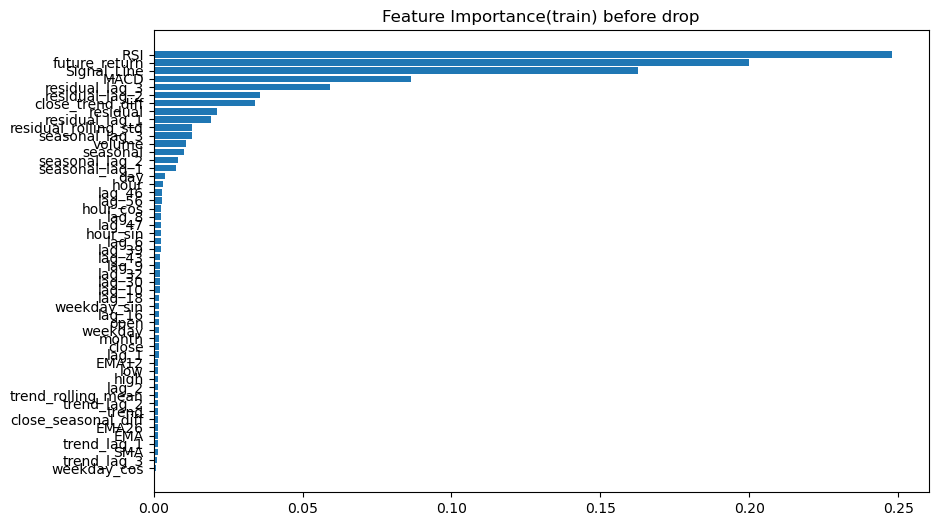

attributes.shape before drop:  (422860, 52)
attributes.shape after the drop:  (422860, 13)


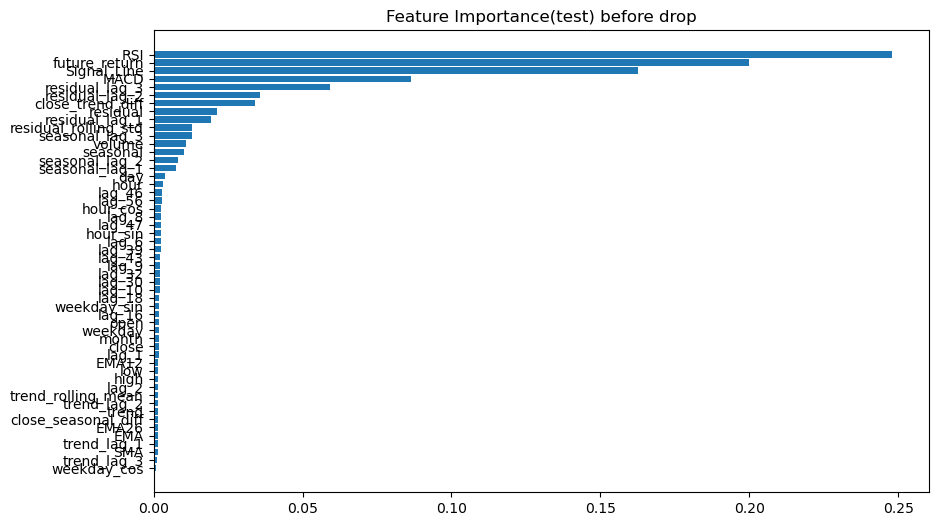

attributes.shape before drop:  (105715, 52)
attributes.shape after the drop:  (105715, 13)
High important features after feature selection (regularization):  Index(['volume', 'seasonal', 'residual', 'residual_lag_1', 'residual_lag_2',
       'seasonal_lag_3', 'residual_lag_3', 'residual_rolling_std',
       'close_trend_diff', 'RSI', 'MACD', 'Signal_Line', 'future_return'],
      dtype='object')


[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    9.6s
[Parallel(n_jobs=9)]: Done 107 out of 107 | elapsed:   26.6s finished
[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.1s
[Parallel(n_jobs=9)]: Done 107 out of 107 | elapsed:    0.5s finished
[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 107 out of 107 | elapsed:    0.0s finished


classification_train_report_RandomForestClassifier_smote:                precision    recall  f1-score   support

           0       1.00      0.97      0.99    420626
           1       0.15      0.95      0.26      1040
           2       0.15      0.97      0.26      1194

    accuracy                           0.97    422860
   macro avg       0.43      0.96      0.50    422860
weighted avg       1.00      0.97      0.98    422860

classification_test_report_RandomForestClassifier_smote:                precision    recall  f1-score   support

           0       1.00      0.97      0.99    105186
           1       0.13      0.81      0.23       265
           2       0.12      0.80      0.21       264

    accuracy                           0.97    105715
   macro avg       0.42      0.86      0.48    105715
weighted avg       0.99      0.97      0.98    105715

F1-Score (Macro): 0.4758


[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.1s
[Parallel(n_jobs=9)]: Done 107 out of 107 | elapsed:    0.4s finished
[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 107 out of 107 | elapsed:    0.0s finished


In [136]:
with mlflow.start_run(run_name = mlflow_run_name):
    mlflow.log_param("train size", len(attributes_train))
    mlflow.log_param("test size", len(attributes_test))

    # Create a Optuna study and optimize
    study = optuna.create_study(direction='maximize')
    study.optimize(
        partial(objective, model_type = model_type, oversampling_type = oversampling_type, n_splits = n_splits),
        n_trials = n_trials
    )

    # Visualize optimization history
    optimization_history_plot = vis.plot_optimization_history(study)
    # Visualize parameter importance
    param_importance_plot = vis.plot_param_importances(study)
    # Visualize hyperparameter values
    hyperparameter_values_plot = vis.plot_parallel_coordinate(study)

    # Save visualizations to files
    optimization_history_plot.write_html(f"data/{model_type}/{oversampling_type}/optimization_history_{model_type}_{oversampling_type}.html")
    param_importance_plot.write_html(f"data/{model_type}/{oversampling_type}/param_importances_{model_type}_{oversampling_type}.html")
    hyperparameter_values_plot.write_html(f"data/{model_type}/{oversampling_type}/hyperparameter_values_{model_type}_{oversampling_type}.html")

    # Log visualization MLflow artifacts
    mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/optimization_history_{model_type}_{oversampling_type}.html")
    mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/param_importances_{model_type}_{oversampling_type}.html")
    mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/hyperparameter_values_{model_type}_{oversampling_type}.html")

    # Output the best hyperparameters
    print("Best Parameters:", study.best_params)
    print("Best F1-macro-score-fine-tuning:", study.best_value)
    print("Best Trial:", study.best_trial)

    # print("\nRecommended hyperparameters for subsequent use:")
    # print("rf_model = RandomForestClassifier(")
    # for param, value in study.best_params.items():
    #     print(f"    {param}={value},")
    #     print("    random_state=42,")
    #     print("    n_jobs=-1")
    #     print(")")

    # mlflow.log_params('class_weight_1', study.best_params['class_weight_1'])
    # mlflow.log_params('class_weight_2', study.best_params['class_weight_2'])
    mlflow.log_metric("best_F1-macro_score_fine_tuning", study.best_value)
    
    # Train best model
    # merged_params = merge_params(initial_forest_model_parameters, study.best_params)
    # # Remove class_weight keys
    merged_params = initial_forest_model_parameters | study.best_params
    del merged_params['class_weight_1']
    del merged_params['class_weight_2']

    print("merged_params:", merged_params)

    mlflow.log_params(merged_params)
    
    # Train the Final Model with Best Parameters
    rf_model = RandomForestClassifier(**merged_params)
    rf_model.fit(attributes_train, target_train)

    # Removing irrelevant features (feature selection)
    attributes_train_reg = remove_low_important_features(rf_model, attributes_train, attributes_type = 'train')
    attributes_test_reg = remove_low_important_features(rf_model, attributes_test, attributes_type = 'test')

    print(f"High important features after feature selection (regularization): ", attributes_train_reg.columns)

    # Train the Final Model with Best Parameters and without the low important featires
    rf_model_reg = RandomForestClassifier(**merged_params)
    rf_model_reg.fit(attributes_train_reg, target_train)

    # Validate
    target_train_pred = rf_model_reg.predict(attributes_train_reg)
    classification_train_report = classification_report(target_train, target_train_pred)

    target_test_pred = rf_model_reg.predict(attributes_test_reg)
    classification_test_report = classification_report(target_test, target_test_pred)
   
    print(f"classification_train_report_{model_type}_{oversampling_type}: ", classification_train_report)
    print(f"classification_test_report_{model_type}_{oversampling_type}: ", classification_test_report)

    # F1-macro score after the regularization
    f1_macro_score = f1_score(target_test, target_test_pred, average='macro')
    print(f"F1-Score (Macro): {f1_macro_score:.4f}")
    
    mlflow.log_metric("F1-macro-score-important-features", f1_macro_score)

    # Log metrics
    mlflow.log_metric(f"train_accuracy_{model_type}_{oversampling_type}", rf_model_reg.score(attributes_train_reg, target_train))
    mlflow.log_metric(f"test_accuracy_{model_type}_{oversampling_type}", rf_model_reg.score(attributes_test_reg, target_test))

    with open(f"data/{model_type}/{oversampling_type}/train_report_{model_type}_{oversampling_type}.txt",  "w") as f:
        f.write(classification_train_report)
    with open(f"data/{model_type}/{oversampling_type}/test_report_{model_type}_{oversampling_type}.txt",  "w") as f:
        f.write(classification_test_report)
        
    pickle.dump(rf_model_reg, open(f"data/{model_type}/{oversampling_type}/model_{model_type}_{oversampling_type}.pkl", "wb"))

    # Log artifacts
    mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/model_{model_type}_{oversampling_type}.pkl")
    mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/train_report_{model_type}_{oversampling_type}.txt")
    mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/test_report_{model_type}_{oversampling_type}.txt")
    
    classes = [0, 1, 2]
    #evaluate_model(rf_model_reg, attributes_test, target_test, classes)

[I 2024-12-01 03:07:46,863] A new study created in memory with name: no-name-d948d10d-c006-4414-a88f-3c761fe23344


Start trial:[0] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    6.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  67 out of  67 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  67 out of  67 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.52      0.68     87639
           1       0.01      0.99      0.02       209
           2       0.01      0.99      0.02       247

    accuracy                           0.52     88095
   macro avg       0.34      0.83      0.24     88095
weighted avg       0.99      0.52      0.68     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:   15.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  67 out of  67 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  67 out of  67 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.56      0.72     87564
           1       0.03      0.98      0.05       248
           2       0.01      1.00      0.02       283

    accuracy                           0.56     88095
   macro avg       0.34      0.85      0.26     88095
weighted avg       0.99      0.56      0.71     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:   25.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  67 out of  67 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  67 out of  67 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.35      0.52     87656
           1       0.01      1.00      0.02       215
           2       0.01      1.00      0.01       224

    accuracy                           0.36     88095
   macro avg       0.34      0.78      0.18     88095
weighted avg       1.00      0.36      0.52     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:   34.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  67 out of  67 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  67 out of  67 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.39      0.56     87620
           1       0.01      1.00      0.02       231
           2       0.01      1.00      0.02       244

    accuracy                           0.39     88095
   macro avg       0.34      0.80      0.20     88095
weighted avg       0.99      0.39      0.55     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:   45.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  67 out of  67 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  67 out of  67 | elapsed:    0.0s finished
[I 2024-12-01 03:10:08,637] Trial 0 finished with value: 0.2166483878302105 and parameters: {'n_estimators': 67, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 5, 'class_weight_1': 85, 'class_weight_2': 52}. Best is trial 0 with value: 0.2166483878302105.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.39      0.56     87649
           1       0.01      1.00      0.02       225
           2       0.01      1.00      0.02       221

    accuracy                           0.40     88095
   macro avg       0.34      0.80      0.20     88095
weighted avg       0.99      0.40      0.56     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.2166 ± 0.0297
F1-Score (Weighted): 0.6048 ± 0.0761
Balanced Accuracy: 0.8109 ± 0.0238
Cohen's Kappa: 0.0114 ± 0.0036
Log Loss: 1.3336 ± 0.2337
ROC-AUC: 0.9506 ± 0.0084
Start trial:[1] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:   27.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     87639
           1       0.03      0.89      0.06       209
           2       0.04      0.84      0.07       247

    accuracy                           0.87     88095
   macro avg       0.36      0.87      0.35     88095
weighted avg       0.99      0.87      0.92     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:   58.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     87564
           1       0.05      0.14      0.07       248
           2       0.04      0.81      0.07       283

    accuracy                           0.93     88095
   macro avg       0.36      0.62      0.37     88095
weighted avg       0.99      0.93      0.96     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:  1.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      1.00      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:  2.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     87620
           1       0.03      1.00      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.82     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.82      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:  2.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished
[I 2024-12-01 03:18:31,520] Trial 1 finished with value: 0.34873088124579055 and parameters: {'n_estimators': 128, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 4, 'class_weight_1': 30, 'class_weight_2': 47}. Best is trial 1 with value: 0.34873088124579055.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3487 ± 0.0109
F1-Score (Weighted): 0.9182 ± 0.0207
Balanced Accuracy: 0.8626 ± 0.1221
Cohen's Kappa: 0.0547 ± 0.0062
Log Loss: 0.6106 ± 0.2204
ROC-AUC: 0.9566 ± 0.0081
Start trial:[2] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 153 out of 153 | elapsed:   15.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 153 out of 153 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 153 out of 153 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.16      0.28     87639
           1       0.01      1.00      0.01       209
           2       0.01      1.00      0.01       247

    accuracy                           0.17     88095
   macro avg       0.34      0.72      0.10     88095
weighted avg       0.99      0.17      0.28     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 153 out of 153 | elapsed:   32.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 153 out of 153 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 153 out of 153 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.03      0.07     87564
           1       0.01      1.00      0.02       248
           2       0.00      1.00      0.01       283

    accuracy                           0.04     88095
   macro avg       0.34      0.68      0.03     88095
weighted avg       0.99      0.04      0.07     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 153 out of 153 | elapsed:   51.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 153 out of 153 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 153 out of 153 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.00      0.01     87656
           1       0.01      1.00      0.01       215
           2       0.00      1.00      0.01       224

    accuracy                           0.01     88095
   macro avg       0.34      0.67      0.01     88095
weighted avg       1.00      0.01      0.01     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 153 out of 153 | elapsed:  1.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 153 out of 153 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 153 out of 153 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.01      0.02     87620
           1       0.01      1.00      0.01       231
           2       0.01      1.00      0.01       244

    accuracy                           0.02     88095
   macro avg       0.34      0.67      0.01     88095
weighted avg       0.99      0.02      0.02     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 153 out of 153 | elapsed:  1.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 153 out of 153 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 153 out of 153 | elapsed:    0.0s finished
[I 2024-12-01 03:23:08,443] Trial 2 finished with value: 0.03391363995530675 and parameters: {'n_estimators': 153, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 6, 'class_weight_1': 83, 'class_weight_2': 34}. Best is trial 1 with value: 0.34873088124579055.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.01      0.02     87649
           1       0.01      1.00      0.01       225
           2       0.00      1.00      0.01       221

    accuracy                           0.01     88095
   macro avg       0.34      0.67      0.01     88095
weighted avg       0.99      0.01      0.02     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.0339 ± 0.0345
F1-Score (Weighted): 0.0782 ± 0.1015
Balanced Accuracy: 0.6808 ± 0.0194
Cohen's Kappa: 0.0032 ± 0.0007
Log Loss: 1.7784 ± 0.2130
ROC-AUC: 0.9508 ± 0.0044
Start trial:[3] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:    7.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  66 out of  66 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  66 out of  66 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.28      0.43     87639
           1       0.01      1.00      0.02       209
           2       0.01      0.99      0.01       247

    accuracy                           0.28     88095
   macro avg       0.34      0.75      0.15     88095
weighted avg       0.99      0.28      0.43     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:   14.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  66 out of  66 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  66 out of  66 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.11      0.19     87564
           1       0.01      1.00      0.02       248
           2       0.01      1.00      0.01       283

    accuracy                           0.11     88095
   macro avg       0.34      0.70      0.07     88095
weighted avg       0.99      0.11      0.19     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:   22.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  66 out of  66 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  66 out of  66 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.05      0.09     87656
           1       0.01      1.00      0.01       215
           2       0.00      1.00      0.01       224

    accuracy                           0.05     88095
   macro avg       0.34      0.68      0.04     88095
weighted avg       1.00      0.05      0.09     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:   30.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  66 out of  66 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  66 out of  66 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.10      0.18     87620
           1       0.01      1.00      0.01       231
           2       0.01      1.00      0.01       244

    accuracy                           0.10     88095
   macro avg       0.34      0.70      0.07     88095
weighted avg       0.99      0.10      0.17     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:   39.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  66 out of  66 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  66 out of  66 | elapsed:    0.0s finished
[I 2024-12-01 03:25:17,853] Trial 3 finished with value: 0.07905762659707702 and parameters: {'n_estimators': 66, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 3, 'class_weight_1': 85, 'class_weight_2': 45}. Best is trial 1 with value: 0.34873088124579055.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.09      0.16     87649
           1       0.01      1.00      0.01       225
           2       0.00      1.00      0.01       221

    accuracy                           0.09     88095
   macro avg       0.34      0.70      0.06     88095
weighted avg       0.99      0.09      0.16     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.0791 ± 0.0392
F1-Score (Weighted): 0.2105 ± 0.1149
Balanced Accuracy: 0.7067 ± 0.0246
Cohen's Kappa: 0.0042 ± 0.0012
Log Loss: 1.7520 ± 0.2183
ROC-AUC: 0.9492 ± 0.0076
Start trial:[4] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 133 out of 133 | elapsed:   13.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 133 out of 133 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 133 out of 133 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.17      0.29     87639
           1       0.01      1.00      0.01       209
           2       0.01      1.00      0.01       247

    accuracy                           0.17     88095
   macro avg       0.34      0.72      0.10     88095
weighted avg       0.99      0.17      0.29     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 133 out of 133 | elapsed:   28.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 133 out of 133 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 133 out of 133 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.05      0.10     87564
           1       0.01      1.00      0.02       248
           2       0.00      1.00      0.01       283

    accuracy                           0.06     88095
   macro avg       0.34      0.68      0.04     88095
weighted avg       0.99      0.06      0.10     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 133 out of 133 | elapsed:   45.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 133 out of 133 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 133 out of 133 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     87656
           1       0.01      1.00      0.01       215
           2       0.00      1.00      0.01       224

    accuracy                           0.01     88095
   macro avg       0.34      0.67      0.01     88095
weighted avg       1.00      0.01      0.00     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 133 out of 133 | elapsed:  1.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 133 out of 133 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 133 out of 133 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     87620
           1       0.01      1.00      0.01       231
           2       0.00      1.00      0.01       244

    accuracy                           0.01     88095
   macro avg       0.34      0.67      0.01     88095
weighted avg       0.99      0.01      0.00     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 133 out of 133 | elapsed:  1.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 133 out of 133 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 133 out of 133 | elapsed:    0.1s finished
[I 2024-12-01 03:29:28,253] Trial 4 finished with value: 0.03403762792089321 and parameters: {'n_estimators': 133, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 3, 'class_weight_1': 87, 'class_weight_2': 81}. Best is trial 1 with value: 0.34873088124579055.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     87649
           1       0.01      1.00      0.01       225
           2       0.00      1.00      0.01       221

    accuracy                           0.01     88095
   macro avg       0.34      0.67      0.01     88095
weighted avg       0.99      0.01      0.00     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.0340 ± 0.0377
F1-Score (Weighted): 0.0784 ± 0.1107
Balanced Accuracy: 0.6813 ± 0.0210
Cohen's Kappa: 0.0032 ± 0.0008
Log Loss: 1.8811 ± 0.2832
ROC-AUC: 0.9504 ± 0.0052
Start trial:[5] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   11.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  54 out of  54 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  54 out of  54 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.80      0.89     87639
           1       0.03      0.97      0.05       209
           2       0.02      0.96      0.05       247

    accuracy                           0.81     88095
   macro avg       0.35      0.91      0.33     88095
weighted avg       0.99      0.81      0.89     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   25.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  54 out of  54 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  54 out of  54 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.90     87564
           1       0.03      0.94      0.07       248
           2       0.03      0.93      0.06       283

    accuracy                           0.83     88095
   macro avg       0.35      0.90      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   38.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  54 out of  54 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  54 out of  54 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.74      0.85     87656
           1       0.02      1.00      0.05       215
           2       0.02      1.00      0.03       224

    accuracy                           0.74     88095
   macro avg       0.35      0.91      0.31     88095
weighted avg       1.00      0.74      0.85     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   51.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  54 out of  54 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  54 out of  54 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.75      0.86     87620
           1       0.02      1.00      0.04       231
           2       0.02      0.99      0.04       244

    accuracy                           0.75     88095
   macro avg       0.35      0.91      0.31     88095
weighted avg       0.99      0.75      0.85     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  1.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  54 out of  54 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  54 out of  54 | elapsed:    0.0s finished
[I 2024-12-01 03:32:52,819] Trial 5 finished with value: 0.321370061773235 and parameters: {'n_estimators': 54, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 8, 'class_weight_1': 45, 'class_weight_2': 87}. Best is trial 1 with value: 0.34873088124579055.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.74      0.85     87649
           1       0.02      0.98      0.03       225
           2       0.02      1.00      0.05       221

    accuracy                           0.74     88095
   macro avg       0.35      0.91      0.31     88095
weighted avg       0.99      0.74      0.85     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3214 ± 0.0129
F1-Score (Weighted): 0.8674 ± 0.0218
Balanced Accuracy: 0.9094 ± 0.0058
Cohen's Kappa: 0.0378 ± 0.0086
Log Loss: 0.9035 ± 0.2752
ROC-AUC: 0.9530 ± 0.0073
Start trial:[6] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:   32.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 169 out of 169 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 169 out of 169 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     87639
           1       0.02      0.97      0.05       209
           2       0.03      0.96      0.06       247

    accuracy                           0.82     88095
   macro avg       0.35      0.91      0.34     88095
weighted avg       0.99      0.82      0.90     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:  1.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 169 out of 169 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 169 out of 169 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87564
           1       0.04      0.88      0.07       248
           2       0.03      0.97      0.06       283

    accuracy                           0.83     88095
   macro avg       0.36      0.89      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:  1.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 169 out of 169 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 169 out of 169 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.72      0.84     87656
           1       0.02      1.00      0.03       215
           2       0.02      1.00      0.04       224

    accuracy                           0.72     88095
   macro avg       0.35      0.91      0.30     88095
weighted avg       1.00      0.72      0.83     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:  2.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 169 out of 169 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 169 out of 169 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.72      0.84     87620
           1       0.02      1.00      0.04       231
           2       0.02      1.00      0.04       244

    accuracy                           0.72     88095
   macro avg       0.35      0.91      0.30     88095
weighted avg       0.99      0.72      0.83     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:  3.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 169 out of 169 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 169 out of 169 | elapsed:    0.0s finished
[I 2024-12-01 03:42:04,673] Trial 6 finished with value: 0.3206693290207482 and parameters: {'n_estimators': 169, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 8, 'class_weight_1': 44, 'class_weight_2': 47}. Best is trial 1 with value: 0.34873088124579055.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.76      0.86     87649
           1       0.02      0.99      0.04       225
           2       0.02      1.00      0.05       221

    accuracy                           0.76     88095
   macro avg       0.35      0.91      0.31     88095
weighted avg       0.99      0.76      0.86     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3207 ± 0.0170
F1-Score (Weighted): 0.8657 ± 0.0297
Balanced Accuracy: 0.9069 ± 0.0080
Cohen's Kappa: 0.0381 ± 0.0103
Log Loss: 0.8737 ± 0.2490
ROC-AUC: 0.9555 ± 0.0064
Start trial:[7] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 281 out of 281 | elapsed:  1.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 281 out of 281 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 281 out of 281 | elapsed:    0.3s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     87639
           1       0.03      0.80      0.07       209
           2       0.03      0.50      0.06       247

    accuracy                           0.90     88095
   macro avg       0.36      0.74      0.36     88095
weighted avg       0.99      0.90      0.94     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 281 out of 281 | elapsed:  5.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 281 out of 281 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 281 out of 281 | elapsed:    0.2s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     87564
           1       0.05      0.12      0.07       248
           2       0.03      0.12      0.05       283

    accuracy                           0.98     88095
   macro avg       0.36      0.41      0.37     88095
weighted avg       0.99      0.98      0.98     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 281 out of 281 | elapsed:  3.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 281 out of 281 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 281 out of 281 | elapsed:    0.1s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 281 out of 281 | elapsed:  5.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 281 out of 281 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 281 out of 281 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 281 out of 281 | elapsed:  7.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 281 out of 281 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 281 out of 281 | elapsed:    0.1s finished
[I 2024-12-01 04:05:13,763] Trial 7 finished with value: 0.3515930908705968 and parameters: {'n_estimators': 281, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_

Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3516 ± 0.0110
F1-Score (Weighted): 0.9295 ± 0.0305
Balanced Accuracy: 0.7927 ± 0.2079
Cohen's Kappa: 0.0531 ± 0.0022
Log Loss: 0.5187 ± 0.2208
ROC-AUC: 0.9526 ± 0.0144
Start trial:[8] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:    9.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  76 out of  76 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  76 out of  76 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.49      0.66     87639
           1       0.01      0.99      0.02       209
           2       0.01      0.99      0.02       247

    accuracy                           0.49     88095
   macro avg       0.34      0.82      0.23     88095
weighted avg       0.99      0.49      0.65     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:   19.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  76 out of  76 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  76 out of  76 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.51      0.67     87564
           1       0.02      0.99      0.05       248
           2       0.01      1.00      0.02       283

    accuracy                           0.51     88095
   macro avg       0.34      0.83      0.25     88095
weighted avg       0.99      0.51      0.67     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:   30.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  76 out of  76 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  76 out of  76 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.32      0.49     87656
           1       0.01      1.00      0.02       215
           2       0.01      1.00      0.01       224

    accuracy                           0.33     88095
   macro avg       0.34      0.77      0.17     88095
weighted avg       1.00      0.33      0.49     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:   41.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  76 out of  76 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  76 out of  76 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.38      0.55     87620
           1       0.01      1.00      0.02       231
           2       0.01      1.00      0.02       244

    accuracy                           0.38     88095
   macro avg       0.34      0.79      0.19     88095
weighted avg       0.99      0.38      0.54     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:   53.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  76 out of  76 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  76 out of  76 | elapsed:    0.0s finished
[I 2024-12-01 04:08:01,779] Trial 8 finished with value: 0.20762691199629182 and parameters: {'n_estimators': 76, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 8, 'class_weight_1': 81, 'class_weight_2': 59}. Best is trial 7 with value: 0.3515930908705968.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.38      0.55     87649
           1       0.01      1.00      0.02       225
           2       0.01      1.00      0.01       221

    accuracy                           0.38     88095
   macro avg       0.34      0.79      0.19     88095
weighted avg       0.99      0.38      0.55     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.2076 ± 0.0272
F1-Score (Weighted): 0.5795 ± 0.0701
Balanced Accuracy: 0.8023 ± 0.0213
Cohen's Kappa: 0.0104 ± 0.0028
Log Loss: 1.3644 ± 0.2250
ROC-AUC: 0.9506 ± 0.0082
Start trial:[9] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:   20.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 145 out of 145 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 145 out of 145 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.66      0.79     87639
           1       0.01      0.98      0.02       209
           2       0.02      0.98      0.03       247

    accuracy                           0.66     88095
   macro avg       0.34      0.87      0.28     88095
weighted avg       0.99      0.66      0.79     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:   44.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 145 out of 145 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 145 out of 145 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.78      0.88     87564
           1       0.03      0.97      0.05       248
           2       0.02      0.99      0.05       283

    accuracy                           0.78     88095
   macro avg       0.35      0.91      0.33     88095
weighted avg       0.99      0.78      0.87     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:  1.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 145 out of 145 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 145 out of 145 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.43      0.60     87656
           1       0.01      1.00      0.02       215
           2       0.01      1.00      0.02       224

    accuracy                           0.43     88095
   macro avg       0.34      0.81      0.21     88095
weighted avg       1.00      0.43      0.59     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:  1.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 145 out of 145 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 145 out of 145 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.43      0.60     87620
           1       0.01      1.00      0.02       231
           2       0.01      1.00      0.02       244

    accuracy                           0.43     88095
   macro avg       0.34      0.81      0.21     88095
weighted avg       0.99      0.43      0.60     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:  2.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 145 out of 145 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 145 out of 145 | elapsed:    0.0s finished
[I 2024-12-01 04:14:10,900] Trial 9 finished with value: 0.2498598583394414 and parameters: {'n_estimators': 145, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 5, 'class_weight_1': 50, 'class_weight_2': 94}. Best is trial 7 with value: 0.3515930908705968.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.44      0.61     87649
           1       0.01      0.99      0.02       225
           2       0.01      1.00      0.02       221

    accuracy                           0.44     88095
   macro avg       0.34      0.81      0.22     88095
weighted avg       0.99      0.44      0.61     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.2499 ± 0.0471
F1-Score (Weighted): 0.6923 ± 0.1158
Balanced Accuracy: 0.8423 ± 0.0426
Cohen's Kappa: 0.0190 ± 0.0125
Log Loss: 1.1245 ± 0.2972
ROC-AUC: 0.9533 ± 0.0060
Start trial:[10] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 289 out of 289 | elapsed:  1.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 289 out of 289 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 289 out of 289 | elapsed:    0.1s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     87639
           1       0.03      0.82      0.06       209
           2       0.03      0.48      0.06       247

    accuracy                           0.90     88095
   macro avg       0.36      0.74      0.36     88095
weighted avg       0.99      0.90      0.94     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 289 out of 289 | elapsed:  2.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 289 out of 289 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 289 out of 289 | elapsed:    0.1s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     87564
           1       0.05      0.12      0.07       248
           2       0.03      0.07      0.04       283

    accuracy                           0.98     88095
   macro avg       0.36      0.39      0.37     88095
weighted avg       0.99      0.98      0.98     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 289 out of 289 | elapsed:  4.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 289 out of 289 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 289 out of 289 | elapsed:    0.1s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 289 out of 289 | elapsed:  5.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 289 out of 289 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 289 out of 289 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 289 out of 289 | elapsed:  7.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 289 out of 289 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 289 out of 289 | elapsed:    0.2s finished


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3509 ± 0.0103
F1-Score (Weighted): 0.9296 ± 0.0313
Balanced Accuracy: 0.7898 ± 0.2134
Cohen's Kappa: 0.0523 ± 0.0027
Log Loss: 0.5241 ± 0.2233
ROC-AUC: 0.9536 ± 0.0130


[I 2024-12-01 04:35:24,154] Trial 10 finished with value: 0.35093955002742927 and parameters: {'n_estimators': 289, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 6, 'class_weight_1': 67, 'class_weight_2': 74}. Best is trial 7 with value: 0.3515930908705968.


Start trial:[11] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:    0.1s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     87639
           1       0.03      0.82      0.06       209
           2       0.03      0.47      0.06       247

    accuracy                           0.90     88095
   macro avg       0.36      0.73      0.36     88095
weighted avg       0.99      0.90      0.94     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:    0.1s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     87564
           1       0.05      0.12      0.07       248
           2       0.03      0.08      0.05       283

    accuracy                           0.98     88095
   macro avg       0.36      0.40      0.37     88095
weighted avg       0.99      0.98      0.98     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:    0.1s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:    0.2s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:    0.1s finished
[I 2024-12-01 04:57:24,392] Trial 11 finished with value: 0.3512168413394346 and parameters: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 10, 'min_samples

Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3512 ± 0.0106
F1-Score (Weighted): 0.9297 ± 0.0312
Balanced Accuracy: 0.7897 ± 0.2127
Cohen's Kappa: 0.0527 ± 0.0021
Log Loss: 0.5203 ± 0.2208
ROC-AUC: 0.9538 ± 0.0131
Start trial:[12] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 294 out of 294 | elapsed:  1.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 294 out of 294 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 294 out of 294 | elapsed:    0.1s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     87639
           1       0.03      0.81      0.06       209
           2       0.04      0.53      0.07       247

    accuracy                           0.90     88095
   macro avg       0.36      0.75      0.36     88095
weighted avg       0.99      0.90      0.94     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 294 out of 294 | elapsed:  2.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 294 out of 294 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 294 out of 294 | elapsed:    0.1s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     87564
           1       0.05      0.12      0.07       248
           2       0.05      0.18      0.07       283

    accuracy                           0.98     88095
   macro avg       0.36      0.43      0.38     88095
weighted avg       0.99      0.98      0.98     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 294 out of 294 | elapsed:  4.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 294 out of 294 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 294 out of 294 | elapsed:    0.1s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 294 out of 294 | elapsed:  5.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 294 out of 294 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 294 out of 294 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 294 out of 294 | elapsed:  7.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 294 out of 294 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 294 out of 294 | elapsed:    0.1s finished
[I 2024-12-01 05:18:56,950] Trial 12 finished with value: 0.3532538259853801 and parameters: {'n_estimators': 294, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_

Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3533 ± 0.0137
F1-Score (Weighted): 0.9292 ± 0.0304
Balanced Accuracy: 0.7999 ± 0.1996
Cohen's Kappa: 0.0561 ± 0.0055
Log Loss: 0.5258 ± 0.2167
ROC-AUC: 0.9532 ± 0.0137
Start trial:[13] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   50.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 240 out of 240 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 240 out of 240 | elapsed:    0.1s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.86      0.93     87639
           1       0.03      0.89      0.06       209
           2       0.03      0.87      0.07       247

    accuracy                           0.86     88095
   macro avg       0.35      0.87      0.35     88095
weighted avg       0.99      0.86      0.92     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 240 out of 240 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 240 out of 240 | elapsed:    0.1s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     87564
           1       0.04      0.13      0.07       248
           2       0.04      0.83      0.07       283

    accuracy                           0.92     88095
   macro avg       0.36      0.63      0.37     88095
weighted avg       0.99      0.92      0.95     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  2.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 240 out of 240 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 240 out of 240 | elapsed:    0.1s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.83      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  3.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 240 out of 240 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 240 out of 240 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     87620
           1       0.03      1.00      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.82     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.82      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  5.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 240 out of 240 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 240 out of 240 | elapsed:    0.1s finished
[I 2024-12-01 05:33:44,930] Trial 13 finished with value: 0.34730997802945673 and parameters: {'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_

Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.83      0.90     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3473 ± 0.0100
F1-Score (Weighted): 0.9165 ± 0.0202
Balanced Accuracy: 0.8634 ± 0.1207
Cohen's Kappa: 0.0536 ± 0.0054
Log Loss: 0.6653 ± 0.2491
ROC-AUC: 0.9553 ± 0.0101
Start trial:[14] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 239 out of 239 | elapsed:   56.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 239 out of 239 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 239 out of 239 | elapsed:    0.1s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     87639
           1       0.03      0.85      0.06       209
           2       0.04      0.71      0.07       247

    accuracy                           0.88     88095
   macro avg       0.36      0.81      0.36     88095
weighted avg       0.99      0.88      0.93     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 239 out of 239 | elapsed:  2.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 239 out of 239 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 239 out of 239 | elapsed:    0.1s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     87564
           1       0.05      0.13      0.07       248
           2       0.04      0.45      0.08       283

    accuracy                           0.96     88095
   macro avg       0.36      0.51      0.38     88095
weighted avg       0.99      0.96      0.97     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 239 out of 239 | elapsed:  3.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 239 out of 239 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 239 out of 239 | elapsed:    0.1s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 239 out of 239 | elapsed:  4.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 239 out of 239 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 239 out of 239 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.93      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 239 out of 239 | elapsed:  5.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 239 out of 239 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 239 out of 239 | elapsed:    0.1s finished
[I 2024-12-01 05:49:53,993] Trial 14 finished with value: 0.3513165783703672 and parameters: {'n_estimators': 239, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_l

Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3513 ± 0.0137
F1-Score (Weighted): 0.9239 ± 0.0271
Balanced Accuracy: 0.8294 ± 0.1648
Cohen's Kappa: 0.0562 ± 0.0080
Log Loss: 0.6027 ± 0.2536
ROC-AUC: 0.9549 ± 0.0114
Start trial:[15] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   53.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 250 out of 250 | elapsed:    0.1s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     87639
           1       0.03      0.90      0.06       209
           2       0.03      0.83      0.07       247

    accuracy                           0.87     88095
   macro avg       0.35      0.87      0.35     88095
weighted avg       0.99      0.87      0.92     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 250 out of 250 | elapsed:    0.1s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     87564
           1       0.05      0.14      0.07       248
           2       0.04      0.81      0.07       283

    accuracy                           0.92     88095
   macro avg       0.36      0.62      0.37     88095
weighted avg       0.99      0.92      0.96     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 250 out of 250 | elapsed:    0.1s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.83      0.90     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  4.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 250 out of 250 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     87620
           1       0.03      1.00      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.82     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.82      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  5.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 250 out of 250 | elapsed:    0.1s finished
[I 2024-12-01 06:04:55,508] Trial 15 finished with value: 0.3480230151693069 and parameters: {'n_estimators': 250, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_l

Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.83      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3480 ± 0.0107
F1-Score (Weighted): 0.9174 ± 0.0207
Balanced Accuracy: 0.8619 ± 0.1221
Cohen's Kappa: 0.0541 ± 0.0059
Log Loss: 0.6515 ± 0.2433
ROC-AUC: 0.9560 ± 0.0092
Start trial:[16] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 267 out of 267 | elapsed:  1.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 267 out of 267 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 267 out of 267 | elapsed:    0.1s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     87639
           1       0.03      0.85      0.06       209
           2       0.04      0.76      0.07       247

    accuracy                           0.88     88095
   macro avg       0.36      0.83      0.36     88095
weighted avg       0.99      0.88      0.93     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 267 out of 267 | elapsed:  2.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 267 out of 267 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 267 out of 267 | elapsed:    0.1s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     87564
           1       0.05      0.13      0.07       248
           2       0.04      0.43      0.08       283

    accuracy                           0.96     88095
   macro avg       0.36      0.51      0.38     88095
weighted avg       0.99      0.96      0.97     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 267 out of 267 | elapsed:  3.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 267 out of 267 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 267 out of 267 | elapsed:    0.1s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 267 out of 267 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 267 out of 267 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 267 out of 267 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.90     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 267 out of 267 | elapsed:  6.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 267 out of 267 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 267 out of 267 | elapsed:    0.1s finished
[I 2024-12-01 06:22:56,579] Trial 16 finished with value: 0.35166556678961824 and parameters: {'n_estimators': 267, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_

Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3517 ± 0.0132
F1-Score (Weighted): 0.9244 ± 0.0267
Balanced Accuracy: 0.8307 ± 0.1678
Cohen's Kappa: 0.0564 ± 0.0072
Log Loss: 0.5597 ± 0.2184
ROC-AUC: 0.9554 ± 0.0115
Start trial:[17] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 202 out of 202 | elapsed:   47.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 202 out of 202 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 202 out of 202 | elapsed:    0.1s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     87639
           1       0.03      0.85      0.06       209
           2       0.04      0.79      0.07       247

    accuracy                           0.88     88095
   macro avg       0.36      0.84      0.36     88095
weighted avg       0.99      0.88      0.93     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 202 out of 202 | elapsed:  1.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 202 out of 202 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 202 out of 202 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     87564
           1       0.05      0.13      0.07       248
           2       0.04      0.24      0.07       283

    accuracy                           0.97     88095
   macro avg       0.36      0.45      0.37     88095
weighted avg       0.99      0.97      0.98     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 202 out of 202 | elapsed:  2.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 202 out of 202 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 202 out of 202 | elapsed:    0.1s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 202 out of 202 | elapsed:  3.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 202 out of 202 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 202 out of 202 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 202 out of 202 | elapsed:  4.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 202 out of 202 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 202 out of 202 | elapsed:    0.1s finished
[I 2024-12-01 06:36:43,859] Trial 17 finished with value: 0.3512317895717697 and parameters: {'n_estimators': 202, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_l

Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3512 ± 0.0125
F1-Score (Weighted): 0.9252 ± 0.0285
Balanced Accuracy: 0.8218 ± 0.1900
Cohen's Kappa: 0.0547 ± 0.0042
Log Loss: 0.5654 ± 0.2261
ROC-AUC: 0.9539 ± 0.0131
Start trial:[18] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 264 out of 264 | elapsed:   50.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 264 out of 264 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 264 out of 264 | elapsed:    0.1s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     87639
           1       0.03      0.92      0.06       209
           2       0.03      0.88      0.07       247

    accuracy                           0.86     88095
   macro avg       0.35      0.89      0.35     88095
weighted avg       0.99      0.86      0.92     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 264 out of 264 | elapsed:  1.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 264 out of 264 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 264 out of 264 | elapsed:    0.1s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     87564
           1       0.05      0.32      0.09       248
           2       0.04      0.88      0.07       283

    accuracy                           0.91     88095
   macro avg       0.36      0.70      0.37     88095
weighted avg       0.99      0.91      0.95     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 264 out of 264 | elapsed:  2.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 264 out of 264 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 264 out of 264 | elapsed:    0.1s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.80      0.89     87656
           1       0.02      1.00      0.05       215
           2       0.03      1.00      0.05       224

    accuracy                           0.80     88095
   macro avg       0.35      0.93      0.33     88095
weighted avg       1.00      0.80      0.89     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 264 out of 264 | elapsed:  3.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 264 out of 264 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 264 out of 264 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.80      0.89     87620
           1       0.03      1.00      0.05       231
           2       0.03      0.99      0.05       244

    accuracy                           0.80     88095
   macro avg       0.35      0.93      0.33     88095
weighted avg       0.99      0.80      0.88     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 264 out of 264 | elapsed:  4.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 264 out of 264 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 264 out of 264 | elapsed:    0.1s finished
[I 2024-12-01 06:51:15,010] Trial 18 finished with value: 0.3409476106920878 and parameters: {'n_estimators': 264, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_l

Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.79      0.88     87649
           1       0.02      0.98      0.04       225
           2       0.03      1.00      0.05       221

    accuracy                           0.79     88095
   macro avg       0.35      0.93      0.33     88095
weighted avg       1.00      0.79      0.88     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3409 ± 0.0168
F1-Score (Weighted): 0.9030 ± 0.0248
Balanced Accuracy: 0.8761 ± 0.0874
Cohen's Kappa: 0.0488 ± 0.0098
Log Loss: 0.7899 ± 0.2837
ROC-AUC: 0.9550 ± 0.0084
Start trial:[19] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 207 out of 207 | elapsed:   48.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 207 out of 207 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 207 out of 207 | elapsed:    0.1s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     87639
           1       0.03      0.84      0.06       209
           2       0.04      0.77      0.07       247

    accuracy                           0.88     88095
   macro avg       0.36      0.83      0.36     88095
weighted avg       0.99      0.88      0.93     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 207 out of 207 | elapsed:  1.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 207 out of 207 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 207 out of 207 | elapsed:    0.1s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     87564
           1       0.05      0.13      0.07       248
           2       0.05      0.52      0.09       283

    accuracy                           0.95     88095
   macro avg       0.36      0.53      0.38     88095
weighted avg       0.99      0.95      0.97     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 207 out of 207 | elapsed:  2.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 207 out of 207 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 207 out of 207 | elapsed:    0.1s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 207 out of 207 | elapsed:  3.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 207 out of 207 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 207 out of 207 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.90     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 207 out of 207 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 207 out of 207 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 207 out of 207 | elapsed:    0.1s finished
[I 2024-12-01 07:05:21,037] Trial 19 finished with value: 0.351910368399568 and parameters: {'n_estimators': 207, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_le

Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3519 ± 0.0136
F1-Score (Weighted): 0.9240 ± 0.0260
Balanced Accuracy: 0.8371 ± 0.1571
Cohen's Kappa: 0.0574 ± 0.0090
Log Loss: 0.5691 ± 0.2204
ROC-AUC: 0.9545 ± 0.0131
Start trial:[20] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 211 out of 211 | elapsed:   40.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 211 out of 211 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 211 out of 211 | elapsed:    0.1s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     87639
           1       0.03      0.91      0.06       209
           2       0.03      0.93      0.06       247

    accuracy                           0.85     88095
   macro avg       0.35      0.90      0.35     88095
weighted avg       0.99      0.85      0.91     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 211 out of 211 | elapsed:  1.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 211 out of 211 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 211 out of 211 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     87564
           1       0.04      0.15      0.07       248
           2       0.03      0.93      0.06       283

    accuracy                           0.90     88095
   macro avg       0.36      0.66      0.36     88095
weighted avg       0.99      0.90      0.94     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 211 out of 211 | elapsed:  2.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 211 out of 211 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 211 out of 211 | elapsed:    0.1s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.81      0.90     87656
           1       0.03      1.00      0.05       215
           2       0.02      1.00      0.05       224

    accuracy                           0.81     88095
   macro avg       0.35      0.94      0.33     88095
weighted avg       1.00      0.81      0.89     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 211 out of 211 | elapsed:  3.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 211 out of 211 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 211 out of 211 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.81      0.89     87620
           1       0.03      1.00      0.05       231
           2       0.03      0.99      0.05       244

    accuracy                           0.81     88095
   macro avg       0.35      0.93      0.33     88095
weighted avg       0.99      0.81      0.89     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 211 out of 211 | elapsed:  3.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 211 out of 211 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 211 out of 211 | elapsed:    0.1s finished
[I 2024-12-01 07:16:59,482] Trial 20 finished with value: 0.3410249731403575 and parameters: {'n_estimators': 211, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_l

Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     87649
           1       0.03      1.00      0.06       225
           2       0.03      1.00      0.05       221

    accuracy                           0.82     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.82      0.90     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3410 ± 0.0101
F1-Score (Weighted): 0.9060 ± 0.0194
Balanced Accuracy: 0.8722 ± 0.1075
Cohen's Kappa: 0.0482 ± 0.0043
Log Loss: 0.7796 ± 0.2709
ROC-AUC: 0.9549 ± 0.0096
Start trial:[21] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 211 out of 211 | elapsed:   49.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 211 out of 211 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 211 out of 211 | elapsed:    0.1s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     87639
           1       0.03      0.85      0.06       209
           2       0.04      0.76      0.07       247

    accuracy                           0.88     88095
   macro avg       0.36      0.83      0.36     88095
weighted avg       0.99      0.88      0.93     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 211 out of 211 | elapsed:  1.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 211 out of 211 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 211 out of 211 | elapsed:    0.1s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     87564
           1       0.05      0.13      0.07       248
           2       0.05      0.72      0.09       283

    accuracy                           0.94     88095
   macro avg       0.36      0.60      0.38     88095
weighted avg       0.99      0.94      0.97     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 211 out of 211 | elapsed:  2.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 211 out of 211 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 211 out of 211 | elapsed:    0.1s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 211 out of 211 | elapsed:  3.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 211 out of 211 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 211 out of 211 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 211 out of 211 | elapsed:  4.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 211 out of 211 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 211 out of 211 | elapsed:    0.1s finished
[I 2024-12-01 07:31:23,760] Trial 21 finished with value: 0.3519464861395458 and parameters: {'n_estimators': 211, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_l

Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3519 ± 0.0133
F1-Score (Weighted): 0.9230 ± 0.0236
Balanced Accuracy: 0.8493 ± 0.1325
Cohen's Kappa: 0.0582 ± 0.0103
Log Loss: 0.5629 ± 0.2161
ROC-AUC: 0.9541 ± 0.0128
Start trial:[22] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:   47.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 204 out of 204 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 204 out of 204 | elapsed:    0.1s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     87639
           1       0.03      0.86      0.06       209
           2       0.04      0.74      0.07       247

    accuracy                           0.88     88095
   macro avg       0.36      0.83      0.36     88095
weighted avg       0.99      0.88      0.93     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:  1.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 204 out of 204 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 204 out of 204 | elapsed:    0.1s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     87564
           1       0.05      0.13      0.07       248
           2       0.05      0.33      0.08       283

    accuracy                           0.97     88095
   macro avg       0.36      0.48      0.38     88095
weighted avg       0.99      0.97      0.98     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:  2.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 204 out of 204 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 204 out of 204 | elapsed:    0.1s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:  3.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 204 out of 204 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 204 out of 204 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.90     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:  4.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 204 out of 204 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 204 out of 204 | elapsed:    0.1s finished
[I 2024-12-01 07:45:16,134] Trial 22 finished with value: 0.35199428815929934 and parameters: {'n_estimators': 204, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_

Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3520 ± 0.0140
F1-Score (Weighted): 0.9252 ± 0.0284
Balanced Accuracy: 0.8243 ± 0.1801
Cohen's Kappa: 0.0565 ± 0.0075
Log Loss: 0.5694 ± 0.2298
ROC-AUC: 0.9542 ± 0.0130
Start trial:[23] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:   49.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 191 out of 191 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 191 out of 191 | elapsed:    0.1s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     87639
           1       0.03      0.82      0.06       209
           2       0.04      0.71      0.07       247

    accuracy                           0.89     88095
   macro avg       0.36      0.81      0.36     88095
weighted avg       0.99      0.89      0.94     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:  1.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 191 out of 191 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 191 out of 191 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     87564
           1       0.05      0.12      0.07       248
           2       0.05      0.32      0.09       283

    accuracy                           0.97     88095
   macro avg       0.37      0.47      0.38     88095
weighted avg       0.99      0.97      0.98     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:  2.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 191 out of 191 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 191 out of 191 | elapsed:    0.1s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.92     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.35     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:  3.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 191 out of 191 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 191 out of 191 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 191 out of 191 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 191 out of 191 | elapsed:    0.1s finished
[I 2024-12-01 07:59:25,638] Trial 23 finished with value: 0.35427106244080725 and parameters: {'n_estimators': 191, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 6, 'class_weight_1': 93, 'class_weight_2': 30}. Best is trial 23 with value: 0.35427106244080725.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3543 ± 0.0146
F1-Score (Weighted): 0.9279 ± 0.0281
Balanced Accuracy: 0.8201 ± 0.1814
Cohen's Kappa: 0.0588 ± 0.0092
Log Loss: 0.5017 ± 0.2027
ROC-AUC: 0.9541 ± 0.0137
Start trial:[24] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:   24.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  98 out of  98 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  98 out of  98 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.90      0.94     87639
           1       0.03      0.80      0.06       209
           2       0.04      0.68      0.07       247

    accuracy                           0.89     88095
   macro avg       0.36      0.79      0.36     88095
weighted avg       0.99      0.89      0.94     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:   54.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  98 out of  98 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  98 out of  98 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     87564
           1       0.05      0.12      0.07       248
           2       0.05      0.22      0.08       283

    accuracy                           0.97     88095
   macro avg       0.36      0.44      0.38     88095
weighted avg       0.99      0.97      0.98     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:  1.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  98 out of  98 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  98 out of  98 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:  2.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  98 out of  98 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  98 out of  98 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:  2.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  98 out of  98 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  98 out of  98 | elapsed:    0.0s finished
[I 2024-12-01 08:06:53,392] Trial 24 finished with value: 0.353227599082513 and parameters: {'n_estimators': 98, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 6, 'class_weight_1': 93, 'class_weight_2': 40}. Best is trial 23 with value: 0.35427106244080725.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3532 ± 0.0130
F1-Score (Weighted): 0.9284 ± 0.0291
Balanced Accuracy: 0.8110 ± 0.1939
Cohen's Kappa: 0.0566 ± 0.0054
Log Loss: 0.5271 ± 0.2231
ROC-AUC: 0.9530 ± 0.0149
Start trial:[25] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 109 out of 109 | elapsed:   27.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 109 out of 109 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 109 out of 109 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     87639
           1       0.03      0.81      0.06       209
           2       0.04      0.58      0.07       247

    accuracy                           0.90     88095
   macro avg       0.36      0.77      0.36     88095
weighted avg       0.99      0.90      0.94     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 109 out of 109 | elapsed:  1.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 109 out of 109 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 109 out of 109 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     87564
           1       0.05      0.12      0.07       248
           2       0.03      0.13      0.06       283

    accuracy                           0.98     88095
   macro avg       0.36      0.41      0.37     88095
weighted avg       0.99      0.98      0.98     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 109 out of 109 | elapsed:  1.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 109 out of 109 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 109 out of 109 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 109 out of 109 | elapsed:  2.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 109 out of 109 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 109 out of 109 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 109 out of 109 | elapsed:  2.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 109 out of 109 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 109 out of 109 | elapsed:    0.0s finished
[I 2024-12-01 08:15:08,397] Trial 25 finished with value: 0.35154524309916513 and parameters: {'n_estimators': 109, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 6, 'class_weight_1': 89, 'class_weight_2': 69}. Best is trial 23 with value: 0.35427106244080725.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3515 ± 0.0114
F1-Score (Weighted): 0.9284 ± 0.0302
Balanced Accuracy: 0.7997 ± 0.2047
Cohen's Kappa: 0.0535 ± 0.0025
Log Loss: 0.5468 ± 0.2355
ROC-AUC: 0.9501 ± 0.0182
Start trial:[26] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   24.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  96 out of  96 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  96 out of  96 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     87639
           1       0.03      0.81      0.06       209
           2       0.04      0.71      0.07       247

    accuracy                           0.89     88095
   macro avg       0.36      0.80      0.36     88095
weighted avg       0.99      0.89      0.94     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   53.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  96 out of  96 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  96 out of  96 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     87564
           1       0.05      0.13      0.07       248
           2       0.04      0.19      0.07       283

    accuracy                           0.97     88095
   macro avg       0.36      0.43      0.37     88095
weighted avg       0.99      0.97      0.98     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  1.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  96 out of  96 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  96 out of  96 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.92     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.35     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  1.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  96 out of  96 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  96 out of  96 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  2.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  96 out of  96 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  96 out of  96 | elapsed:    0.0s finished
[I 2024-12-01 08:22:21,744] Trial 26 finished with value: 0.3527143335060169 and parameters: {'n_estimators': 96, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 5, 'class_weight_1': 77, 'class_weight_2': 40}. Best is trial 23 with value: 0.35427106244080725.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3527 ± 0.0123
F1-Score (Weighted): 0.9280 ± 0.0290
Balanced Accuracy: 0.8115 ± 0.1972
Cohen's Kappa: 0.0555 ± 0.0038
Log Loss: 0.5072 ± 0.2067
ROC-AUC: 0.9549 ± 0.0130
Start trial:[27] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 176 out of 176 | elapsed:   37.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 out of 176 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 out of 176 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.86      0.93     87639
           1       0.03      0.89      0.06       209
           2       0.03      0.87      0.07       247

    accuracy                           0.86     88095
   macro avg       0.35      0.87      0.35     88095
weighted avg       0.99      0.86      0.92     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 176 out of 176 | elapsed:  1.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 out of 176 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 out of 176 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     87564
           1       0.05      0.14      0.07       248
           2       0.04      0.83      0.07       283

    accuracy                           0.92     88095
   macro avg       0.36      0.63      0.37     88095
weighted avg       0.99      0.92      0.95     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 176 out of 176 | elapsed:  2.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 out of 176 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 out of 176 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.83      0.90     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 176 out of 176 | elapsed:  2.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 out of 176 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 out of 176 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     87620
           1       0.03      1.00      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.82     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.82      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 176 out of 176 | elapsed:  3.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 out of 176 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 out of 176 | elapsed:    0.0s finished
[I 2024-12-01 08:33:24,147] Trial 27 finished with value: 0.34755227747604805 and parameters: {'n_estimators': 176, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 6, 'class_weight_1': 59, 'class_weight_2': 53}. Best is trial 23 with value: 0.35427106244080725.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3476 ± 0.0107
F1-Score (Weighted): 0.9165 ± 0.0204
Balanced Accuracy: 0.8642 ± 0.1191
Cohen's Kappa: 0.0537 ± 0.0059
Log Loss: 0.6451 ± 0.2390
ROC-AUC: 0.9556 ± 0.0097
Start trial:[28] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:   25.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  99 out of  99 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  99 out of  99 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.90      0.94     87639
           1       0.03      0.81      0.06       209
           2       0.03      0.63      0.07       247

    accuracy                           0.89     88095
   macro avg       0.36      0.78      0.36     88095
weighted avg       0.99      0.89      0.94     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:   54.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  99 out of  99 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  99 out of  99 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     87564
           1       0.05      0.12      0.07       248
           2       0.05      0.36      0.08       283

    accuracy                           0.97     88095
   macro avg       0.36      0.48      0.38     88095
weighted avg       0.99      0.97      0.98     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  99 out of  99 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  99 out of  99 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.92     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  2.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  99 out of  99 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  99 out of  99 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  2.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  99 out of  99 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  99 out of  99 | elapsed:    0.0s finished
[I 2024-12-01 08:40:56,230] Trial 28 finished with value: 0.3530295951694499 and parameters: {'n_estimators': 99, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 4, 'class_weight_1': 91, 'class_weight_2': 44}. Best is trial 23 with value: 0.35427106244080725.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3530 ± 0.0134
F1-Score (Weighted): 0.9274 ± 0.0278
Balanced Accuracy: 0.8158 ± 0.1782
Cohen's Kappa: 0.0572 ± 0.0074
Log Loss: 0.5254 ± 0.2167
ROC-AUC: 0.9530 ± 0.0149
Start trial:[29] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 178 out of 178 | elapsed:   45.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 178 out of 178 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 178 out of 178 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.90      0.94     87639
           1       0.03      0.80      0.06       209
           2       0.04      0.64      0.07       247

    accuracy                           0.89     88095
   macro avg       0.36      0.78      0.36     88095
weighted avg       0.99      0.89      0.94     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 178 out of 178 | elapsed:  1.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 178 out of 178 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 178 out of 178 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     87564
           1       0.05      0.12      0.07       248
           2       0.04      0.13      0.06       283

    accuracy                           0.98     88095
   macro avg       0.36      0.41      0.37     88095
weighted avg       0.99      0.98      0.98     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 178 out of 178 | elapsed:  2.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 178 out of 178 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 178 out of 178 | elapsed:    0.1s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.92     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.85     88095
   macro avg       0.35      0.94      0.35     88095
weighted avg       1.00      0.85      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 178 out of 178 | elapsed:  3.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 178 out of 178 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 178 out of 178 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 178 out of 178 | elapsed:  4.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 178 out of 178 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 178 out of 178 | elapsed:    0.1s finished
[I 2024-12-01 08:54:10,190] Trial 29 finished with value: 0.3527104995462479 and parameters: {'n_estimators': 178, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 5, 'class_weight_1': 81, 'class_weight_2': 30}. Best is trial 23 with value: 0.35427106244080725.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3527 ± 0.0117
F1-Score (Weighted): 0.9293 ± 0.0298
Balanced Accuracy: 0.8028 ± 0.2051
Cohen's Kappa: 0.0550 ± 0.0029
Log Loss: 0.4910 ± 0.2029
ROC-AUC: 0.9547 ± 0.0132
Start trial:[30] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 228 out of 228 | elapsed:   43.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 228 out of 228 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 228 out of 228 | elapsed:    0.1s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     87639
           1       0.03      0.91      0.06       209
           2       0.03      0.92      0.06       247

    accuracy                           0.85     88095
   macro avg       0.35      0.90      0.35     88095
weighted avg       0.99      0.85      0.92     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 228 out of 228 | elapsed:  1.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 228 out of 228 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 228 out of 228 | elapsed:    0.1s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     87564
           1       0.04      0.15      0.07       248
           2       0.03      0.92      0.07       283

    accuracy                           0.90     88095
   macro avg       0.36      0.66      0.36     88095
weighted avg       0.99      0.90      0.94     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 228 out of 228 | elapsed:  2.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 228 out of 228 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 228 out of 228 | elapsed:    0.1s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     87656
           1       0.03      1.00      0.05       215
           2       0.03      1.00      0.05       224

    accuracy                           0.82     88095
   macro avg       0.35      0.94      0.33     88095
weighted avg       1.00      0.82      0.90     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 228 out of 228 | elapsed:  3.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 228 out of 228 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 228 out of 228 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.80      0.89     87620
           1       0.03      1.00      0.06       231
           2       0.02      0.99      0.05       244

    accuracy                           0.80     88095
   macro avg       0.35      0.93      0.33     88095
weighted avg       0.99      0.80      0.88     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 228 out of 228 | elapsed:  4.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 228 out of 228 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 228 out of 228 | elapsed:    0.1s finished
[I 2024-12-01 09:06:42,370] Trial 30 finished with value: 0.3411327985993 and parameters: {'n_estimators': 228, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf

Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.81      0.89     87649
           1       0.03      0.99      0.06       225
           2       0.02      1.00      0.04       221

    accuracy                           0.81     88095
   macro avg       0.35      0.93      0.33     88095
weighted avg       1.00      0.81      0.89     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3411 ± 0.0115
F1-Score (Weighted): 0.9059 ± 0.0219
Balanced Accuracy: 0.8703 ± 0.1073
Cohen's Kappa: 0.0485 ± 0.0058
Log Loss: 0.7632 ± 0.2679
ROC-AUC: 0.9557 ± 0.0085
Start trial:[31] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:   24.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  94 out of  94 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  94 out of  94 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     87639
           1       0.03      0.81      0.06       209
           2       0.03      0.66      0.07       247

    accuracy                           0.89     88095
   macro avg       0.36      0.79      0.36     88095
weighted avg       0.99      0.89      0.94     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:   51.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  94 out of  94 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  94 out of  94 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     87564
           1       0.05      0.12      0.07       248
           2       0.04      0.31      0.08       283

    accuracy                           0.97     88095
   macro avg       0.36      0.47      0.38     88095
weighted avg       0.99      0.97      0.98     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:  1.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  94 out of  94 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  94 out of  94 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.92     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:  1.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  94 out of  94 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  94 out of  94 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:  2.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  94 out of  94 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  94 out of  94 | elapsed:    0.0s finished
[I 2024-12-01 09:13:47,405] Trial 31 finished with value: 0.352613206550371 and parameters: {'n_estimators': 94, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 4, 'class_weight_1': 91, 'class_weight_2': 44}. Best is trial 23 with value: 0.35427106244080725.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3526 ± 0.0127
F1-Score (Weighted): 0.9273 ± 0.0279
Balanced Accuracy: 0.8152 ± 0.1831
Cohen's Kappa: 0.0563 ± 0.0057
Log Loss: 0.5242 ± 0.2147
ROC-AUC: 0.9526 ± 0.0157
Start trial:[32] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:   26.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 114 out of 114 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 114 out of 114 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     87639
           1       0.03      0.85      0.06       209
           2       0.04      0.64      0.07       247

    accuracy                           0.89     88095
   macro avg       0.35      0.79      0.36     88095
weighted avg       0.99      0.89      0.94     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:   57.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 114 out of 114 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 114 out of 114 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     87564
           1       0.05      0.14      0.07       248
           2       0.05      0.75      0.09       283

    accuracy                           0.94     88095
   macro avg       0.36      0.61      0.38     88095
weighted avg       0.99      0.94      0.96     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:  1.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 114 out of 114 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 114 out of 114 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:  2.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 114 out of 114 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 114 out of 114 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:  2.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 114 out of 114 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 114 out of 114 | elapsed:    0.0s finished
[I 2024-12-01 09:21:37,627] Trial 32 finished with value: 0.3521949914942656 and parameters: {'n_estimators': 114, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 4, 'class_weight_1': 31, 'class_weight_2': 41}. Best is trial 23 with value: 0.35427106244080725.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3522 ± 0.0132
F1-Score (Weighted): 0.9236 ± 0.0229
Balanced Accuracy: 0.8448 ± 0.1302
Cohen's Kappa: 0.0577 ± 0.0097
Log Loss: 0.5379 ± 0.1942
ROC-AUC: 0.9553 ± 0.0102
Start trial:[33] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:   21.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  83 out of  83 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  83 out of  83 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     87639
           1       0.03      0.80      0.06       209
           2       0.03      0.73      0.07       247

    accuracy                           0.89     88095
   macro avg       0.36      0.81      0.36     88095
weighted avg       0.99      0.89      0.94     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:   45.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  83 out of  83 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  83 out of  83 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     87564
           1       0.05      0.12      0.07       248
           2       0.05      0.58      0.09       283

    accuracy                           0.95     88095
   macro avg       0.36      0.55      0.38     88095
weighted avg       0.99      0.95      0.97     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:  1.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  83 out of  83 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  83 out of  83 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:  1.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  83 out of  83 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  83 out of  83 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.93      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:  2.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  83 out of  83 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  83 out of  83 | elapsed:    0.0s finished
[I 2024-12-01 09:27:52,912] Trial 33 finished with value: 0.35254702010207734 and parameters: {'n_estimators': 83, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 5, 'class_weight_1': 96, 'class_weight_2': 50}. Best is trial 23 with value: 0.35427106244080725.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3525 ± 0.0132
F1-Score (Weighted): 0.9250 ± 0.0251
Balanced Accuracy: 0.8358 ± 0.1505
Cohen's Kappa: 0.0581 ± 0.0094
Log Loss: 0.5381 ± 0.2212
ROC-AUC: 0.9544 ± 0.0122
Start trial:[34] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 119 out of 119 | elapsed:   25.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 119 out of 119 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 119 out of 119 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     87639
           1       0.03      0.87      0.06       209
           2       0.03      0.89      0.07       247

    accuracy                           0.86     88095
   macro avg       0.35      0.88      0.35     88095
weighted avg       0.99      0.86      0.92     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 119 out of 119 | elapsed:   54.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 119 out of 119 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 119 out of 119 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     87564
           1       0.05      0.14      0.07       248
           2       0.04      0.84      0.07       283

    accuracy                           0.92     88095
   macro avg       0.36      0.63      0.37     88095
weighted avg       0.99      0.92      0.95     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 119 out of 119 | elapsed:  1.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 119 out of 119 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 119 out of 119 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.83      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 119 out of 119 | elapsed:  2.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 119 out of 119 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 119 out of 119 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.82     88095
   macro avg       0.35      0.93      0.34     88095
weighted avg       0.99      0.82      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 119 out of 119 | elapsed:  2.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 119 out of 119 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 119 out of 119 | elapsed:    0.0s finished
[I 2024-12-01 09:35:24,438] Trial 34 finished with value: 0.34730401169999475 and parameters: {'n_estimators': 119, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 3, 'class_weight_1': 87, 'class_weight_2': 36}. Best is trial 23 with value: 0.35427106244080725.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.83      0.90     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3473 ± 0.0101
F1-Score (Weighted): 0.9162 ± 0.0196
Balanced Accuracy: 0.8651 ± 0.1179
Cohen's Kappa: 0.0535 ± 0.0053
Log Loss: 0.6571 ± 0.2390
ROC-AUC: 0.9545 ± 0.0108
Start trial:[35] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 159 out of 159 | elapsed:   40.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 159 out of 159 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 159 out of 159 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.90      0.94     87639
           1       0.03      0.80      0.06       209
           2       0.04      0.63      0.07       247

    accuracy                           0.90     88095
   macro avg       0.36      0.78      0.36     88095
weighted avg       0.99      0.90      0.94     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 159 out of 159 | elapsed:  1.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 159 out of 159 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 159 out of 159 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     87564
           1       0.05      0.12      0.07       248
           2       0.04      0.14      0.06       283

    accuracy                           0.98     88095
   macro avg       0.36      0.41      0.37     88095
weighted avg       0.99      0.98      0.98     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 159 out of 159 | elapsed:  2.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 159 out of 159 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 159 out of 159 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 159 out of 159 | elapsed:  3.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 159 out of 159 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 159 out of 159 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 159 out of 159 | elapsed:  4.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 159 out of 159 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 159 out of 159 | elapsed:    0.0s finished
[I 2024-12-01 09:47:17,221] Trial 35 finished with value: 0.3520148672515019 and parameters: {'n_estimators': 159, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 6, 'class_weight_1': 83, 'class_weight_2': 57}. Best is trial 23 with value: 0.35427106244080725.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3520 ± 0.0120
F1-Score (Weighted): 0.9285 ± 0.0302
Balanced Accuracy: 0.8022 ± 0.2043
Cohen's Kappa: 0.0544 ± 0.0031
Log Loss: 0.5249 ± 0.2209
ROC-AUC: 0.9520 ± 0.0161
Start trial:[36] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:   31.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 134 out of 134 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     87639
           1       0.03      0.85      0.06       209
           2       0.03      0.70      0.07       247

    accuracy                           0.88     88095
   macro avg       0.35      0.81      0.35     88095
weighted avg       0.99      0.88      0.93     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:  1.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 134 out of 134 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     87564
           1       0.05      0.13      0.07       248
           2       0.04      0.23      0.07       283

    accuracy                           0.97     88095
   macro avg       0.36      0.45      0.37     88095
weighted avg       0.99      0.97      0.98     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:  1.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 134 out of 134 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:  2.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 134 out of 134 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.90     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.93      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:  3.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 134 out of 134 | elapsed:    0.0s finished
[I 2024-12-01 09:56:34,120] Trial 36 finished with value: 0.3508992522609618 and parameters: {'n_estimators': 134, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 4, 'class_weight_1': 79, 'class_weight_2': 45}. Best is trial 23 with value: 0.35427106244080725.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3509 ± 0.0127
F1-Score (Weighted): 0.9253 ± 0.0290
Balanced Accuracy: 0.8153 ± 0.1909
Cohen's Kappa: 0.0542 ± 0.0042
Log Loss: 0.5726 ± 0.2352
ROC-AUC: 0.9534 ± 0.0129
Start trial:[37] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   14.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  55 out of  55 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  55 out of  55 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     87639
           1       0.03      0.78      0.06       209
           2       0.03      0.49      0.06       247

    accuracy                           0.90     88095
   macro avg       0.35      0.73      0.36     88095
weighted avg       0.99      0.90      0.94     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   30.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  55 out of  55 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  55 out of  55 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     87564
           1       0.05      0.12      0.07       248
           2       0.03      0.13      0.05       283

    accuracy                           0.97     88095
   macro avg       0.36      0.41      0.37     88095
weighted avg       0.99      0.97      0.98     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   49.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  55 out of  55 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  55 out of  55 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:  1.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  55 out of  55 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  55 out of  55 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:  1.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  55 out of  55 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  55 out of  55 | elapsed:    0.0s finished
[I 2024-12-01 10:00:52,811] Trial 37 finished with value: 0.35098056565432095 and parameters: {'n_estimators': 55, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 3, 'class_weight_1': 86, 'class_weight_2': 70}. Best is trial 23 with value: 0.35427106244080725.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3510 ± 0.0104
F1-Score (Weighted): 0.9290 ± 0.0302
Balanced Accuracy: 0.7915 ± 0.2076
Cohen's Kappa: 0.0522 ± 0.0021
Log Loss: 0.5445 ± 0.2385
ROC-AUC: 0.9509 ± 0.0177
Start trial:[38] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   13.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  96 out of  96 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  96 out of  96 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.69      0.82     87639
           1       0.02      0.98      0.03       209
           2       0.01      0.97      0.03       247

    accuracy                           0.69     88095
   macro avg       0.34      0.88      0.29     88095
weighted avg       0.99      0.69      0.81     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   29.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  96 out of  96 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  96 out of  96 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.73      0.84     87564
           1       0.03      0.96      0.06       248
           2       0.02      0.99      0.03       283

    accuracy                           0.73     88095
   macro avg       0.35      0.89      0.31     88095
weighted avg       0.99      0.73      0.84     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   47.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  96 out of  96 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  96 out of  96 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.52      0.68     87656
           1       0.01      1.00      0.02       215
           2       0.01      1.00      0.02       224

    accuracy                           0.52     88095
   macro avg       0.34      0.84      0.24     88095
weighted avg       1.00      0.52      0.68     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  1.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  96 out of  96 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  96 out of  96 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.54      0.70     87620
           1       0.01      1.00      0.02       231
           2       0.01      1.00      0.02       244

    accuracy                           0.54     88095
   macro avg       0.34      0.85      0.25     88095
weighted avg       0.99      0.54      0.69     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  1.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  96 out of  96 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  96 out of  96 | elapsed:    0.0s finished
[I 2024-12-01 10:05:00,738] Trial 38 finished with value: 0.26522943595287085 and parameters: {'n_estimators': 96, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 6, 'class_weight_1': 96, 'class_weight_2': 83}. Best is trial 23 with value: 0.35427106244080725.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.48      0.65     87649
           1       0.01      1.00      0.02       225
           2       0.01      1.00      0.02       221

    accuracy                           0.49     88095
   macro avg       0.34      0.83      0.23     88095
weighted avg       0.99      0.49      0.65     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.2652 ± 0.0317
F1-Score (Weighted): 0.7352 ± 0.0760
Balanced Accuracy: 0.8563 ± 0.0251
Cohen's Kappa: 0.0195 ± 0.0082
Log Loss: 1.1640 ± 0.2954
ROC-AUC: 0.9528 ± 0.0066
Start trial:[39] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 141 out of 141 | elapsed:   30.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 141 out of 141 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 141 out of 141 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.86      0.93     87639
           1       0.03      0.89      0.06       209
           2       0.03      0.87      0.07       247

    accuracy                           0.86     88095
   macro avg       0.35      0.88      0.35     88095
weighted avg       0.99      0.86      0.92     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 141 out of 141 | elapsed:  1.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 141 out of 141 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 141 out of 141 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     87564
           1       0.06      0.17      0.08       248
           2       0.04      0.79      0.07       283

    accuracy                           0.93     88095
   macro avg       0.36      0.63      0.37     88095
weighted avg       0.99      0.93      0.96     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 141 out of 141 | elapsed:  1.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 141 out of 141 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 141 out of 141 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      1.00      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 141 out of 141 | elapsed:  2.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 141 out of 141 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 141 out of 141 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.82     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.82      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 141 out of 141 | elapsed:  3.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 141 out of 141 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 141 out of 141 | elapsed:    0.0s finished
[I 2024-12-01 10:13:51,471] Trial 39 finished with value: 0.3492362427787227 and parameters: {'n_estimators': 141, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 5, 'class_weight_1': 34, 'class_weight_2': 34}. Best is trial 23 with value: 0.35427106244080725.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.83      0.90     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3492 ± 0.0127
F1-Score (Weighted): 0.9176 ± 0.0209
Balanced Accuracy: 0.8651 ± 0.1199
Cohen's Kappa: 0.0549 ± 0.0070
Log Loss: 0.6100 ± 0.2056
ROC-AUC: 0.9565 ± 0.0089
Start trial:[40] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:   16.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  71 out of  71 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  71 out of  71 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     87639
           1       0.03      0.86      0.06       209
           2       0.03      0.77      0.07       247

    accuracy                           0.87     88095
   macro avg       0.35      0.84      0.35     88095
weighted avg       0.99      0.87      0.93     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:   35.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  71 out of  71 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  71 out of  71 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     87564
           1       0.05      0.13      0.07       248
           2       0.05      0.69      0.09       283

    accuracy                           0.94     88095
   macro avg       0.36      0.59      0.37     88095
weighted avg       0.99      0.94      0.96     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:   57.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  71 out of  71 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  71 out of  71 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:  1.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  71 out of  71 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  71 out of  71 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.90     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.93      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:  1.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  71 out of  71 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  71 out of  71 | elapsed:    0.0s finished
[I 2024-12-01 10:18:49,399] Trial 40 finished with value: 0.35059157555835224 and parameters: {'n_estimators': 71, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 7, 'class_weight_1': 90, 'class_weight_2': 48}. Best is trial 23 with value: 0.35427106244080725.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3506 ± 0.0128
F1-Score (Weighted): 0.9215 ± 0.0236
Balanced Accuracy: 0.8491 ± 0.1355
Cohen's Kappa: 0.0567 ± 0.0092
Log Loss: 0.5995 ± 0.2206
ROC-AUC: 0.9531 ± 0.0131
Start trial:[41] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:   25.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  98 out of  98 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  98 out of  98 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     87639
           1       0.03      0.79      0.06       209
           2       0.04      0.62      0.07       247

    accuracy                           0.90     88095
   macro avg       0.36      0.77      0.36     88095
weighted avg       0.99      0.90      0.94     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:   54.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  98 out of  98 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  98 out of  98 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     87564
           1       0.05      0.13      0.07       248
           2       0.04      0.12      0.06       283

    accuracy                           0.98     88095
   macro avg       0.36      0.41      0.37     88095
weighted avg       0.99      0.98      0.98     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:  1.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  98 out of  98 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  98 out of  98 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.92     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:  2.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  98 out of  98 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  98 out of  98 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:  2.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  98 out of  98 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  98 out of  98 | elapsed:    0.0s finished
[I 2024-12-01 10:26:18,919] Trial 41 finished with value: 0.3523486185623904 and parameters: {'n_estimators': 98, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 5, 'class_weight_1': 78, 'class_weight_2': 42}. Best is trial 23 with value: 0.35427106244080725.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3523 ± 0.0117
F1-Score (Weighted): 0.9292 ± 0.0301
Balanced Accuracy: 0.8003 ± 0.2059
Cohen's Kappa: 0.0545 ± 0.0027
Log Loss: 0.5102 ± 0.2142
ROC-AUC: 0.9544 ± 0.0127
Start trial:[42] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:   20.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  82 out of  82 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     87639
           1       0.03      0.79      0.06       209
           2       0.04      0.60      0.07       247

    accuracy                           0.90     88095
   macro avg       0.36      0.76      0.36     88095
weighted avg       0.99      0.90      0.94     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:   44.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  82 out of  82 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     87564
           1       0.05      0.13      0.07       248
           2       0.05      0.28      0.08       283

    accuracy                           0.97     88095
   macro avg       0.36      0.46      0.38     88095
weighted avg       0.99      0.97      0.98     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:  1.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  82 out of  82 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.92     87656
           1       0.03      0.99      0.06       215
           2       0.03      0.99      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.35     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:  1.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  82 out of  82 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.98      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.93      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:  2.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  82 out of  82 | elapsed:    0.0s finished
[I 2024-12-01 10:32:36,489] Trial 42 finished with value: 0.35401549063943333 and parameters: {'n_estimators': 82, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 4, 'class_weight_1': 72, 'class_weight_2': 38}. Best is trial 23 with value: 0.35427106244080725.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3540 ± 0.0139
F1-Score (Weighted): 0.9289 ± 0.0284
Balanced Accuracy: 0.8087 ± 0.1857
Cohen's Kappa: 0.0573 ± 0.0069
Log Loss: 0.5103 ± 0.2064
ROC-AUC: 0.9547 ± 0.0122
Start trial:[43] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:   21.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  82 out of  82 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     87639
           1       0.03      0.81      0.06       209
           2       0.04      0.66      0.07       247

    accuracy                           0.89     88095
   macro avg       0.36      0.79      0.36     88095
weighted avg       0.99      0.89      0.94     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:   44.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  82 out of  82 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     87564
           1       0.05      0.13      0.07       248
           2       0.04      0.76      0.08       283

    accuracy                           0.94     88095
   macro avg       0.36      0.61      0.37     88095
weighted avg       0.99      0.94      0.96     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:  1.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  82 out of  82 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.92     87656
           1       0.03      0.99      0.06       215
           2       0.03      0.99      0.06       224

    accuracy                           0.85     88095
   macro avg       0.35      0.94      0.35     88095
weighted avg       1.00      0.85      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:  1.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  82 out of  82 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.98      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.93      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:  2.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  82 out of  82 | elapsed:    0.0s finished
[I 2024-12-01 10:38:49,743] Trial 43 finished with value: 0.35249616685657903 and parameters: {'n_estimators': 82, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 4, 'class_weight_1': 84, 'class_weight_2': 38}. Best is trial 23 with value: 0.35427106244080725.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3525 ± 0.0118
F1-Score (Weighted): 0.9246 ± 0.0221
Balanced Accuracy: 0.8429 ± 0.1306
Cohen's Kappa: 0.0577 ± 0.0079
Log Loss: 0.5223 ± 0.2101
ROC-AUC: 0.9551 ± 0.0124
Start trial:[44] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:   16.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  62 out of  62 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  62 out of  62 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     87639
           1       0.03      0.78      0.06       209
           2       0.03      0.50      0.06       247

    accuracy                           0.91     88095
   macro avg       0.36      0.73      0.36     88095
weighted avg       0.99      0.91      0.95     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:   34.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  62 out of  62 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  62 out of  62 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     87564
           1       0.05      0.13      0.07       248
           2       0.04      0.44      0.08       283

    accuracy                           0.96     88095
   macro avg       0.36      0.51      0.37     88095
weighted avg       0.99      0.96      0.97     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:   56.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  62 out of  62 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  62 out of  62 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:  1.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  62 out of  62 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  62 out of  62 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:  1.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  62 out of  62 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  62 out of  62 | elapsed:    0.0s finished
[I 2024-12-01 10:43:42,863] Trial 44 finished with value: 0.3529109372117582 and parameters: {'n_estimators': 62, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 3, 'class_weight_1': 71, 'class_weight_2': 65}. Best is trial 23 with value: 0.35427106244080725.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3529 ± 0.0127
F1-Score (Weighted): 0.9278 ± 0.0269
Balanced Accuracy: 0.8117 ± 0.1718
Cohen's Kappa: 0.0563 ± 0.0059
Log Loss: 0.5359 ± 0.2330
ROC-AUC: 0.9529 ± 0.0141
Start trial:[45] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 121 out of 121 | elapsed:   28.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 121 out of 121 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 121 out of 121 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     87639
           1       0.03      0.85      0.06       209
           2       0.04      0.73      0.07       247

    accuracy                           0.88     88095
   macro avg       0.36      0.82      0.36     88095
weighted avg       0.99      0.88      0.93     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 121 out of 121 | elapsed:  1.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 121 out of 121 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 121 out of 121 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     87564
           1       0.05      0.13      0.07       248
           2       0.05      0.76      0.09       283

    accuracy                           0.94     88095
   macro avg       0.36      0.61      0.37     88095
weighted avg       0.99      0.94      0.96     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 121 out of 121 | elapsed:  1.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 121 out of 121 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 121 out of 121 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 121 out of 121 | elapsed:  2.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 121 out of 121 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 121 out of 121 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 121 out of 121 | elapsed:  2.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 121 out of 121 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 121 out of 121 | elapsed:    0.0s finished
[I 2024-12-01 10:52:08,447] Trial 45 finished with value: 0.3516728636492982 and parameters: {'n_estimators': 121, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 4, 'class_weight_1': 63, 'class_weight_2': 30}. Best is trial 23 with value: 0.35427106244080725.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.99      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3517 ± 0.0127
F1-Score (Weighted): 0.9227 ± 0.0227
Balanced Accuracy: 0.8504 ± 0.1284
Cohen's Kappa: 0.0577 ± 0.0094
Log Loss: 0.5483 ± 0.2124
ROC-AUC: 0.9562 ± 0.0103
Start trial:[46] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:   19.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 161 out of 161 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 161 out of 161 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.46      0.63     87639
           1       0.01      1.00      0.02       209
           2       0.01      0.99      0.02       247

    accuracy                           0.46     88095
   macro avg       0.34      0.81      0.22     88095
weighted avg       0.99      0.46      0.62     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:   40.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 161 out of 161 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 161 out of 161 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.49      0.66     87564
           1       0.02      0.99      0.05       248
           2       0.01      1.00      0.02       283

    accuracy                           0.49     88095
   macro avg       0.34      0.83      0.24     88095
weighted avg       0.99      0.49      0.66     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:  1.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 161 out of 161 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 161 out of 161 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.30      0.46     87656
           1       0.01      1.00      0.02       215
           2       0.01      1.00      0.01       224

    accuracy                           0.30     88095
   macro avg       0.34      0.77      0.16     88095
weighted avg       1.00      0.30      0.45     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:  1.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 161 out of 161 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 161 out of 161 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.31      0.47     87620
           1       0.01      1.00      0.02       231
           2       0.01      1.00      0.02       244

    accuracy                           0.31     88095
   macro avg       0.34      0.77      0.17     88095
weighted avg       0.99      0.31      0.47     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:  1.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 161 out of 161 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 161 out of 161 | elapsed:    0.0s finished
[I 2024-12-01 10:57:45,998] Trial 46 finished with value: 0.19134624231392053 and parameters: {'n_estimators': 161, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 8, 'class_weight_1': 52, 'class_weight_2': 47}. Best is trial 23 with value: 0.35427106244080725.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.30      0.46     87649
           1       0.01      1.00      0.02       225
           2       0.01      1.00      0.01       221

    accuracy                           0.30     88095
   macro avg       0.34      0.77      0.16     88095
weighted avg       0.99      0.30      0.46     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.1913 ± 0.0334
F1-Score (Weighted): 0.5332 ± 0.0878
Balanced Accuracy: 0.7887 ± 0.0265
Cohen's Kappa: 0.0093 ± 0.0030
Log Loss: 1.3677 ± 0.2267
ROC-AUC: 0.9522 ± 0.0066
Start trial:[47] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 193 out of 193 | elapsed:   49.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 193 out of 193 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 193 out of 193 | elapsed:    0.1s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     87639
           1       0.03      0.79      0.06       209
           2       0.04      0.57      0.07       247

    accuracy                           0.90     88095
   macro avg       0.36      0.75      0.36     88095
weighted avg       0.99      0.90      0.94     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 193 out of 193 | elapsed:  1.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 193 out of 193 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 193 out of 193 | elapsed:    0.1s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     87564
           1       0.05      0.12      0.07       248
           2       0.05      0.40      0.10       283

    accuracy                           0.97     88095
   macro avg       0.37      0.50      0.38     88095
weighted avg       0.99      0.97      0.98     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 193 out of 193 | elapsed:  2.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 193 out of 193 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 193 out of 193 | elapsed:    0.1s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.92     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.35     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 193 out of 193 | elapsed:  3.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 193 out of 193 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 193 out of 193 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 193 out of 193 | elapsed:  4.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 193 out of 193 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 193 out of 193 | elapsed:    0.1s finished
[I 2024-12-01 11:12:02,977] Trial 47 finished with value: 0.354710183658414 and parameters: {'n_estimators': 193, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 3, 'class_weight_1': 63, 'class_weight_2': 43}. Best is trial 47 with value: 0.354710183658414.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3547 ± 0.0155
F1-Score (Weighted): 0.9286 ± 0.0284
Balanced Accuracy: 0.8138 ± 0.1744
Cohen's Kappa: 0.0596 ± 0.0115
Log Loss: 0.4929 ± 0.2064
ROC-AUC: 0.9545 ± 0.0126
Start trial:[48] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 185 out of 185 | elapsed:   43.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 185 out of 185 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 185 out of 185 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     87639
           1       0.03      0.84      0.06       209
           2       0.04      0.79      0.07       247

    accuracy                           0.88     88095
   macro avg       0.36      0.84      0.35     88095
weighted avg       0.99      0.88      0.93     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 185 out of 185 | elapsed:  1.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 185 out of 185 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 185 out of 185 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     87564
           1       0.05      0.13      0.07       248
           2       0.04      0.80      0.08       283

    accuracy                           0.93     88095
   macro avg       0.36      0.62      0.37     88095
weighted avg       0.99      0.93      0.96     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 185 out of 185 | elapsed:  2.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 185 out of 185 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 185 out of 185 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.99      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 185 out of 185 | elapsed:  3.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 185 out of 185 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 185 out of 185 | elapsed:    0.1s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done 185 out of 185 | elapsed:  4.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 185 out of 185 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 185 out of 185 | elapsed:    0.0s finished
[I 2024-12-01 11:24:44,321] Trial 48 finished with value: 0.35109442529072926 and parameters: {'n_estimators': 185, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 3, 'class_weight_1': 62, 'class_weight_2': 33}. Best is trial 47 with value: 0.354710183658414.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3511 ± 0.0120
F1-Score (Weighted): 0.9217 ± 0.0217
Balanced Accuracy: 0.8555 ± 0.1239
Cohen's Kappa: 0.0571 ± 0.0083
Log Loss: 0.5515 ± 0.2075
ROC-AUC: 0.9558 ± 0.0108
Start trial:[49] for model:[RandomForestClassifier] with time series cross validation, oversampling:[adasyn] and n_splits:[5]
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 187 out of 187 | elapsed:   17.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 187 out of 187 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 187 out of 187 | elapsed:    0.0s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.16      0.28     87639
           1       0.01      1.00      0.01       209
           2       0.01      1.00      0.01       247

    accuracy                           0.17     88095
   macro avg       0.34      0.72      0.10     88095
weighted avg       0.99      0.17      0.28     88095

Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 187 out of 187 | elapsed:   36.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 187 out of 187 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 187 out of 187 | elapsed:    0.0s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.03      0.06     87564
           1       0.01      1.00      0.02       248
           2       0.00      1.00      0.01       283

    accuracy                           0.03     88095
   macro avg       0.34      0.68      0.03     88095
weighted avg       0.99      0.03      0.06     88095

Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 187 out of 187 | elapsed:   57.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 187 out of 187 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 187 out of 187 | elapsed:    0.0s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.00      0.01     87656
           1       0.01      1.00      0.01       215
           2       0.00      1.00      0.01       224

    accuracy                           0.01     88095
   macro avg       0.34      0.67      0.01     88095
weighted avg       1.00      0.01      0.01     88095

Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 187 out of 187 | elapsed:  1.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 187 out of 187 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 187 out of 187 | elapsed:    0.0s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.01      0.02     87620
           1       0.01      1.00      0.01       231
           2       0.01      1.00      0.01       244

    accuracy                           0.02     88095
   macro avg       0.34      0.67      0.01     88095
weighted avg       0.99      0.02      0.02     88095

Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 187 out of 187 | elapsed:  1.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 187 out of 187 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 187 out of 187 | elapsed:    0.0s finished
[I 2024-12-01 11:29:46,574] Trial 49 finished with value: 0.03320817226796598 and parameters: {'n_estimators': 187, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 3, 'class_weight_1': 52, 'class_weight_2': 37}. Best is trial 47 with value: 0.354710183658414.


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.01      0.02     87649
           1       0.01      1.00      0.01       225
           2       0.00      1.00      0.01       221

    accuracy                           0.01     88095
   macro avg       0.34      0.67      0.01     88095
weighted avg       0.99      0.01      0.02     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.0332 ± 0.0350
F1-Score (Weighted): 0.0762 ± 0.1030
Balanced Accuracy: 0.6807 ± 0.0196
Cohen's Kappa: 0.0032 ± 0.0007
Log Loss: 1.7566 ± 0.1979
ROC-AUC: 0.9514 ± 0.0048
Best Parameters: {'n_estimators': 193, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 3, 'class_weight_1': 63, 'class_weight_2': 43}
Best F1-macro-score: 0.354710183658414
Best Trial: FrozenTrial(number=47, state=1, values=[0.354710183658414], datetime_start=datetime.datetime(2024, 12, 1, 10, 57, 46, 1004), datetime_complete=datetime.datetime(2024, 12, 1, 11, 

[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:   13.7s
[Parallel(n_jobs=9)]: Done 193 out of 193 | elapsed:  1.3min finished


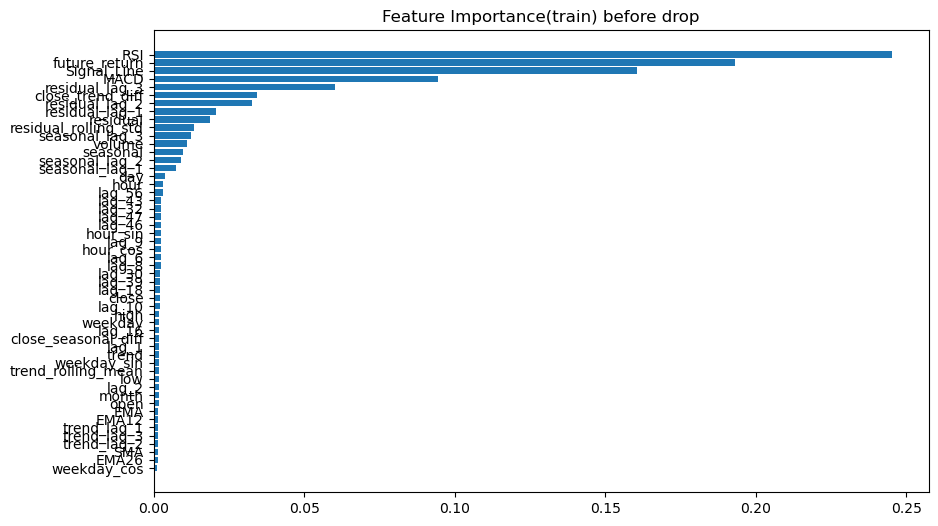

attributes.shape before drop:  (422860, 52)
attributes.shape after the drop:  (422860, 12)


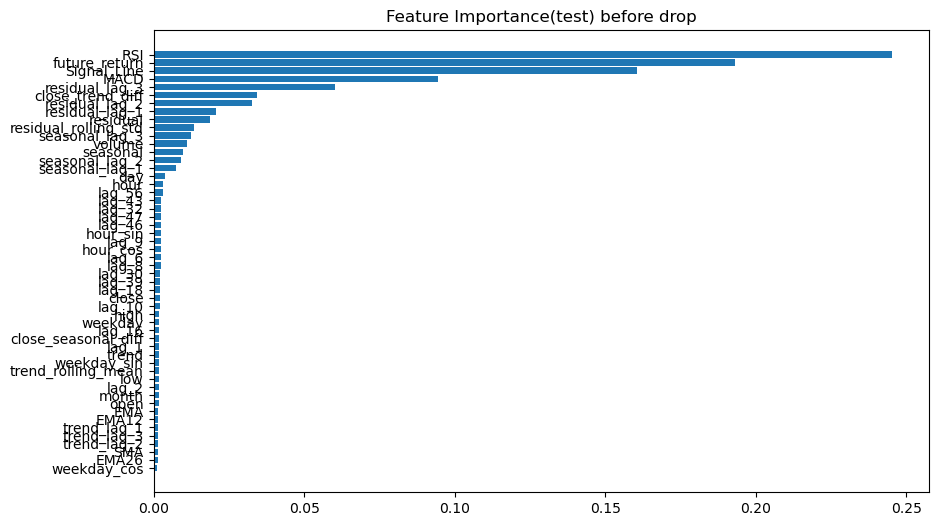

attributes.shape before drop:  (105715, 52)
attributes.shape after the drop:  (105715, 12)
High important features after feature selection (regularization):  Index(['volume', 'residual', 'residual_lag_1', 'residual_lag_2',
       'seasonal_lag_3', 'residual_lag_3', 'residual_rolling_std',
       'close_trend_diff', 'RSI', 'MACD', 'Signal_Line', 'future_return'],
      dtype='object')


[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    6.0s
[Parallel(n_jobs=9)]: Done 193 out of 193 | elapsed:   32.7s finished
[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 193 out of 193 | elapsed:    0.7s finished
[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 193 out of 193 | elapsed:    0.1s finished


classification_train_report_RandomForestClassifier_adasyn:                precision    recall  f1-score   support

           0       1.00      0.97      0.98    420626
           1       0.14      0.95      0.25      1040
           2       0.15      0.97      0.26      1194

    accuracy                           0.97    422860
   macro avg       0.43      0.97      0.50    422860
weighted avg       1.00      0.97      0.98    422860

classification_test_report_RandomForestClassifier_adasyn:                precision    recall  f1-score   support

           0       1.00      0.97      0.98    105186
           1       0.12      0.79      0.22       265
           2       0.12      0.80      0.21       264

    accuracy                           0.97    105715
   macro avg       0.41      0.86      0.47    105715
weighted avg       0.99      0.97      0.98    105715

F1-Score (Macro): 0.4697


[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 193 out of 193 | elapsed:    0.7s finished
[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 193 out of 193 | elapsed:    0.1s finished


In [99]:
with mlflow.start_run(run_name = mlflow_run_name):
    mlflow.log_param("train size", len(attributes_train))
    mlflow.log_param("test size", len(attributes_test))

    # Create a Optuna study and optimize
    study = optuna.create_study(direction='maximize')
    study.optimize(
        partial(objective, model_type = model_type, oversampling_type = oversampling_type, n_splits = n_splits),
        n_trials = n_trials
    )

    # Visualize optimization history
    optimization_history_plot = vis.plot_optimization_history(study)
    # Visualize parameter importance
    param_importance_plot = vis.plot_param_importances(study)
    # Visualize hyperparameter values
    hyperparameter_values_plot = vis.plot_parallel_coordinate(study)

    # Save visualizations to files
    optimization_history_plot.write_html(f"data/{model_type}/{oversampling_type}/optimization_history_{model_type}_{oversampling_type}.html")
    param_importance_plot.write_html(f"data/{model_type}/{oversampling_type}/param_importances_{model_type}_{oversampling_type}.html")
    hyperparameter_values_plot.write_html(f"data/{model_type}/{oversampling_type}/hyperparameter_values_{model_type}_{oversampling_type}.html")

    # Log visualization MLflow artifacts
    mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/optimization_history_{model_type}_{oversampling_type}.html")
    mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/param_importances_{model_type}_{oversampling_type}.html")
    mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/hyperparameter_values_{model_type}_{oversampling_type}.html")

    # Output the best hyperparameters
    print("Best Parameters:", study.best_params)
    print("Best F1-macro-score:", study.best_value)
    print("Best Trial:", study.best_trial)

    # mlflow.log_params('class_weight_1', study.best_params['class_weight_1'])
    # mlflow.log_params('class_weight_2', study.best_params['class_weight_2'])
    mlflow.log_metric("best_F1-macro-score", study.best_value)
    
    # Train best model
    # merged_params = merge_params(initial_forest_model_parameters, study.best_params)
    # # Remove class_weight keys
    merged_params = initial_forest_model_parameters | study.best_params
    del merged_params['class_weight_1']
    del merged_params['class_weight_2']

    print("merged_params:", merged_params)

    mlflow.log_params(merged_params)
    
    # Train the Final Model with Best Parameters
    rf_model = RandomForestClassifier(**merged_params)
    rf_model.fit(attributes_train, target_train)

    # Removing irrelevant features (feature selection)
    attributes_train_reg = remove_low_important_features(rf_model, attributes_train, attributes_type = 'train')
    attributes_test_reg = remove_low_important_features(rf_model, attributes_test, attributes_type = 'test')

    print(f"High important features after feature selection (regularization): ", attributes_train_reg.columns)

    # Train the Final Model with Best Parameters and without the low important featires
    rf_model_reg = RandomForestClassifier(**merged_params)
    rf_model_reg.fit(attributes_train_reg, target_train)

    # Validate
    target_train_pred = rf_model_reg.predict(attributes_train_reg)
    classification_train_report = classification_report(target_train, target_train_pred)

    target_test_pred = rf_model_reg.predict(attributes_test_reg)
    classification_test_report = classification_report(target_test, target_test_pred)
   
    print(f"classification_train_report_{model_type}_{oversampling_type}: ", classification_train_report)
    print(f"classification_test_report_{model_type}_{oversampling_type}: ", classification_test_report)

    # F1-macro score after the regularization
    f1_macro_score = f1_score(target_test, target_test_pred, average='macro')
    print(f"F1-Score (Macro): {f1_macro_score:.4f}")
    
    mlflow.log_metric("Final-F1-macro-score", f1_macro_score)

    # Log metrics
    mlflow.log_metric(f"train_accuracy_{model_type}_{oversampling_type}", rf_model_reg.score(attributes_train_reg, target_train))
    mlflow.log_metric(f"test_accuracy_{model_type}_{oversampling_type}", rf_model_reg.score(attributes_test_reg, target_test))

    with open(f"data/{model_type}/{oversampling_type}/train_report_{model_type}_{oversampling_type}.txt",  "w") as f:
        f.write(classification_train_report)
    with open(f"data/{model_type}/{oversampling_type}/test_report_{model_type}_{oversampling_type}.txt",  "w") as f:
        f.write(classification_test_report)
        
    pickle.dump(rf_model_reg, open(f"data/{model_type}/{oversampling_type}/model_{model_type}_{oversampling_type}.pkl", "wb"))

    # Log artifacts
    mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/model_{model_type}_{oversampling_type}.pkl")
    mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/train_report_{model_type}_{oversampling_type}.txt")
    mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/test_report_{model_type}_{oversampling_type}.txt")
    
    classes = [0, 1, 2]
    #evaluate_model(rf_model_reg, attributes_test, target_test, classes)

### 4.2. GridSearchCV

##### GridSearchCV

In [ ]:
from sklearn.pipeline import Pipeline

X = attributes
y = target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = False)

# Define pipeline with placeholder for scaler and model
pipeline = Pipeline([
    ('scaler', None),  # Placeholder for scaler
    ('rf', RandomForestClassifier(random_state=42))
])

# Define parameter grid for grid search
param_grid = {
    'scaler': [None, MinMaxScaler(), StandardScaler()],  # Test with and without scaling
    'rf__n_estimators': [100, 300],                # Number of trees
    # 'rf__n_estimators': [100, 300, 500],                # Number of trees
    'rf__max_depth': [None, 10, 20, 30],                # Tree depth
    'rf__min_samples_split': [2, 5, 10],                # Min samples required to split
    'rf__min_samples_leaf': [1, 2, 4],                  # Min samples required at leaf node
    'rf__max_features': ['sqrt', 'log2', None],         # Max features considered for split
    'rf__bootstrap': [True, False]                      # Use bootstrap sampling or not
}

# Perform grid search
# grid_search = GridSearchCV(
#     pipeline,
#     param_grid,
#     cv=2,                # 3-fold cross-validation
#     # cv=3,                # 3-fold cross-validation
#     scoring='accuracy',  # Optimize for accuracy
#     verbose=2,
#     n_jobs=-9          
#     # n_jobs=-1            # Use all available CPU cores
# )

# Fit grid search
grid_search.fit(X_train, y_train)

# Output best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

# Evaluate on test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set accuracy:", test_score)


## 5. Evaluate the Model

**ROC-AUC score:**
   - Calculate the ROC-AUC score for each class individually to understand how well the model performs for the minority classes (1 and 2):

**Precision-Recall Curves:**
   - Precision-recall curves are often more informative for imbalanced datasets. They focus on the trade-off between precision and recall for each class.

In [63]:
def print_classification_report_multiclass(model, attributes_test_data, target_test_data): 
    # Predictions
    target_pred_data = model.predict(attributes_test_data)

    # Calculate F1-score (weighted)
    f1 = f1_score(target_test_data, target_pred_data, average='weighted')

    print(f"F1 score (weighted) : [{f1}]")
    
    # Classification Report
    print("Classification report: ")
    print(classification_report(target_test_data, target_pred_data))

In [64]:
def plot_classification_error(model, eval_metric='mlogloss'):
    # Retrieve evaluation results
    eval_results = model.evals_result()
    
    # Plot classification error
    plt.figure(figsize=(10, 6))
    plt.plot(eval_results['validation_0'][eval_metric], label='Train Error')
    plt.plot(eval_results['validation_1'][eval_metric], label='Validation Error')
    plt.xlabel('Boosting Rounds')
    plt.ylabel('Classification Error')
    plt.title(f"Classification Error ({eval_metric}) During Training ")
    plt.legend()
    plt.grid(True)
    plt.show()

In [65]:
def plot_roc_curve_multiclass(model,target_test_data, classes):
    print(f"Calculate the ROC-AUC score for each class individually to understand how well the model performs for the minority classes")
    
    # Binarize labels for one-vs-rest (multiclass ROC-AUC)
    target_test_binarized = label_binarize(target_test_data, classes = classes)
    target_pred_prob = model.predict_proba(attributes_test) # predicted probabilities

    # ROC-AUC for multiclass
    roc_auc = roc_auc_score(target_test, target_pred_prob, multi_class='ovr') # 'ovr' (one-vs-rest), 'ovo'-(one-vs-one)
    print(f"ROC-AUC Score: {roc_auc}")
    
    # Compute ROC-AUC for each class
    roc_auc_per_class = roc_auc_score(target_test_binarized, target_pred_prob, average=None)
    print(f"ROC-AUC per class {classes}:", roc_auc_per_class)

    # Compute ROC curve and ROC-AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(target_test_binarized[:, i], target_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves for each class
    plt.figure()
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')
    
    # Plot the diagonal
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    
    # Configure the plot
    plt.title('ROC-AUC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

In [66]:
def plot_precision_recal_curve_multiclass(model,target_test_data, classes):
    # Binarize labels for one-vs-rest (multiclass precision-recall)
    target_test_binarized = label_binarize(target_test_data, classes = classes)
    target_pred_prob = model.predict_proba(attributes_test) # predicted probabilities
    
    # Plot precision-recall curves for each class
    for i in range(3):  # Assuming 3 classes (0, 1, 2)
        precision, recall, _ = precision_recall_curve(target_test_binarized[:, i], target_pred_prob[:, i])
        plt.plot(recall, precision, label=f'Class {i}')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

In [ ]:
def plot_feature_importance(model):
    # Feature importances
    importances = model.feature_importances_
    feature_names = attributes_train.columns
    sorted_indices = importances.argsort()
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_indices)), importances[sorted_indices], align='center')
    plt.yticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices])
    plt.title('Feature Importance')
    plt.show()

In [68]:
def evaluate_model(model, attributes_test_data, target_test_data, classes):
    print_classification_report_multiclass(model, attributes_test_data, target_test_data)
    # plot_classification_error(model, eval_metric='mlogloss')
    # plot_classification_error(model, eval_metric='merror')
    plot_roc_curve_multiclass(model, target_test_data, classes)
    plot_precision_recal_curve_multiclass(model, target_test_data, classes)
    plot_feature_importance_xgb(model)

F1 score (weighted) : [0.9934051011788023]
Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105186
           1       0.59      0.11      0.18       265
           2       0.45      0.11      0.17       264

    accuracy                           1.00    105715
   macro avg       0.68      0.40      0.45    105715
weighted avg       0.99      1.00      0.99    105715



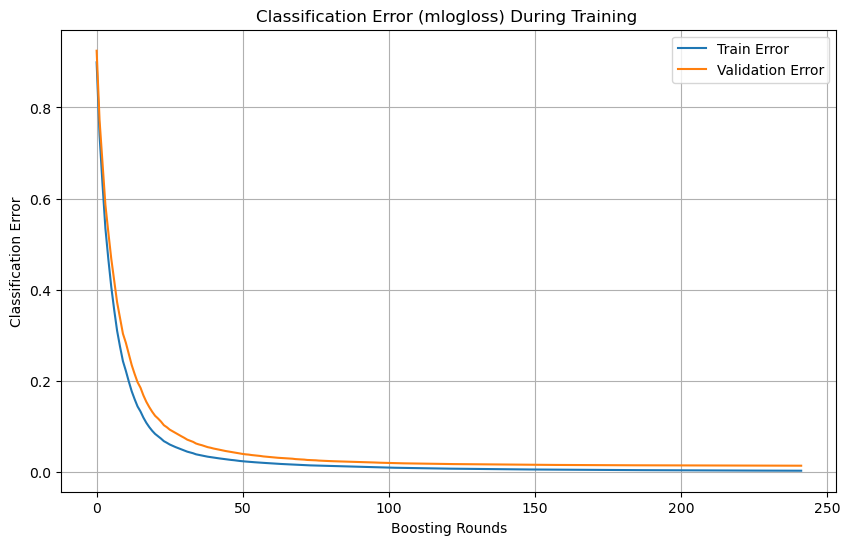

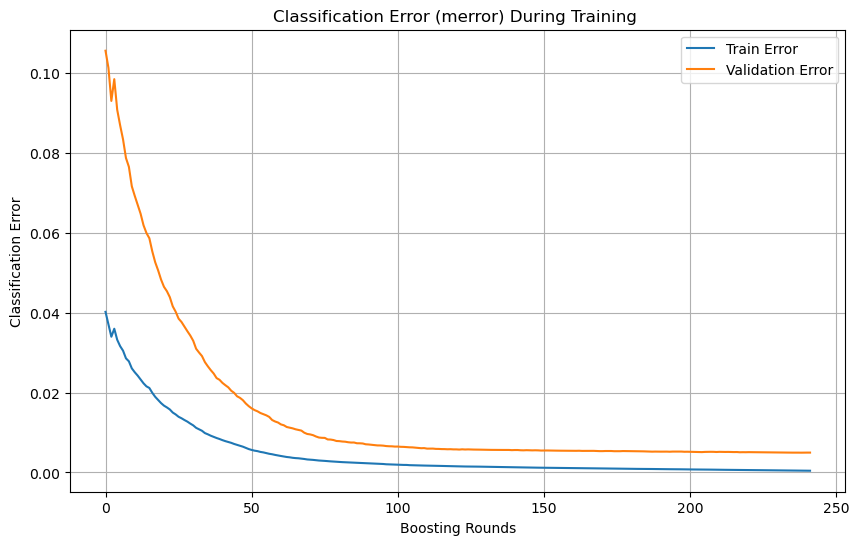

Calculate the ROC-AUC score for each class individually to understand how well the model performs for the minority classes
ROC-AUC Score: 0.9942291268915734
ROC-AUC per class [0, 1, 2]: [0.99133443 0.99598447 0.99536849]


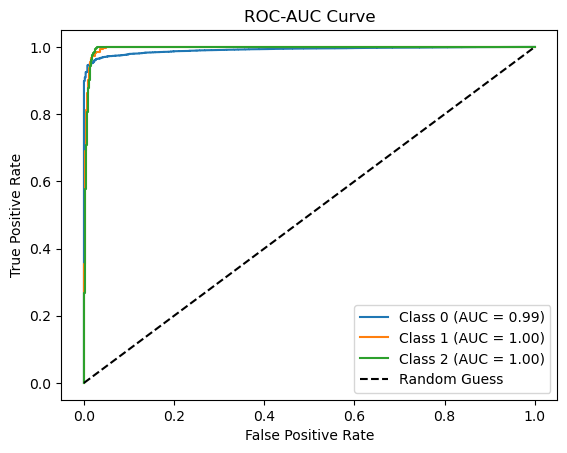

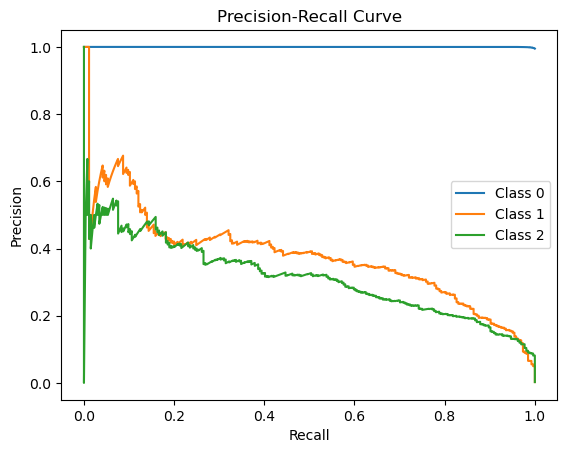

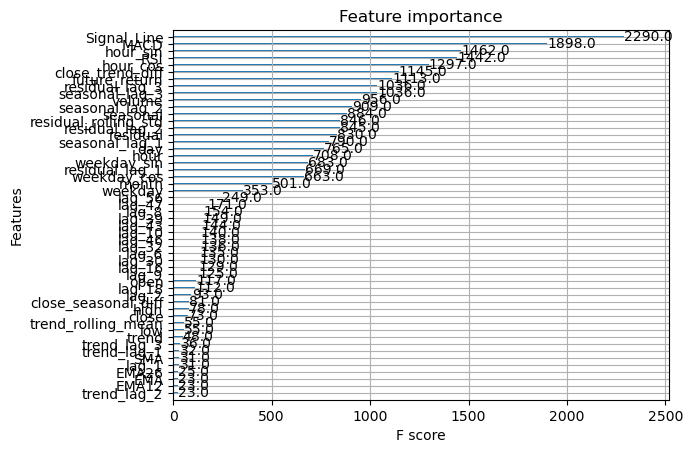

In [90]:
classes = [0, 1, 2]
#evaluate_model(rf_model, attributes_test, target_test, classes)

## 6. Time Series Cross-Validation

In [85]:
def run_time_series_cross_validation(attributes_data, oversampling_type = None, n_splits = 5):
    """
    Runs a cross validation for time series data. The 'attributes_data' is splitted with a 'TimeSeriesSplit' in 'n_splits'-folds
    
    Parameters:
    ----------
    attributes_data: attributes data for the cross validation
    n_splits : number of splis the data for the cross validation
    oversampling_type : applies oversampling to generate synthetic examples for minority classes. Possible values: 'adasyn' or 'smote'
    """ 
    
    print(f"Start time series cross validation with oversampling:[{oversampling_type}] and n_splits:[{n_splits}]")
    
    # Use TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits = n_splits)

    # Initialize metrics
    f1_macro_scores = []
    f1_weighted_scores = []
    balanced_acc_scores = []
    kappa_scores = []
    log_loss_scores = []
    roc_auc_scores = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(attributes_data)):
        print(f"Fold {fold + 1}")

        # Get data for the current fold
        attributes_train_fold, attributes_val_fold = attributes.iloc[train_idx], attributes.iloc[val_idx]
        target_train_fold, target_val_fold = target.iloc[train_idx], target.iloc[val_idx]

        # Use oversampling
        attributes_train_fold, target_train_fold = create_oversampling(
            attributes_train_fold,
            target_train_fold, 
            oversampling_type = oversampling_type
        )
        
        # Train model with the Initial hyper params
        rf_model_split = RandomForestClassifier(**initial_forest_model_parameters)
        rf_model_split.fit(attributes_train_fold, target_train_fold)
    
        # Predictions and probabilities
        target_val_pred = rf_model_split.predict(attributes_val_fold)
        target_val_proba = rf_model_split.predict_proba(attributes_val_fold)

        # Calculate metrics for this fold
        f1_macro_scores.append(f1_score(target_val_fold, target_val_pred, average='macro'))
        f1_weighted_scores.append(f1_score(target_val_fold, target_val_pred, average='weighted'))
        balanced_acc_scores.append(balanced_accuracy_score(target_val_fold, target_val_pred))
        kappa_scores.append(cohen_kappa_score(target_val_fold, target_val_pred))
        log_loss_scores.append(log_loss(target_val_fold, target_val_proba))
        roc_auc_scores.append(roc_auc_score(target_val_fold, target_val_proba, multi_class='ovr'))
        
        print(f"Fold {fold+1} Classification Report")
        print(classification_report(target_val_fold, target_val_pred))

    # Aggregate metrics across folds
    print("\nCross-Validated Metrics:")
    print(f"F1-Score (Macro): {np.mean(f1_macro_scores):.4f} ± {np.std(f1_macro_scores):.4f}")
    print(f"F1-Score (Weighted): {np.mean(f1_weighted_scores):.4f} ± {np.std(f1_weighted_scores):.4f}")
    print(f"Balanced Accuracy: {np.mean(balanced_acc_scores):.4f} ± {np.std(balanced_acc_scores):.4f}")
    print(f"Cohen's Kappa: {np.mean(kappa_scores):.4f} ± {np.std(kappa_scores):.4f}")
    print(f"Log Loss: {np.mean(log_loss_scores):.4f} ± {np.std(log_loss_scores):.4f}")
    print(f"ROC-AUC: {np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}")

In [72]:
run_time_series_cross_validation(attributes, oversampling_type, n_splits = 5)

Start time series cross validation with oversampling:[adasyn] and n_splits:[5]
Fold 1
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    9.1s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:   50.3s
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed:  1.4min finished
[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:    0.1s
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:    0.1s
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed:    0.2s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     87639
           1       0.05      0.67      0.10       209
           2       0.06      0.57      0.10       247

    accuracy                           0.94     88095
   macro avg       0.37      0.73      0.39     88095
weighted avg       0.99      0.94      0.97     88095

Fold 2
Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:   22.5s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:  2.0min
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed:  3.2min finished
[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:    0.1s
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:    0.1s
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed:    0.2s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     87564
           1       0.07      0.60      0.12       248
           2       0.06      0.72      0.12       283

    accuracy                           0.94     88095
   macro avg       0.38      0.75      0.40     88095
weighted avg       0.99      0.94      0.96     88095

Fold 3
Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:   36.7s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:  3.2min
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed:  5.1min finished
[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:    0.1s
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:    0.1s
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed:    0.2s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     87656
           1       0.05      0.87      0.09       215
           2       0.05      0.93      0.09       224

    accuracy                           0.91     88095
   macro avg       0.37      0.91      0.38     88095
weighted avg       0.99      0.91      0.95     88095

Fold 4
Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:   49.7s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:  4.2min
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed:  6.8min finished
[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:    0.1s
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:    0.1s
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed:    0.3s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     87620
           1       0.05      0.90      0.09       231
           2       0.04      0.86      0.08       244

    accuracy                           0.90     88095
   macro avg       0.36      0.89      0.37     88095
weighted avg       0.99      0.90      0.94     88095

Fold 5
Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:  1.1min
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:  5.6min
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed:  9.0min finished
[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:    0.1s
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:    0.1s
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed:    0.2s finished


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     87649
           1       0.05      0.92      0.10       225
           2       0.04      0.90      0.08       221

    accuracy                           0.91     88095
   macro avg       0.36      0.91      0.38     88095
weighted avg       0.99      0.91      0.95     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3844 ± 0.0106
F1-Score (Weighted): 0.9534 ± 0.0099
Balanced Accuracy: 0.8373 ± 0.0788
Cohen's Kappa: 0.0906 ± 0.0111
Log Loss: 0.2031 ± 0.0265
ROC-AUC: 0.9678 ± 0.0056


In [84]:
run_time_series_cross_validation(attributes, oversampling_type, n_splits = 5)

Start time series cross validation with oversampling:[adasyn] and n_splits:[5]
Fold 1
Original Class Distribution (ADASYN): [87684   177   239]
Balanced Class Distribution (ADASYN): [87684 87651 87567]


[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:   13.9s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:  1.3min
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed:  2.1min finished
[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:    0.1s
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:    0.1s
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed:    0.2s finished


Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     87639
           1       0.03      0.82      0.06       209
           2       0.03      0.50      0.06       247

    accuracy                           0.90     88095
   macro avg       0.36      0.74      0.36     88095
weighted avg       0.99      0.90      0.94     88095

Fold 2
Original Class Distribution (ADASYN): [175323    386    486]
Balanced Class Distribution (ADASYN): [175323 175288 175212]


[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:   33.0s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:  3.0min
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:    0.1s
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:    0.1s
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed:    0.2s finished


Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     87564
           1       0.05      0.12      0.07       248
           2       0.04      0.15      0.07       283

    accuracy                           0.98     88095
   macro avg       0.36      0.42      0.37     88095
weighted avg       0.99      0.98      0.98     88095

Fold 3
Original Class Distribution (ADASYN): [262887    634    769]
Balanced Class Distribution (ADASYN): [262887 262967 262542]


[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:   52.3s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:  4.6min
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed:  7.6min finished
[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:    0.1s
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:    0.1s
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed:    0.3s finished


Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87656
           1       0.03      0.98      0.06       215
           2       0.03      1.00      0.06       224

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095

Fold 4
Original Class Distribution (ADASYN): [350543    849    993]
Balanced Class Distribution (ADASYN): [350543 350344 350527]


[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:  1.2min
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:  6.4min
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed: 10.2min finished
[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:    0.2s
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:    0.2s
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed:    0.3s finished


Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87620
           1       0.03      0.99      0.06       231
           2       0.03      0.99      0.06       244

    accuracy                           0.83     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       0.99      0.83      0.90     88095

Fold 5
Original Class Distribution (ADASYN): [438163   1080   1237]
Balanced Class Distribution (ADASYN): [438163 438605 438731]


[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:  1.5min
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:  7.9min
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed: 12.6min finished
[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:    0.1s
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:    0.1s
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed:    0.2s finished


Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87649
           1       0.03      0.98      0.06       225
           2       0.03      1.00      0.06       221

    accuracy                           0.84     88095
   macro avg       0.35      0.94      0.34     88095
weighted avg       1.00      0.84      0.91     88095


Cross-Validated Metrics:
F1-Score (Macro): 0.3531 ± 0.0125
F1-Score (Weighted): 0.9300 ± 0.0301
Balanced Accuracy: 0.7955 ± 0.2035
Cohen's Kappa: 0.0553 ± 0.0037
Log Loss: 0.4938 ± 0.2072
ROC-AUC: 0.9549 ± 0.0121
